<h1 align="center">Credit Card Fraud Detection</h1>

__Goal:__ 

Predict the probability of an online credit card transaction being fraudulent, based on different properties of the transactions.

# 1. Setup Environment

In [2]:
import numpy as np 
import pandas as pd 

import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import time
import datetime

from   sklearn.preprocessing import LabelEncoder, minmax_scale
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.decomposition import PCA
from   sklearn.model_selection import train_test_split, GridSearchCV
from   sklearn.metrics import (confusion_matrix , classification_report, accuracy_score, roc_auc_score, 
                               plot_roc_curve, precision_recall_curve, plot_precision_recall_curve)
from   sklearn.calibration import calibration_curve
from   sklearn.calibration import CalibratedClassifierCV

from   xgboost import XGBClassifier
from   lightgbm import LGBMClassifier

from   imblearn.over_sampling import RandomOverSampler
from   scipy.stats import chi2_contingency,  f_oneway

import gc
import warnings
from   tqdm import tqdm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
%matplotlib inline
warnings.filterwarnings("ignore")

# 2. Data Overview

In [3]:
%%time
df_id   = pd.read_csv(r'C:\Users\admin\Desktop\PYTHON LEARNING\Data_Projects_01\MLp Projects\CREDIT CARD FRAUD DETECTION\Datasets\train_identity.csv')
df_tran = pd.read_csv(r'C:\Users\admin\Desktop\PYTHON LEARNING\Data_Projects_01\MLp Projects\CREDIT CARD FRAUD DETECTION\Datasets\train_transaction.csv')

Wall time: 29.8 s


In [4]:
df_id.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

### Identity Data Description

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

In [5]:
df_tran.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

### Transaction Data Description
- __TransactionDT__: timedelta from a given reference datetime (not an actual timestamp)
- __TransactionAMT__: transaction payment amount in USD
- __ProductCD__: product code, the product for each transaction
- __card1 - card6__: payment card information, such as card type, card category, issue bank, country, etc.
- __addr__: address
- __dist__: distance
- **P_ and (R__) emaildomain**: purchaser and recipient email domain
- __C1-C14__: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- __D1-D15__: timedelta, such as days between previous transaction, etc.
- __M1-M9__: match, such as names on card and address, etc.
- __Vxxx__: Vesta engineered rich features, including ranking, counting, and other entity relations.

# 3. Optimize Memory Used by Data

### Memory occupied by the dataframe (in mb)

In [6]:
df_id.memory_usage(deep=True).sum() / 1024**2 

157.63398933410645

In [7]:
df_tran.memory_usage(deep=True).sum() / 1024**2

2100.701406478882

### Define memory reduction function

In [8]:
# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
df_id   = reduce_mem_usage(df_id)
df_tran = reduce_mem_usage(df_tran)

Mem. usage decreased to 138.38 Mb (12.2% reduction)
Mem. usage decreased to 867.89 Mb (58.7% reduction)


# 4. Basic Data Stats

### Shape of dataframe

In [10]:
df_id.shape

(144233, 41)

In [11]:
df_tran.shape

(590540, 394)

__Check how many transactions has ID info__

In [12]:
df_tran.TransactionID.isin(df_id.TransactionID).sum()

144233

### Summary of dataframe

In [13]:
from pandas_summary import DataFrameSummary
df_id_summary = DataFrameSummary(df_id)
df_id_summary.summary()

TransactionID     id_01         id_02    id_03    id_04  \
count               144233.0  144233.0      140872.0  66324.0  66324.0   
mean          3236329.311288       NaN  174716.59375      0.0     -0.0   
std            178849.571186       0.0   159651.8125      0.0      0.0   
min                2987004.0    -100.0           1.0    -13.0    -28.0   
25%                3077142.0     -10.0       67992.0      0.0      0.0   
50%                3198818.0      -5.0      125800.5      0.0      0.0   
75%                3392923.0      -5.0      228749.0      0.0      0.0   
max                3577534.0       0.0      999595.0     10.0      0.0   
counts                144233    144233        140872    66324    66324   
uniques               144233        77        115655       24       15   
missing                    0         0          3361    77909    77909   
missing_perc              0%        0%         2.33%   54.02%   54.02%   
types                numeric   numeric       numeric  numeric  numeric   

                 id_05     id_06      id_07      id_08    id_09    id_10  \
count         136865.0  136865.0     5155.0     5155.0  74926.0  74926.0   
mean               NaN       NaN        inf       -inf      0.0     -0.0   
std                0.0       0.0  11.382812  26.078125      0.0      0.0   
min              -72.0    -100.0      -46.0     -100.0    -36.0   -100.0   
25%                0.0      -6.0        5.0      -48.0      0.0      0.0   
50%                0.0       0.0       14.0      -34.0      0.0      0.0   
75%                1.0       0.0       22.0      -23.0      0.0      0.0   
max               52.0       0.0       61.0        0.0     25.0      0.0   
counts          136865    136865       5155       5155    74926    74926   
uniques             93       101         84         94       46       62   
missing           7368      7368     139078     139078    69307    69307   
missing_perc     5.11%     5.11%     96.43%     96.43%   48.05%   48.05%   
types          numeric   numeric    numeric    numeric  numeric  numeric   

                 id_11   id_12     id_13    id_14        id_15   id_16  \
count         140978.0     NaN  127320.0  80044.0          NaN     NaN   
mean               NaN     NaN       NaN      NaN          NaN     NaN   
std                0.0     NaN       0.0      NaN          NaN     NaN   
min               90.0     NaN      10.0   -660.0          NaN     NaN   
25%              100.0     NaN      49.0   -360.0          NaN     NaN   
50%              100.0     NaN      52.0   -300.0          NaN     NaN   
75%              100.0     NaN      52.0   -300.0          NaN     NaN   
max              100.0     NaN      64.0    720.0          NaN     NaN   
counts          140978  144233    127320    80044       140985  129340   
uniques            146       2        54       25            3       2   
missing           3255       0     16913    64189         3248   14893   
missing_perc     2.26%      0%    11.73%   44.50%        2.25%  10.33%   
types          numeric    bool   numeric  numeric  categorical    bool   

                 id_17     id_18     id_19     id_20    id_21     id_22  \
count         139369.0   45113.0  139318.0  139261.0   5159.0    5169.0   
mean               NaN       inf       NaN       NaN      inf       inf   
std                0.0  1.561523       NaN       NaN      inf  6.898438   
min              100.0      10.0     100.0     100.0    100.0      10.0   
25%              166.0      13.0     266.0     256.0    252.0      14.0   
50%              166.0      15.0     341.0     472.0    252.0      14.0   
75%              225.0      15.0     427.0     533.0    486.5      14.0   
max              229.0      29.0     671.0     661.0    854.0      44.0   
counts          139369     45113    139318    139261     5159      5169   
uniques            104        18       522       394      490        25   
missing           4864     99120      4915      497

In [14]:
df_tran.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06             NaN   
std     1.704744e+05       0.183755   4.617224e+06             NaN   
min     2.987000e+06       0.000000   8.640000e+04        0.250977   
25%     3.134635e+06       0.000000   3.027058e+06       43.312500   
50%     3.282270e+06       0.000000   7.306528e+06       68.750000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31936.000000   

               card1     card2     card3     card5     addr1     addr2  \
count  590540.000000  581607.0  588975.0  586281.0  524834.0  524834.0   
mean     9898.734658       NaN       NaN       NaN       NaN       NaN   
std      4901.170153       NaN       0.0       0.0       NaN       0.0   
min      1000.000000     100.0     100.0     100.0     100.0      10.0   
25%      6019.000000     214.0     150.0     166.0     204.0      87.0   
50%      9678.000000     361.0     150.0     226.0     299.0      87.0   
75%     14184.000000     512.0     150.0     226.0     330.0      87.0   
max     18396.000000     600.0     231.0     237.0     540.0     102.0   

          dist1    dist2        C1        C2        C3        C4        C5  \
count  238269.0  37627.0  590540.0  590540.0  590540.0  590540.0  590540.0   
mean        NaN      inf       NaN       NaN       0.0       NaN       NaN   
std         NaN      inf       NaN       NaN       0.0       NaN       NaN   
min         0.0      0.0       0.0       0.0       0.0       0.0       0.0   
25%         3.0      7.0       1.0       1.0       0.0       0.0       0.0   
50%         8.0     37.0       1.0       1.0       0.0       0.0       0.0   
75%        24.0    206.0       3.0       3.0       0.0       0.0       1.0   
max     10288.0  11624.0    4684.0    5692.0      26.0    2252.0     349.0   

             C6        C7        C8        C9       C10       C11       C12  \
count  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0   
mean        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
std         NaN       NaN       NaN       0.0       NaN       NaN       NaN   
min         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
25%         1.0       0.0       0.0       0.0       0.0       1.0       0.0   
50%         1.0       0.0       0.0       1.0       0.0       1.0       0.0   
75%         2.0       0.0       0.0       2.0       0.0       2.0       0.0   
max      2252.0    2256.0    3332.0     210.0    3256.0    3188.0    3188.0   

            C13       C14        D1        D2        D3        D4        D5  \
count  590540.0  590540.0  589271.0  309743.0  327662.0  421618.0  280699.0   
mean        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
std         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
min         0.0       0.0       0.0       0.0       0.0    -122.0       0.0   
25%         1.0       1.0       0.0      26.0       1.0       0.0       1.0   
50%         3.0       1.0       3.0      97.0       8.0      26.0      10.0   
75%        12.0       2.0     122.0     276.0      27.0     253.0      32.0   
max      2918.0    1429.0     640.0     640.0     819.0     869.0     819.0   

            D6       D7            D8            D9       D10       D11  \
count  73187.0  38917.0  74926.000000  74926.000000  514518.0  311253.0   
mean       NaN      inf           NaN      0.000000       NaN       NaN   
std        NaN      inf           NaN      0.000000       NaN       NaN   
min      -83.0      0.0      0.000000      0.000000       0.0     -53.0   
25%        0.0      0.0      0.958496      0.208374       0.0       0.0   
50%        0.0      0.0     37.875000      0.666504      15.0      43.0   
75%       40.0     17.0    188.000000      0.833496     1

__Check class imbalance__

In [15]:
df_tran.loc[:, 'isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [16]:
df_tran.loc[:, 'isFraud'].value_counts(normalize=True)*100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

Lot of interesting things can be observed here:

- Rows in identity dataset are less than transaction dataset, that means only a subset of transactions in transactions dataset has identity data 
- Both datasets have the common and unique key as TransactionID, both can be joined at this unique key
- id_24, id_25, dist2, D7 and many more columns have 90%+ missing values, which means that these columns are probably useless so need to drop it for now
- Columns from V1 to V339 in transaction dataset are numeric whereas columns from id_01 to id_39 are of mixed datatype
- TransactionDT column is a timedelta from a given reference datetime (not an actual timestamp). But reference datetime is not known, so need to assume it and convert it to date format
- Target class is imbalanced. So no need to drop the columns where one category contains the majority of rows 

# 5. Data Preprocessing for EDA

### Merge the datasets

In [17]:
df = df_tran.merge(df_id, how='left', on='TransactionID')

del df_tran, df_id

gc.collect()

0

In [18]:
df.shape

(590540, 434)

### Add missing flag

In [19]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col + "_missing_flag"] = df[col].isnull().astype(int)

In [20]:
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

### Clean Data

In [21]:
drop_cols = []

for col in df.columns:
    missing_share = df[col].isnull().sum()/df.shape[0]
    if missing_share > 0.9:
        drop_cols.append(col)
        print(col)
    
good_cols = [col for col in df.columns if col not in drop_cols]

dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27


In [22]:
drop_cols = []
for col in good_cols:
    unique_value = df[col].nunique()
    if unique_value == 1:
        drop_cols.append(col)
        print(col)
good_cols = [col for col in good_cols if col not in drop_cols]

In [23]:
df = df[good_cols]

In [24]:
df.shape

(590540, 836)

### Create date features

In [25]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df['_Weekdays'] = df['Date'].dt.dayofweek
df['_Hours'] = df['Date'].dt.hour
df['_Days'] = df['Date'].dt.day

In [26]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1453.88 Mb (32.9% reduction)


# 6. Exploratory Data Analysis

### Check distribution of target variable

In [27]:
df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

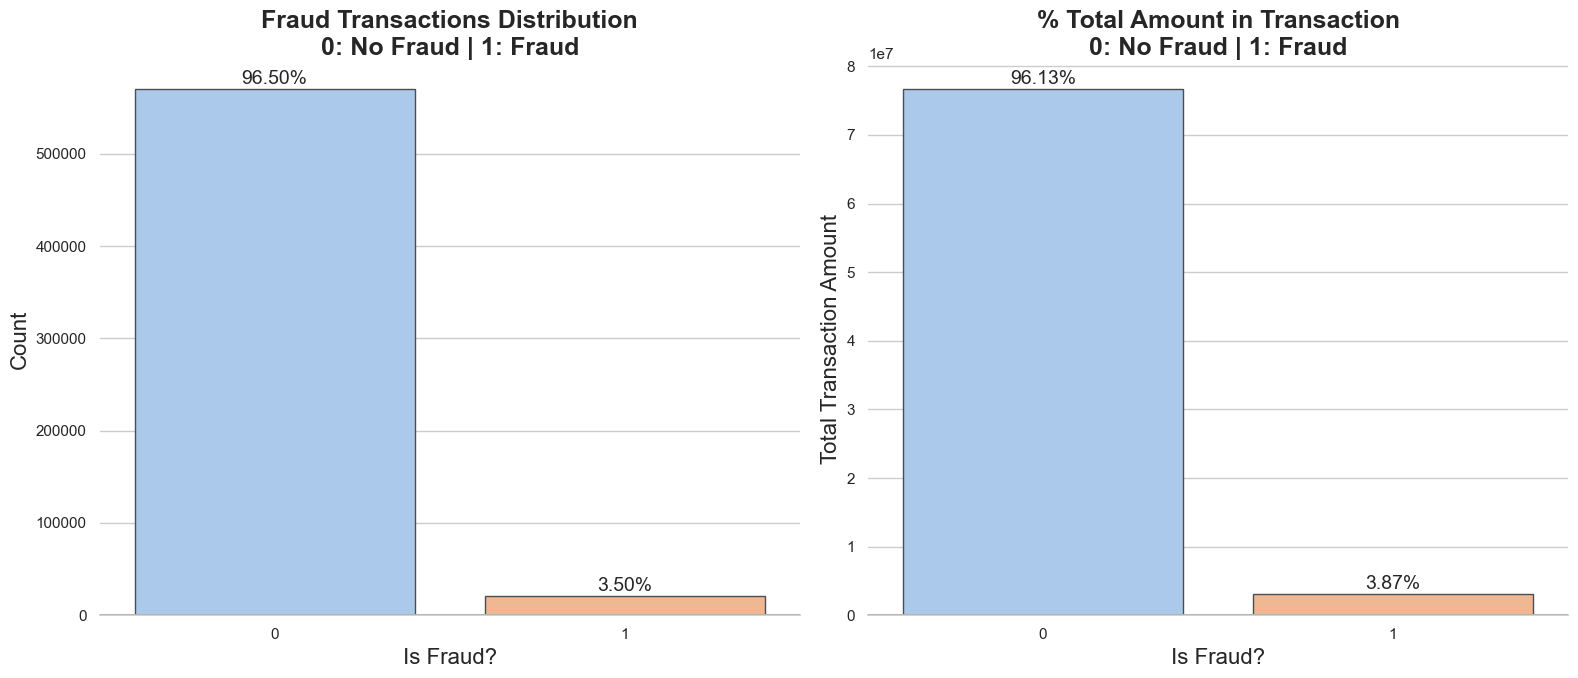

In [28]:
# Set modern and elegant theme
sns.set_theme(style="whitegrid")  # Clean background
sns.set_palette("Set2")           # Muted pastel colors
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16})

df['TransactionAmt'] = df['TransactionAmt'].astype(float)
total = len(df)
total_amt = df.groupby(['isFraud'])['TransactionAmt'].sum().sum()

plt.figure(figsize=(16,7))

# ---------- Count Plot ----------
plt.subplot(121)
g = sns.countplot(x='isFraud', data=df, palette="pastel", edgecolor=".3")
g.set_title("Fraud Transactions Distribution\n0: No Fraud | 1: Fraud", fontsize=18, weight='bold')
g.set_xlabel("Is Fraud?", fontsize=16)
g.set_ylabel('Count', fontsize=16)

# Add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2., height + total*0.01,
           '{:1.2f}%'.format(height/total*100),
           ha="center", fontsize=14, weight='medium')

# Add x-axis line
g.axhline(y=0, color='black', linewidth=1.2)

sns.despine(left=True, top=True, right=True)  # Keep modern look

# ---------- Transaction Amount Bar Plot ----------
perc_amt = df.groupby(['isFraud'])['TransactionAmt'].sum().reset_index()

plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt', data=perc_amt, palette="pastel", edgecolor=".3")
g1.set_title("% Total Amount in Transaction\n0: No Fraud | 1: Fraud", fontsize=18, weight='bold')
g1.set_xlabel("Is Fraud?", fontsize=16)
g1.set_ylabel('Total Transaction Amount', fontsize=16)

# Add percentage labels
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2., height + total_amt*0.01,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=14, weight='medium')

# Add x-axis line
g1.axhline(y=0, color='black', linewidth=1.2)

sns.despine(left=True, top=True, right=True)

plt.tight_layout()
plt.show()

In [29]:
df.groupby('isFraud')['TransactionAmt'].mean()

isFraud
0    134.511857
1    149.244353
Name: TransactionAmt, dtype: float64

- The target variable is **imbalanced**. 3.5% transactions are Fraud
- Around same % of transaction amounts are fraud

### Check distribution of Transaction Amount

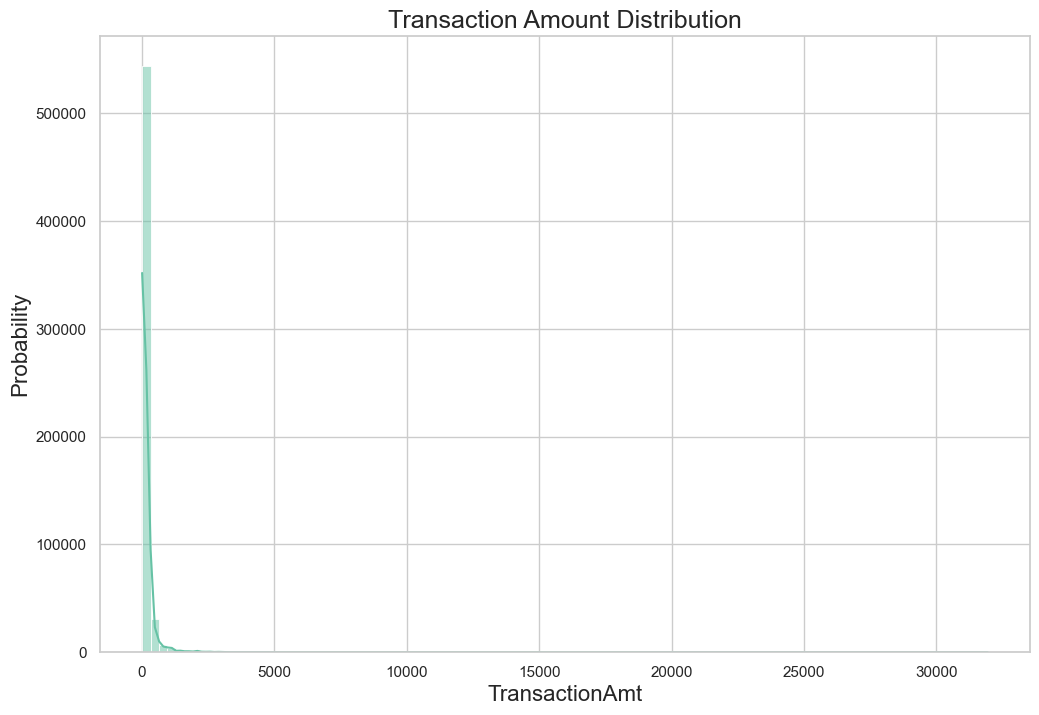

In [30]:
plt.figure(figsize=(12,8))
sns.histplot(df['TransactionAmt'],bins=100,kde=True)
plt.title("Transaction Amount Distribution",fontsize=18)
plt.ylabel("Probability")
plt.show()

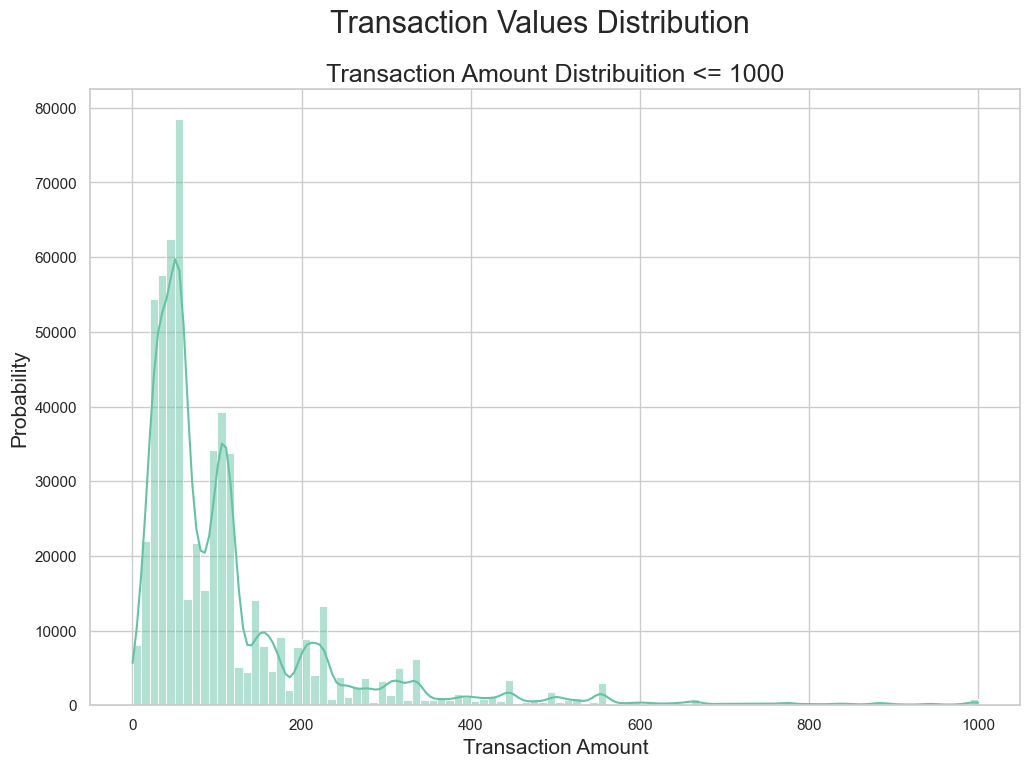

In [31]:
# Distribution plot of Transaction Amount less than 1000
plt.figure(figsize=(12,8))
plt.suptitle('Transaction Values Distribution', fontsize=22)
sns.histplot(df[df['TransactionAmt'] <= 1000]['TransactionAmt'],bins=100,kde=True)
plt.title("Transaction Amount Distribuition <= 1000", fontsize=18)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.show()

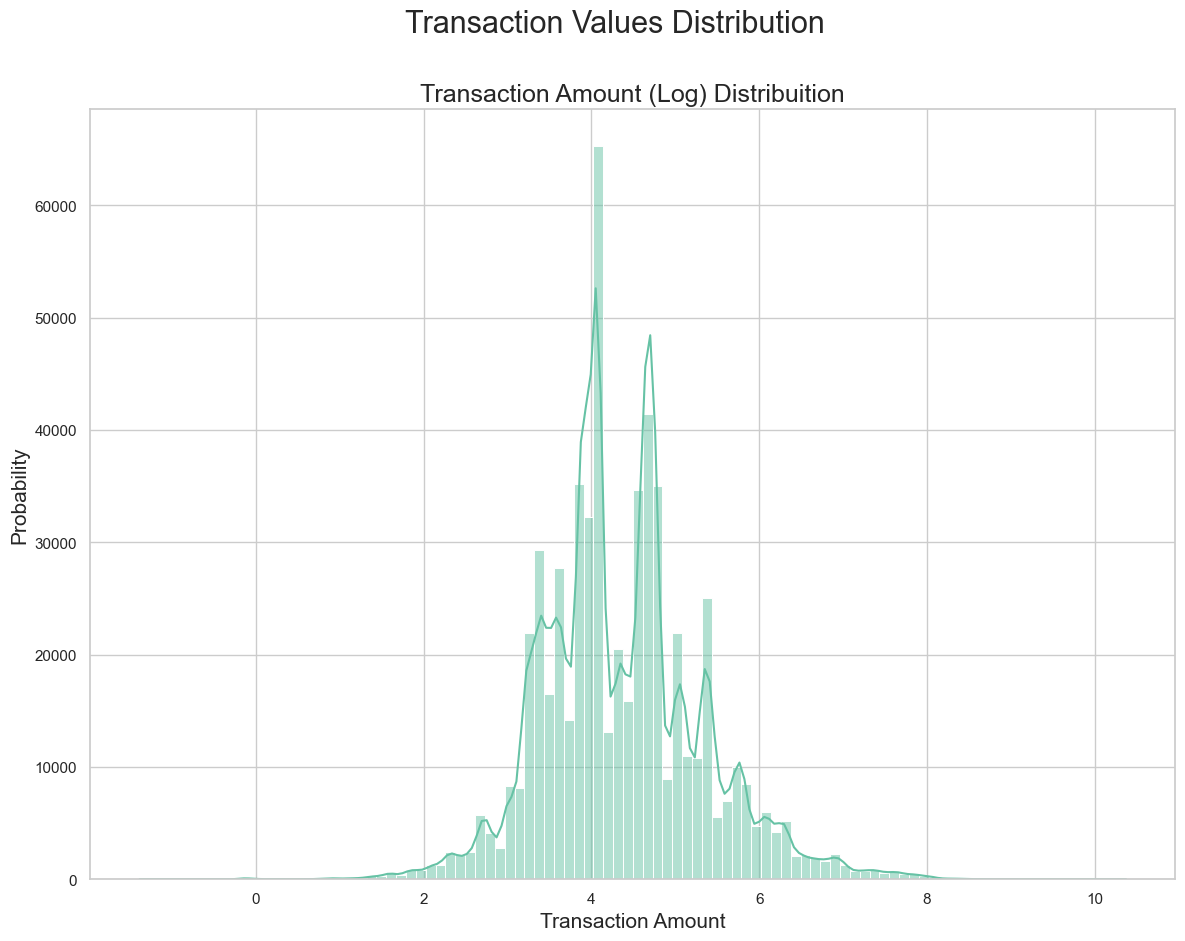

In [32]:
# Distribution plot of log of Transaction Amount less than 1000
plt.figure(figsize=(14,10))
plt.suptitle('Transaction Values Distribution', fontsize=22)
sns.histplot(np.log(df['TransactionAmt']),kde=True,bins=100)
plt.title("Transaction Amount (Log) Distribuition", fontsize=18)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.show()

- Transaction Amount is right skewed.
- Log of transaction amount is almost normally distributed, so use log of transaction amount while building the model

### Product Features

In [33]:
def plot_cat_feat_dist(df, col):
    total = len(df)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    
    # Ensure correct column names
    tmp.columns = [col, 'NoFraud', 'Fraud']
    
    plt.figure(figsize=(16,12))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    # ----- Plot 1: Overall distribution -----
    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    g.set_title(f"{col} Distribution", fontsize=16)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    
    # Add percentage labels
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width()/2.,
               height + 3,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=14) 

    # ----- Plot 2: Distribution by target -----
    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=df[col].value_counts().index)
    g1.set_title(f"{col} Distribution by Target Variable (isFraud)", fontsize=16)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)
    
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    
    # Add %Fraud as a line on secondary y-axis
    ax2 = g1.twinx()
    sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, ax=ax2)
    ax2.set_ylabel("% of Fraud Transactions", fontsize=16)
    
    plt.subplots_adjust(hspace=0.4, top=0.85)
    plt.show()

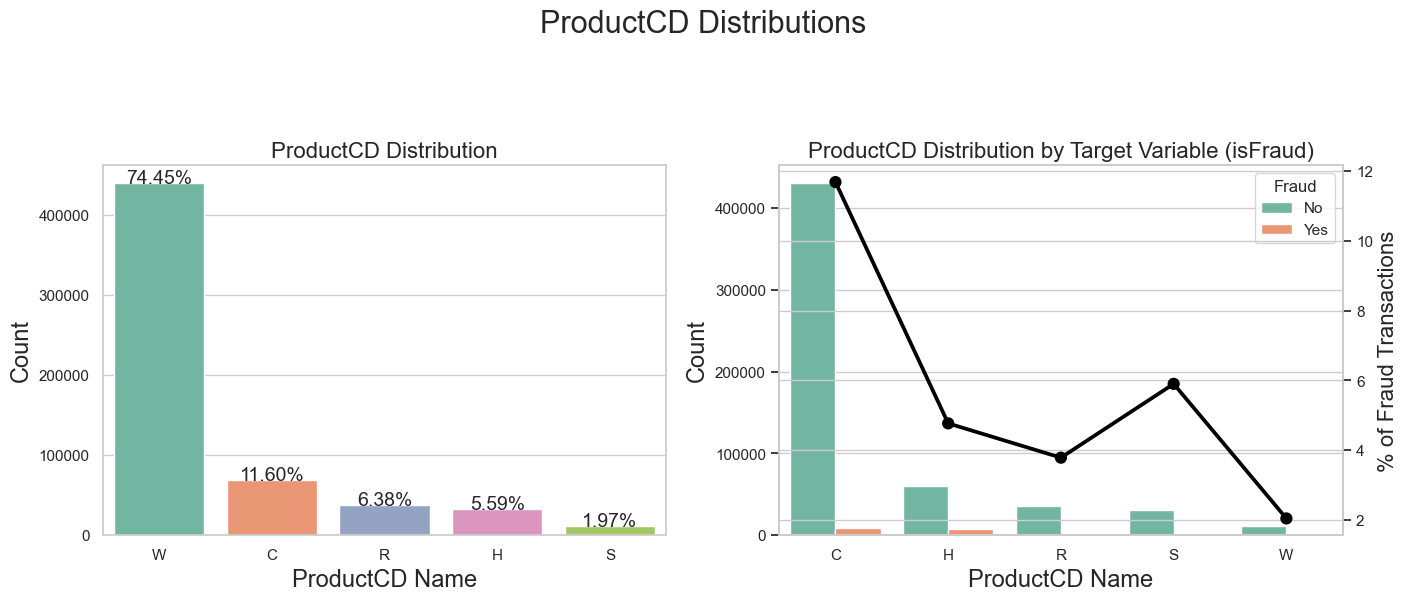

In [34]:
plot_cat_feat_dist(df, "ProductCD")

In [35]:
df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

- 75% of the transactions are for Product Catergory W
- 11.6% of the transactions are for Product Category C
- Fraud Transaction rate is maximum for Product Category C and minimum for Product Category W

### Card Features

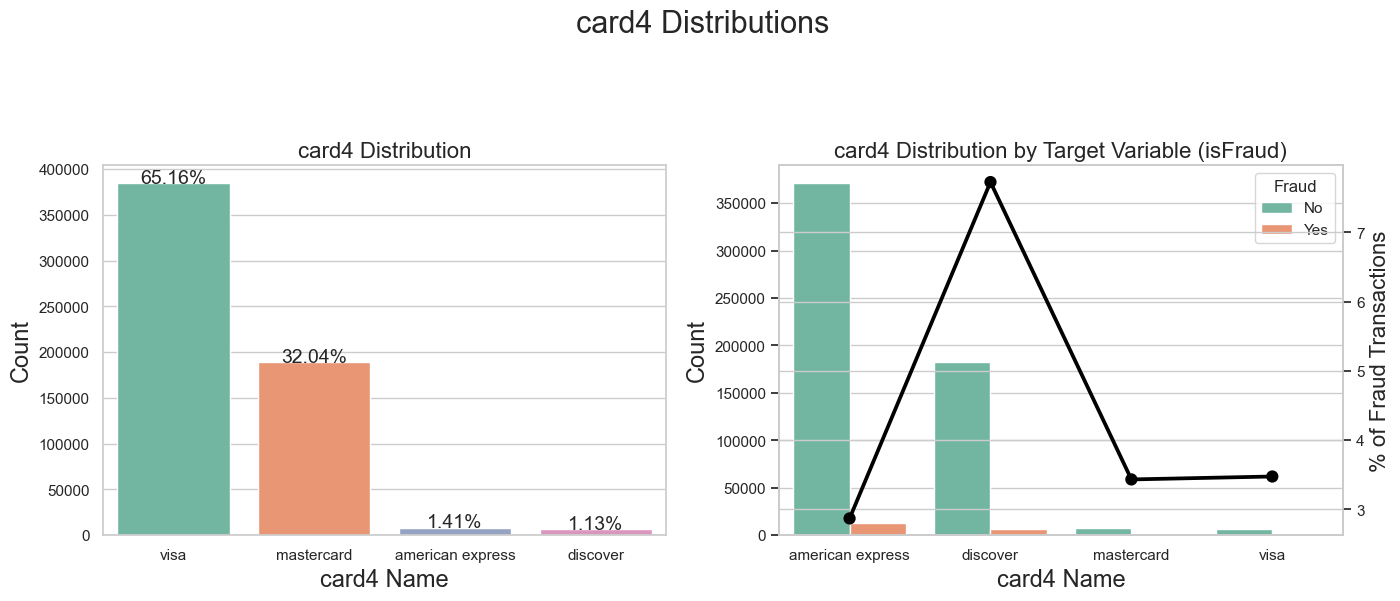

In [36]:
# Card 4
plot_cat_feat_dist(df, "card4")

In [37]:
df.groupby('card4')['isFraud'].mean()

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
Name: isFraud, dtype: float64

- 97% of transactions are from Mastercard(32%) and Visa(65%
- Fraud transaction rate is highest for discover cards(~8%) against ~3.5% of Mastercard and Visa and 2.87% in American Express

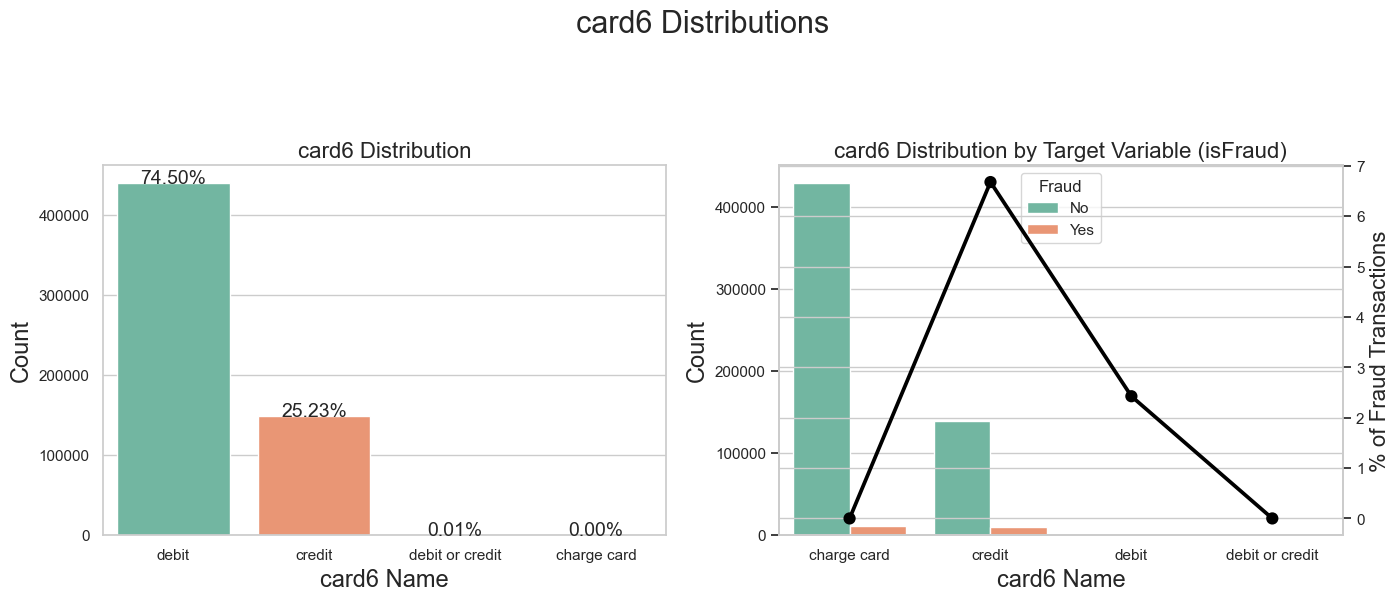

In [38]:
# Card 6
plot_cat_feat_dist(df, "card6")

In [39]:
df.groupby('card6')['isFraud'].mean()

card6
charge card        0.000000
credit             0.066785
debit              0.024263
debit or credit    0.000000
Name: isFraud, dtype: float64

- Almost all the transactions are from Credit and Debit cards. 
- Debit card transactions are almost 3 times as compared to credit card transactions.
- Fraud transaction rate is high for Credit cards as compared to Debit cards

### P emaildomain

In [40]:
df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df.loc[df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df.loc[df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df.loc[df.P_emaildomain.isin(df.P_emaildomain\
                                         .value_counts()[df.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df.P_emaildomain.fillna("NoInf", inplace=True)

In [41]:
def plot_cat_with_amt(df, col):
    """
    Plots:
    1. Count of categories vs %Fraud
    2. Transaction Amount per category vs %Fraud by Amount
    
    Handles both numeric and categorical columns, ensures proper ordering.
    """
    # Total count and total transaction amount for percentage calculations
    total = len(df)
    total_amt = df['TransactionAmt'].sum()
    
    # Determine x-axis order
    if pd.api.types.is_numeric_dtype(df[col]):
        order = sorted(df[col].dropna().unique())
    else:
        order = df[col].value_counts().index
    
    # Crosstab: %Fraud per category
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.columns = [col, 'NoFraud', 'Fraud']
    
    # ----- Plot 1: Count vs %Fraud -----
    plt.figure(figsize=(16,14))
    plt.subplot(211)
    g = sns.countplot(x=col, data=df, order=order)
    
    # Secondary axis for %Fraud
    gt = g.twinx()
    sns.pointplot(x=col, y='Fraud', data=tmp, color='black', ax=gt, order=order)
    gt.set_ylim(0, tmp['Fraud'].max() * 1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    
    g.set_title(f"Share of {col} categories and % of Fraud Transactions", fontsize=18)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    
    # Annotate counts as percentages
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width()/2.,
               height + 3,
               '{:1.2f}%'.format(height / total * 100),
               ha="center", fontsize=12)
    g.set_ylim(0, max([p.get_height() for p in g.patches]) * 1.15)
    
    # ----- Plot 2: Transaction Amount vs %Fraud -----
    amt = df.groupby(col)['TransactionAmt'].sum().reset_index()
    
    perc_amt = (df.groupby(['isFraud', col])['TransactionAmt'].sum() /
                df.groupby(col)['TransactionAmt'].sum() * 100).unstack('isFraud').fillna(0)
    perc_amt = perc_amt.reset_index()
    perc_amt.columns = [col, 'NoFraud', 'Fraud']
    
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', data=amt, order=order)
    
    g1t = g1.twinx()
    sns.pointplot(x=col, y='Fraud', data=perc_amt, color='black', ax=g1t, order=order)
    g1t.set_ylim(0, perc_amt['Fraud'].max() * 1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    
    g1.set_title(f"Transaction Amount by {col} categories and % of Fraud Transactions (Amounts)", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount (U$)", fontsize=16)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
    
    # Annotate transaction amounts as percentages
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x() + p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height / total_amt * 100),
                ha="center", fontsize=12)
    
    plt.subplots_adjust(hspace=0.4, top=0.9)
    plt.show()

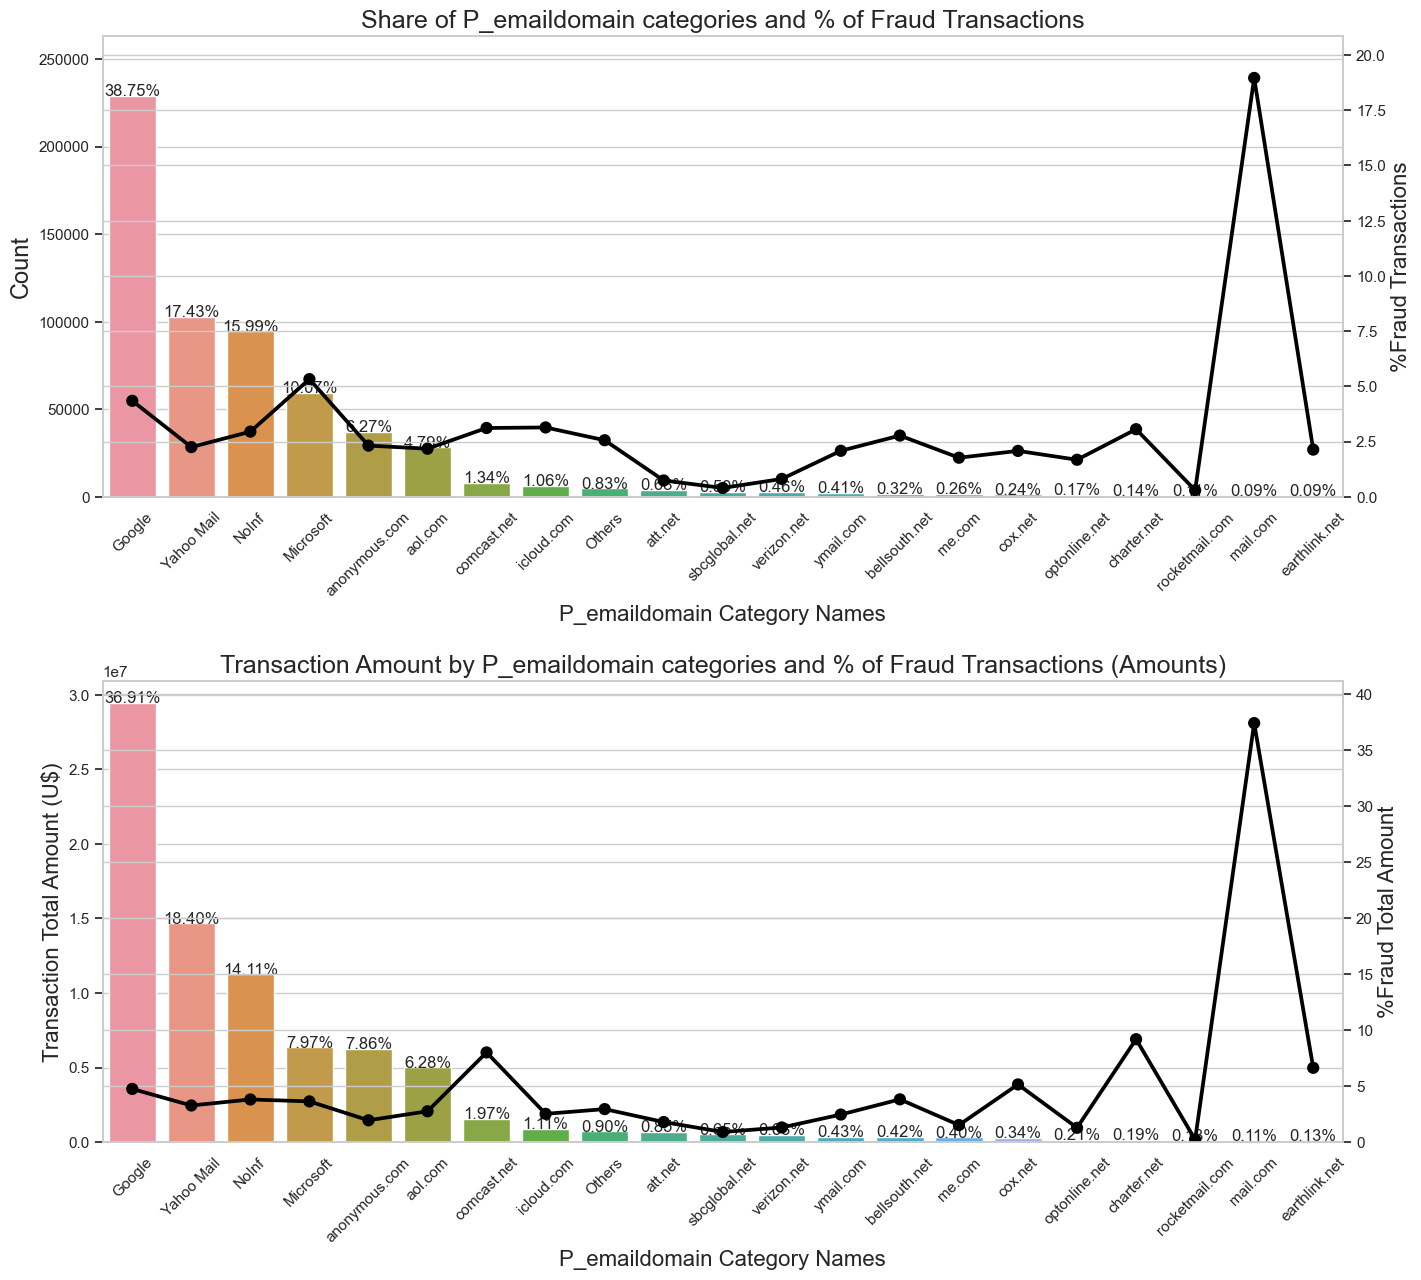

In [42]:
plot_cat_with_amt(df, 'P_emaildomain')

In [43]:
df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
Google            0.043496
Microsoft         0.053298
NoInf             0.029538
Others            0.025646
Yahoo Mail        0.022544
anonymous.com     0.023217
aol.com           0.021811
att.net           0.007439
bellsouth.net     0.027763
charter.net       0.030637
comcast.net       0.031187
cox.net           0.020818
earthlink.net     0.021401
icloud.com        0.031434
mail.com          0.189624
me.com            0.017740
optonline.net     0.016815
rocketmail.com    0.003012
sbcglobal.net     0.004040
verizon.net       0.008133
ymail.com         0.020868
Name: isFraud, dtype: float64

- Majority of transactions are with P_emaildomain as Google, Microsoft and Yahoo Mail
- There isn't any information about P_emaildomain of around 16% transactions in terms of count and 14.11% in terms of amount
- Fraud transaction rate for Microsoft is high as compared to Google and Yahoo mail 
- Fraud transaction rate (amount) for Google is high as comapred to Microsoft and Yahoo mail

### R-Email Domain

In [44]:
df.loc[df['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df.loc[df['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df.loc[df['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df.loc[df.R_emaildomain.isin(df.R_emaildomain\
                                         .value_counts()[df.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df.R_emaildomain.fillna("NoInf", inplace=True)

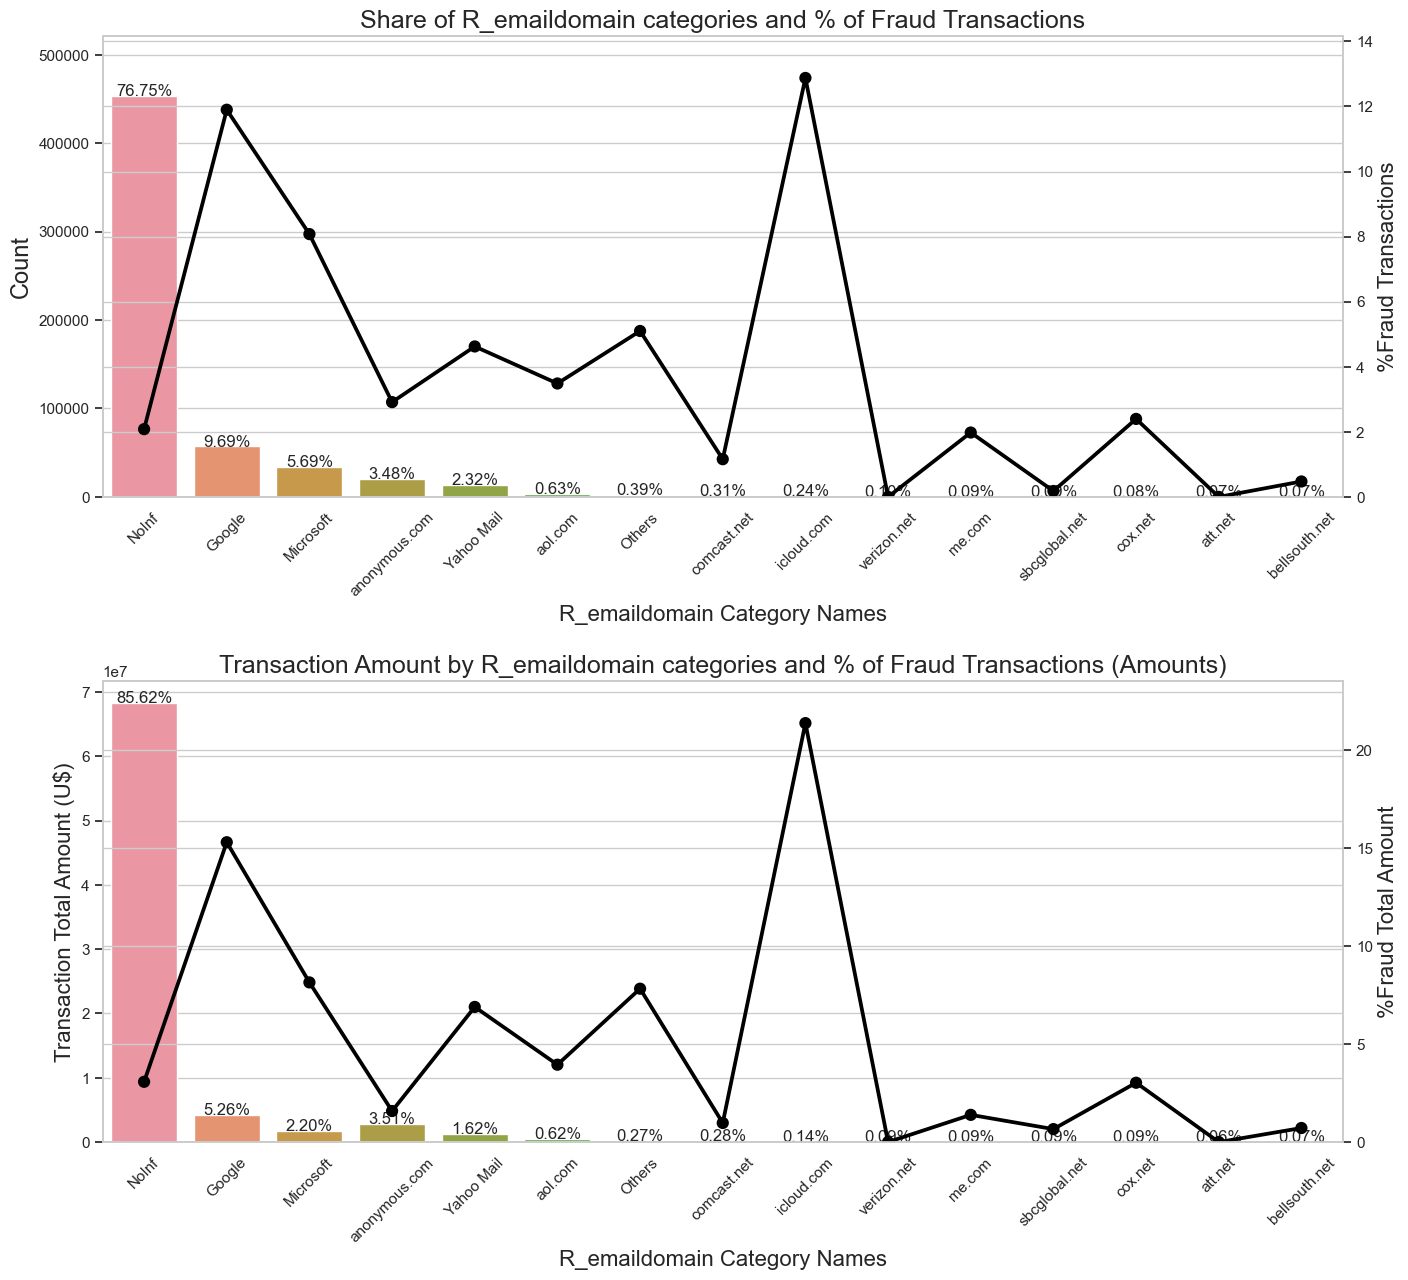

In [45]:
plot_cat_with_amt(df, 'R_emaildomain')

In [46]:
df.groupby('R_emaildomain')['isFraud'].mean()

R_emaildomain
Google           0.118986
Microsoft        0.080764
NoInf            0.020819
Others           0.050989
Yahoo Mail       0.046235
anonymous.com    0.029130
aol.com          0.034855
att.net          0.000000
bellsouth.net    0.004739
comcast.net      0.011589
cox.net          0.023965
icloud.com       0.128755
me.com           0.019784
sbcglobal.net    0.001812
verizon.net      0.000000
Name: isFraud, dtype: float64

- There isn't any information about R_emaildomain for Majority of transactions (76.75% count , 85.62% amount)
- Fraud transaction rate for Google is high as compared to Yahoo, anaonymous.com and Microsoft

###  Days of the Month

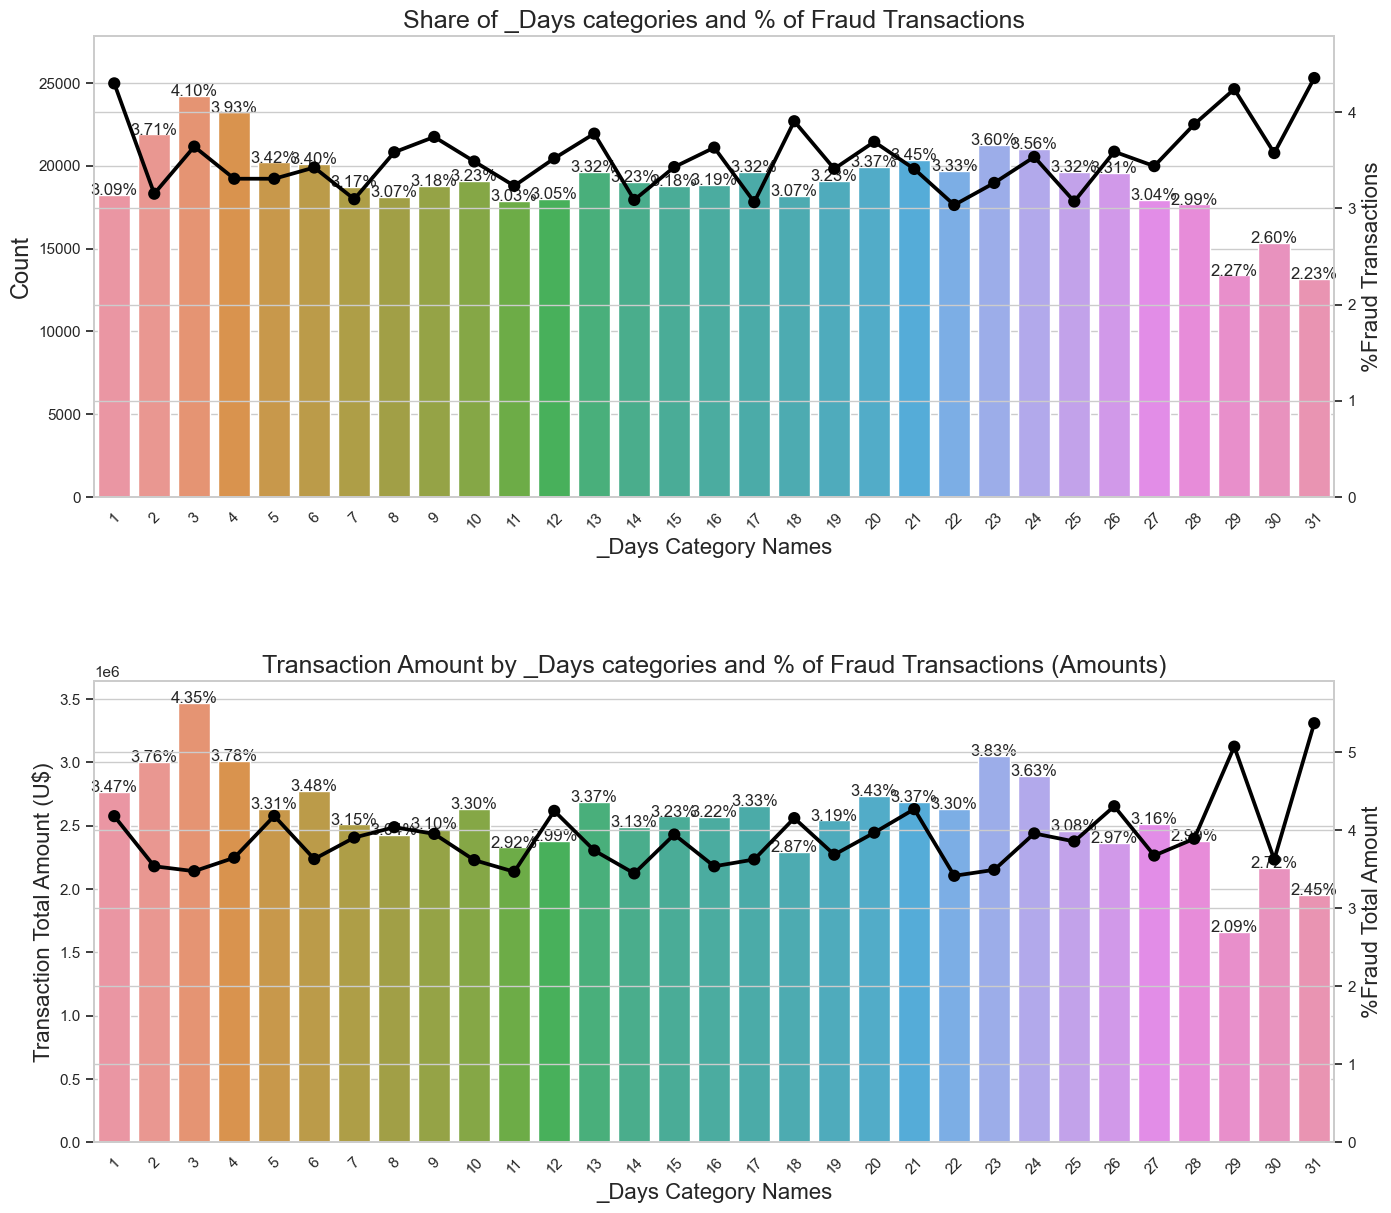

In [47]:
plot_cat_with_amt(df, '_Days')

- The perc of fraud transactions is highest towards the beginning and the end of the month. Might be accelerated at the time of receiving pay-checks.

- Incidentally, fraud transaction rate is high on the days when number of transactions are less

- Day 29,30 and 31 are having less transactions, looks like people are cautious with spending in those times.

### Days of the week

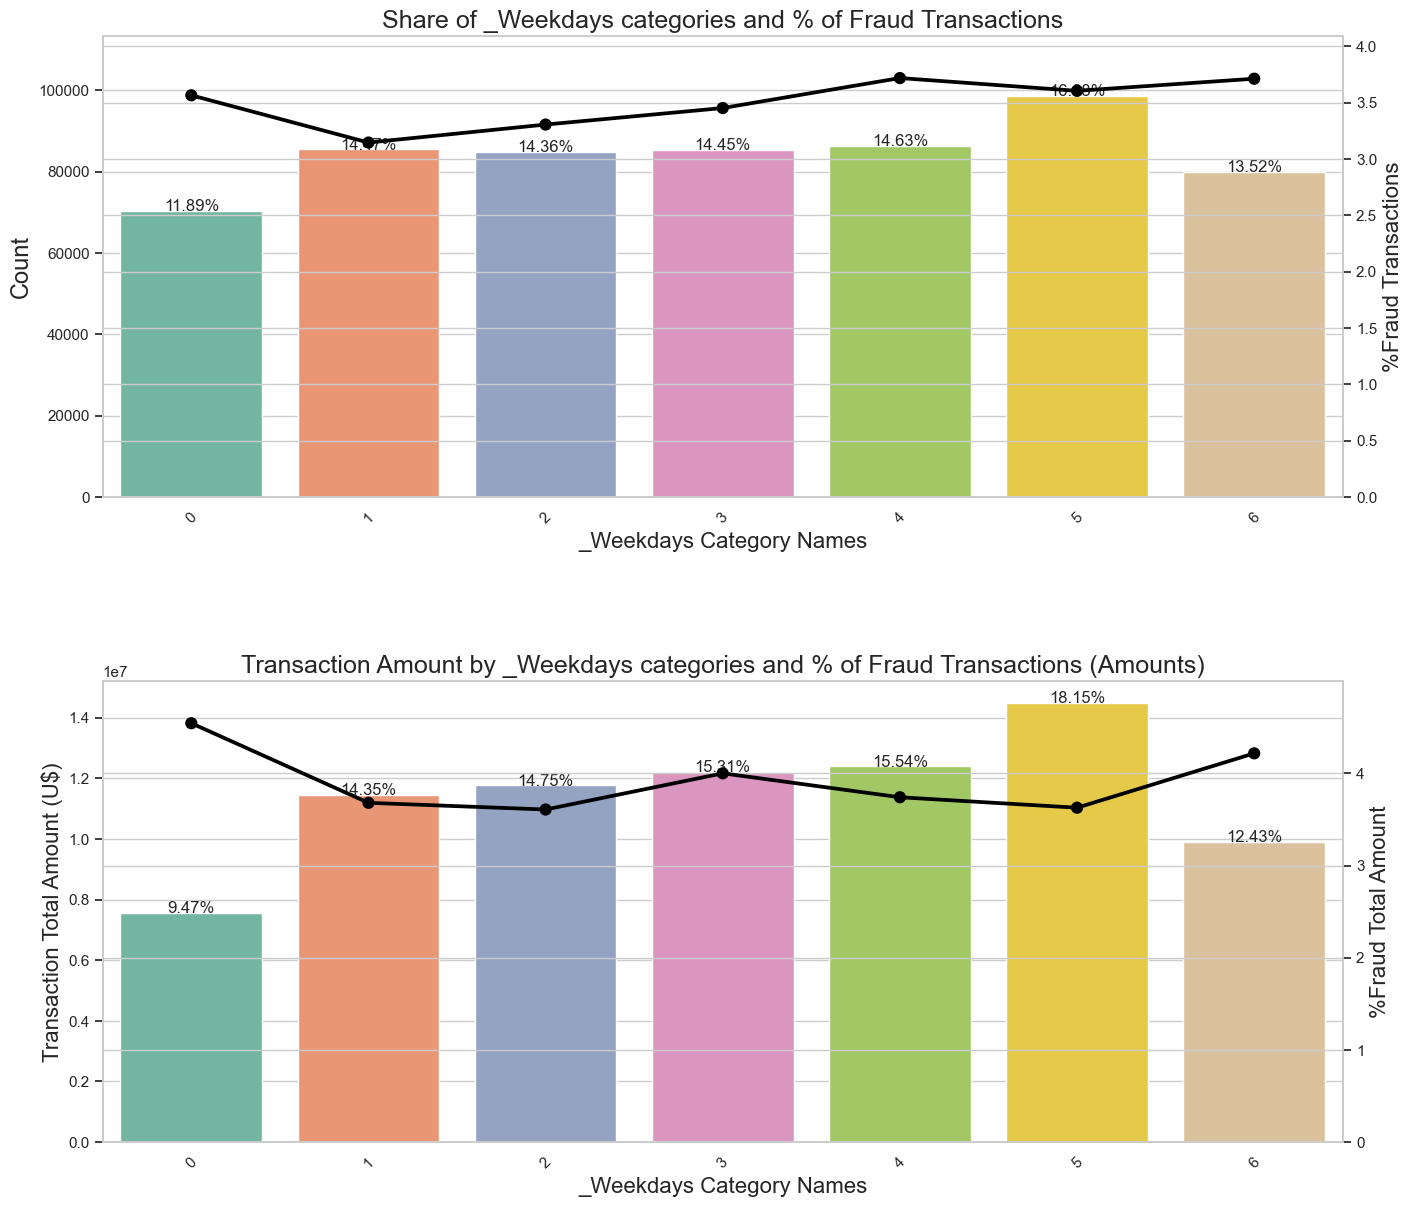

In [48]:
plot_cat_with_amt(df, '_Weekdays')

- Surprisingly fraud transaction rate is high on the days when number of transactions and transaction amounts are less. Day 0 and 6
- Day 0 and 6 have less transactions, these might be weekend days

### Hour of the Day

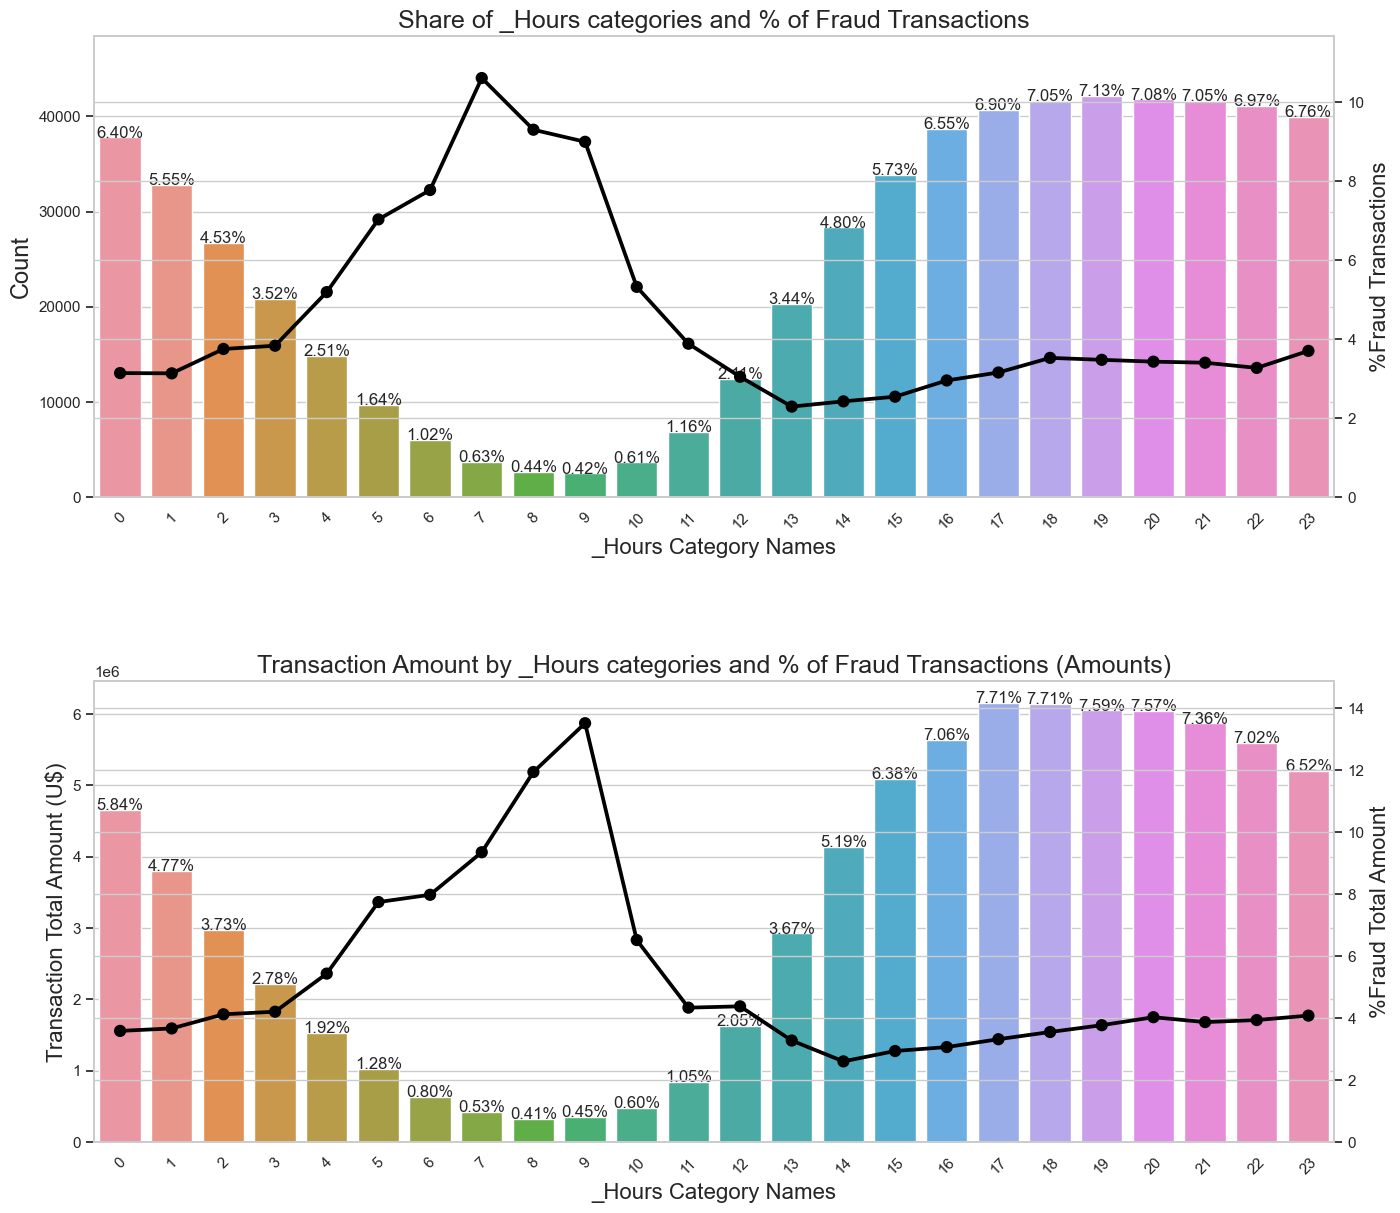

In [49]:
plot_cat_with_amt(df, '_Hours')

### Columns from identity data

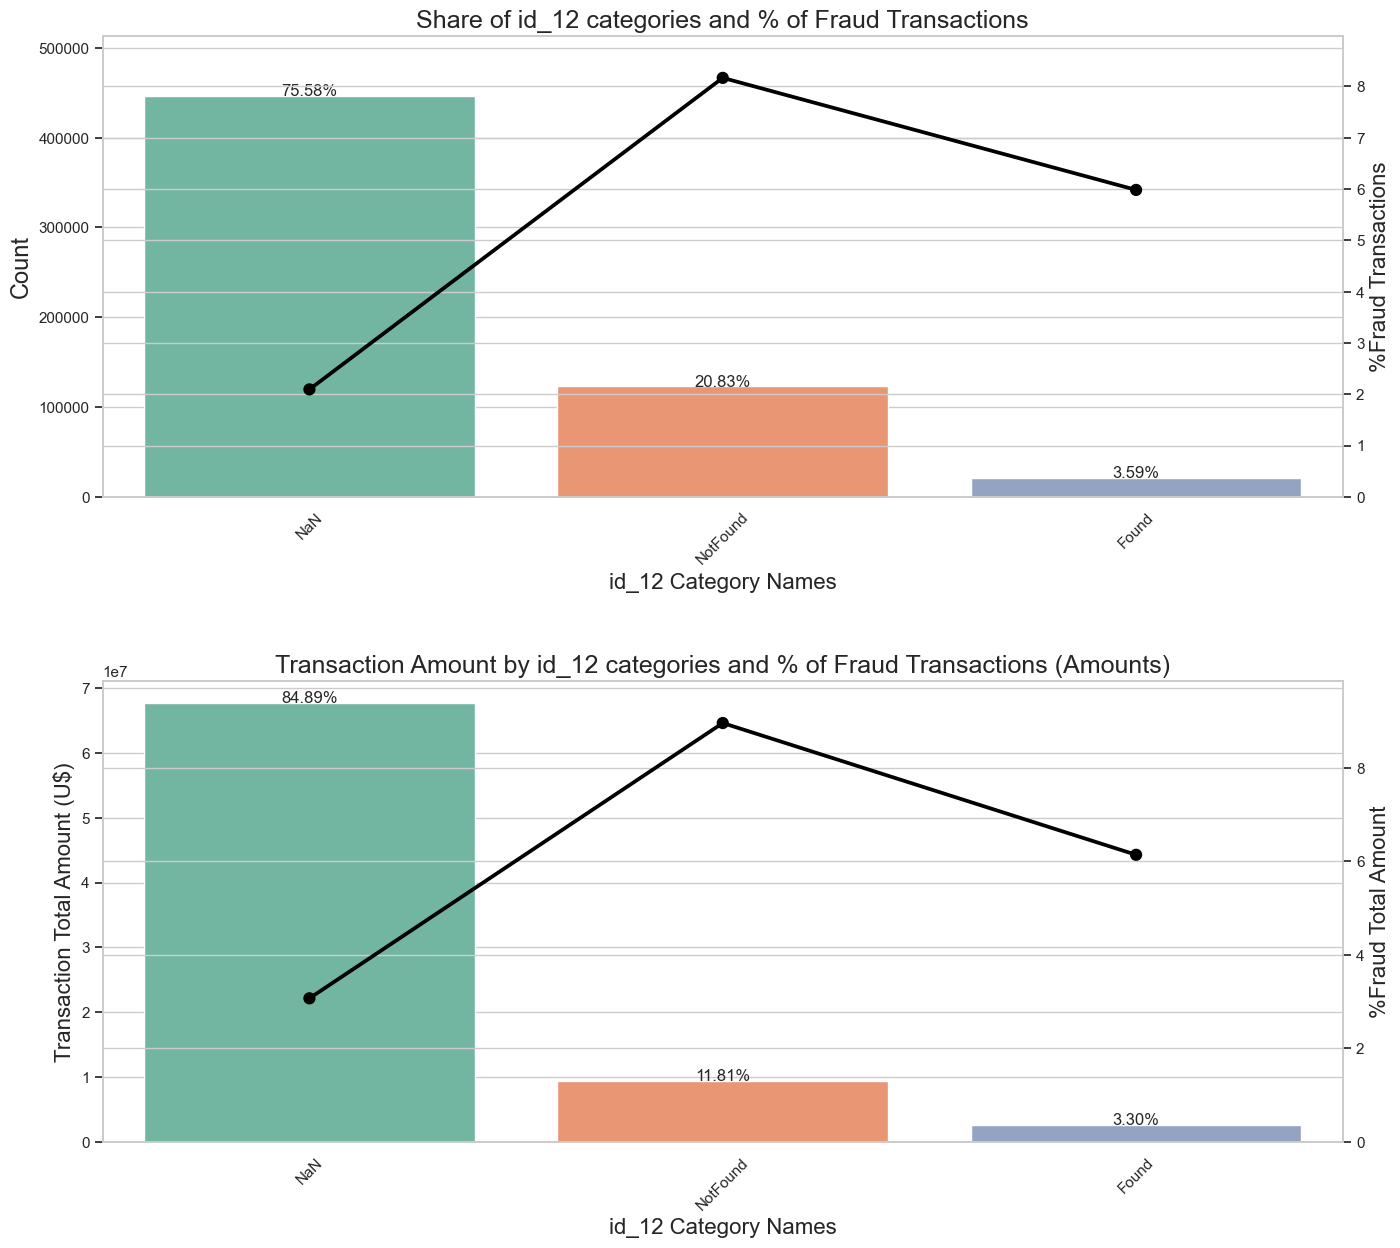

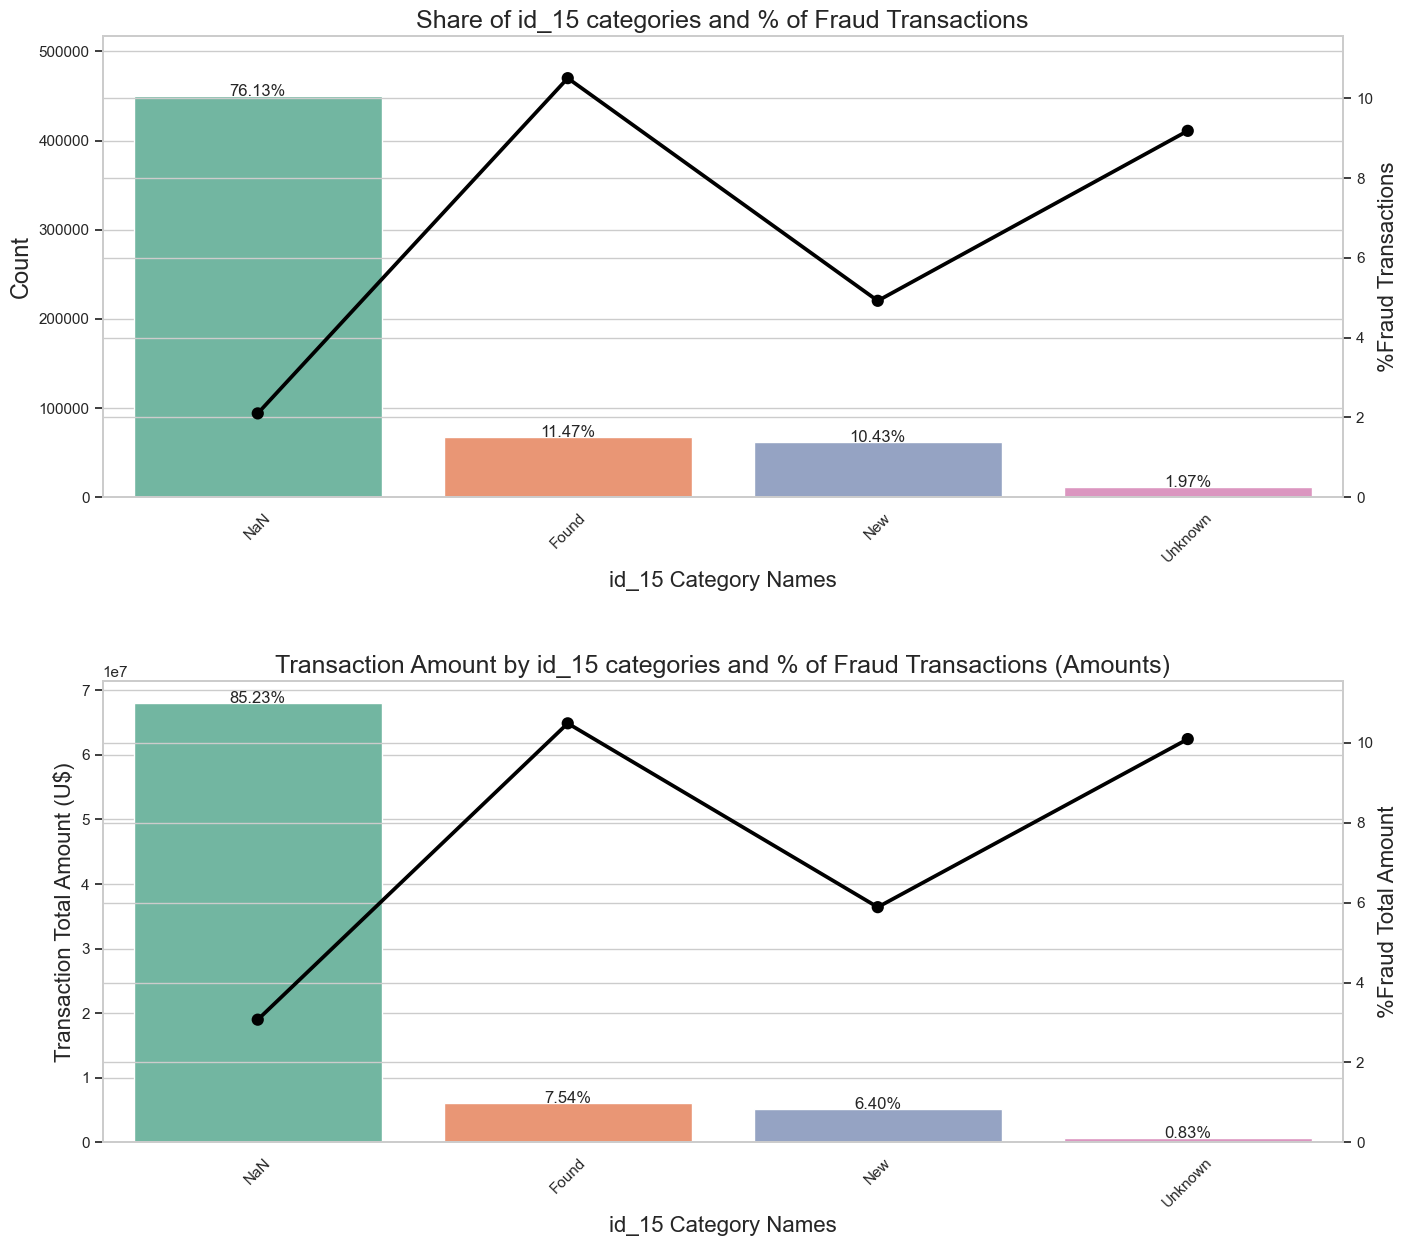

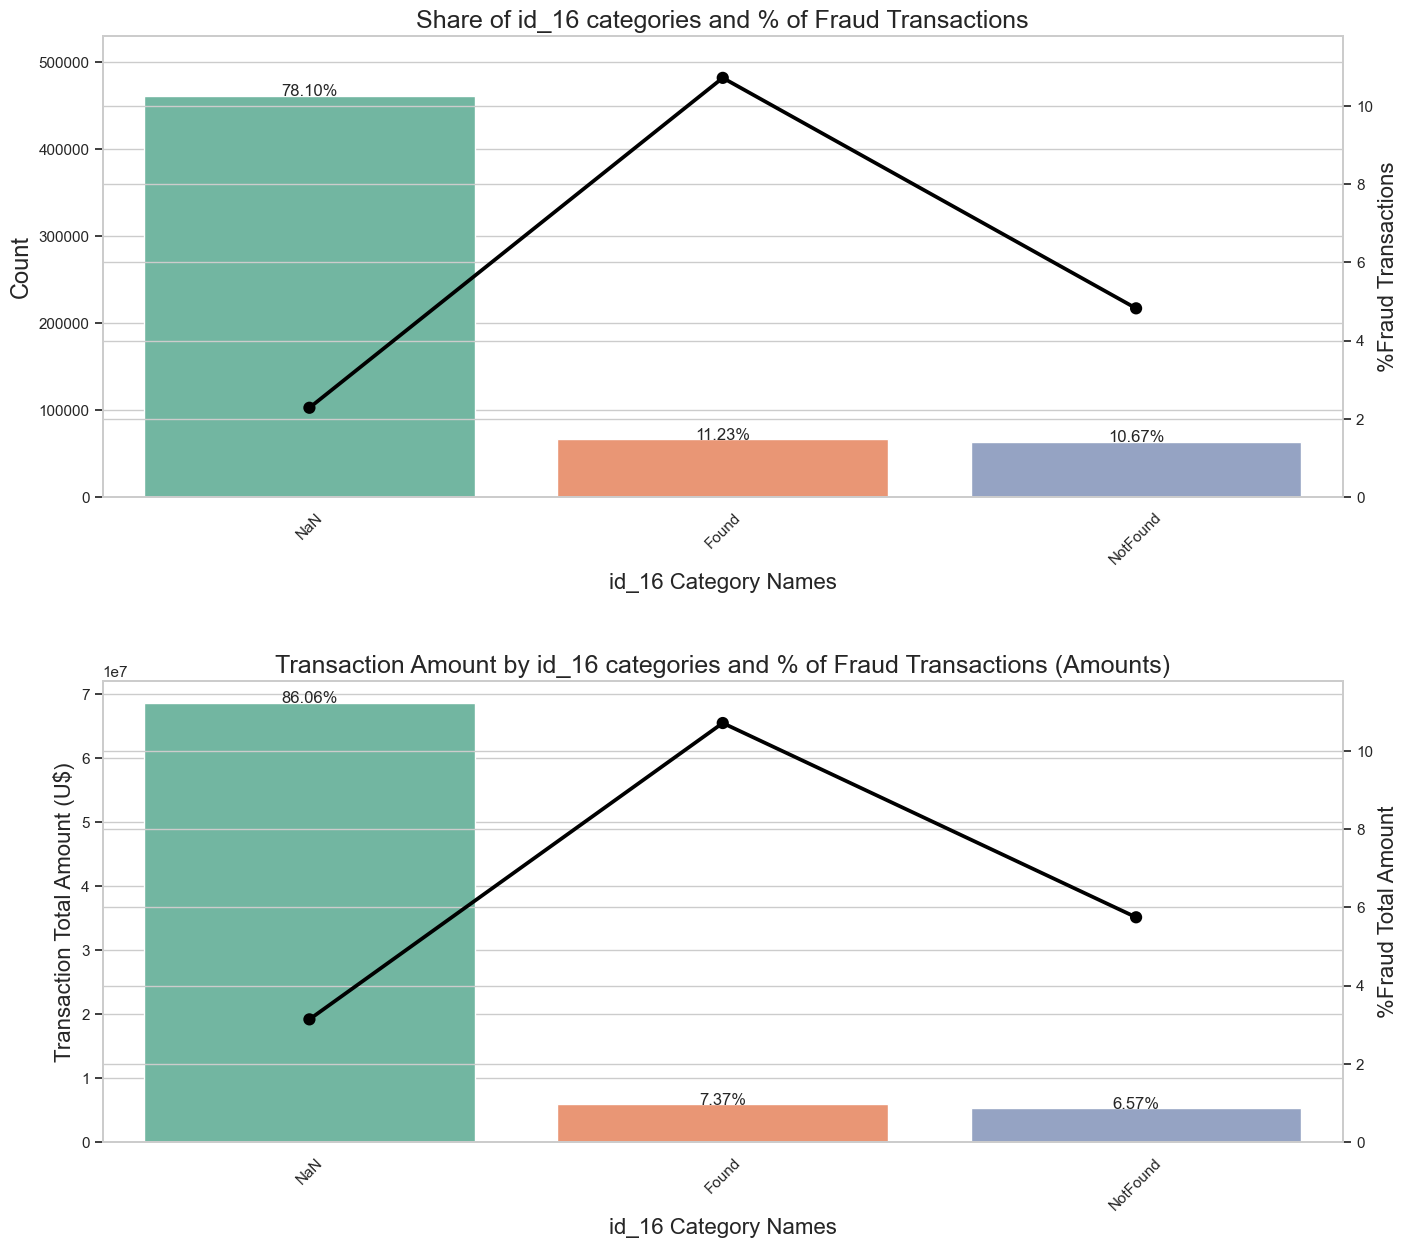

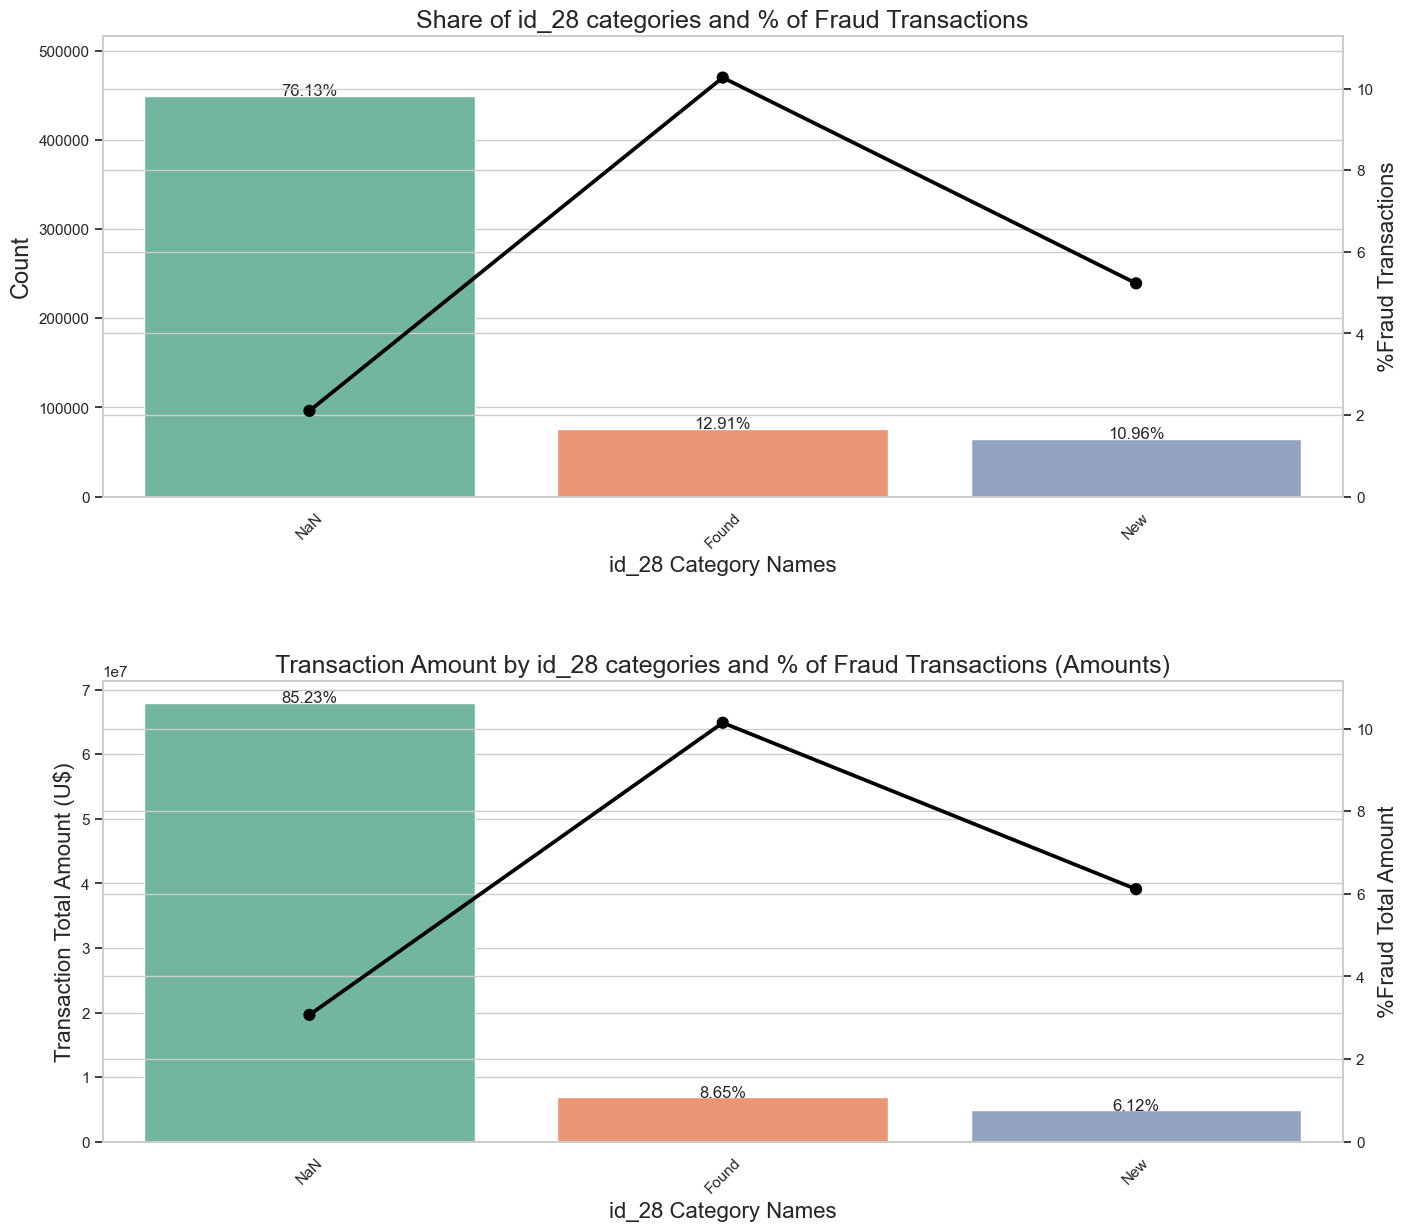

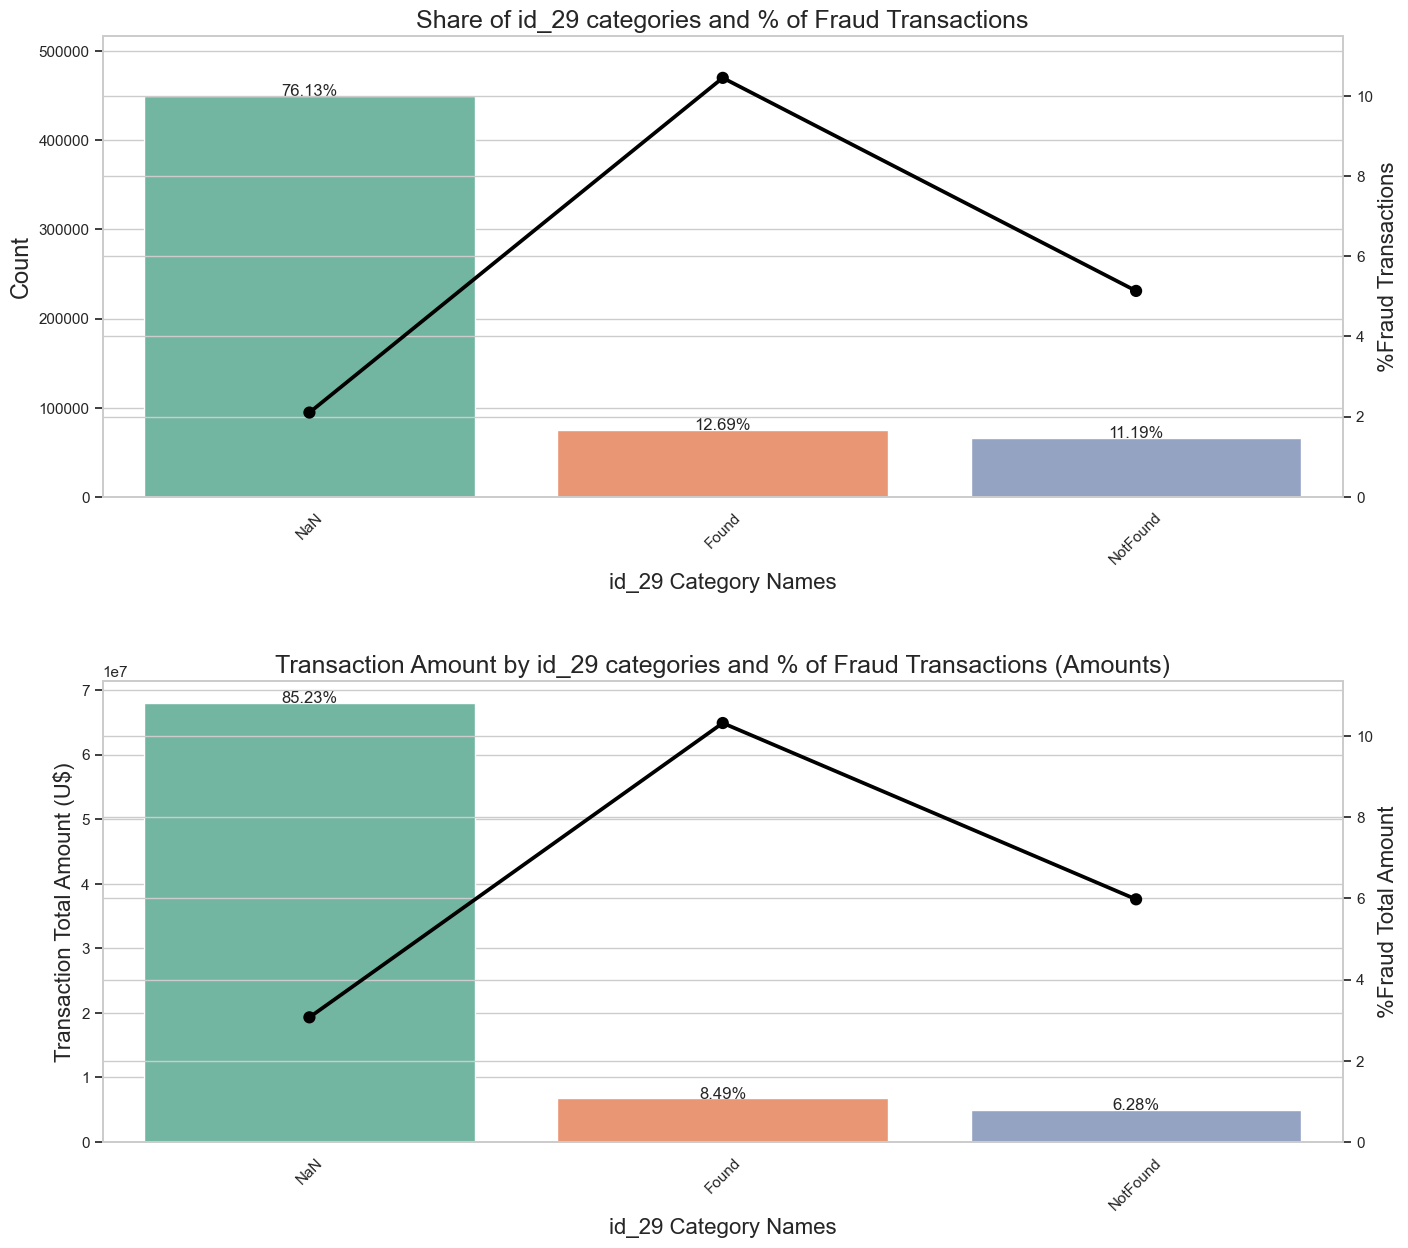

In [50]:
for col in ['id_12', 'id_15', 'id_16', 'id_28', 'id_29']:
    df[col] = df[col].fillna('NaN')
    plot_cat_with_amt(df, col)

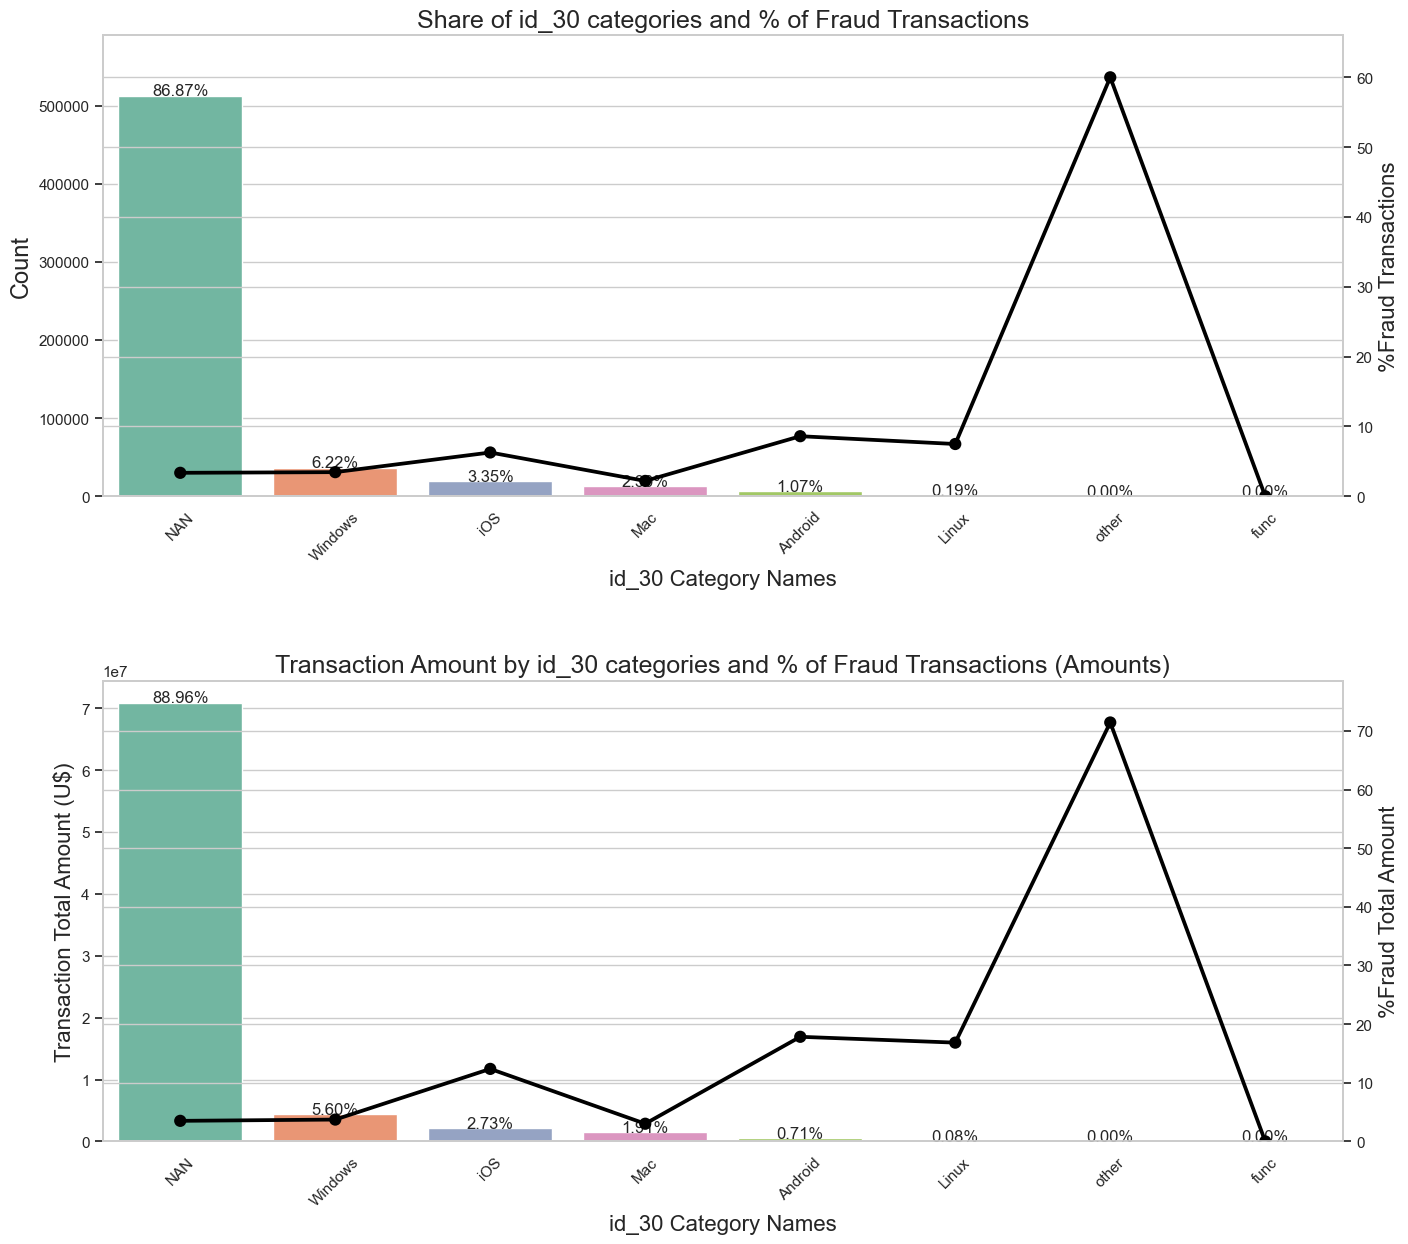

In [51]:
df.loc[df['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df.loc[df['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df.loc[df['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df.loc[df['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df['id_30'].fillna("NAN", inplace=True)
plot_cat_with_amt(df, "id_30")

In [52]:
cat_columns = df.select_dtypes(include=['object']).columns
len(cat_columns)

29

In [53]:
binary_columns = [col for col in df.columns if df[col].nunique() == 2]
len(binary_columns)

435

In [54]:
num_columns = [col for col in df.columns if (col not in cat_columns) & (col not in binary_columns)]
len(num_columns)

389

In [55]:
cat_columns = cat_columns.to_list() + binary_columns

# 7. Feature Engineering

In [56]:
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1 P_emaildomain  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0         NoInf   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN        Google   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0     Microsoft   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    Yahoo Mail   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN        Google   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
1         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
3         NoInf  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
4         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

    C13  C14     D1     D2    D3    D4   D5  D6  D8  D9   D10    D11  D12  \
0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN  13.0   13.0  NaN   
1   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0    NaN  NaN   
2   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0  315.0  NaN   
3  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN  84.0    NaN  NaN   
4   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN   NaN    NaN  NaN   

   D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8   M9   V1   V2  \
0  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN  NaN  1.0  1.0   
1  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  315.0    T    T    T   M0    F    F    F    F    F  1.0  1.0   
3  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  \
0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  \
0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
2  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
3  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  \
0  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0

### Domain Specific Features

In [57]:
df['Trans_min_mean'] = df['TransactionAmt'] - np.nanmean(df['TransactionAmt'],dtype="float64")
df['Trans_min_std']  = df['Trans_min_mean'] / np.nanstd(df['TransactionAmt'].astype("float64"),dtype="float64")

In [58]:
df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_std_card1']  = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
df['TransactionAmt_to_std_card4']  = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')

In [59]:
df['TransactionAmt'] = np.log(df['TransactionAmt'])

In [60]:
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400        4.226834         W  13926   
1        2987001        0          86401        3.367296         W   2755   
2        2987002        0          86469        4.077537         W   4663   
3        2987003        0          86499        3.912023         W  18132   
4        2987004        0          86506        3.912023         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1 P_emaildomain  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0         NoInf   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN        Google   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0     Microsoft   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    Yahoo Mail   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN        Google   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
1         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
3         NoInf  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
4         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

    C13  C14     D1     D2    D3    D4   D5  D6  D8  D9   D10    D11  D12  \
0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN  13.0   13.0  NaN   
1   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0    NaN  NaN   
2   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0  315.0  NaN   
3  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN  84.0    NaN  NaN   
4   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN   NaN    NaN  NaN   

   D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8   M9   V1   V2  \
0  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN  NaN  1.0  1.0   
1  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  315.0    T    T    T   M0    F    F    F    F    F  1.0  1.0   
3  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  \
0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  \
0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
2  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
3  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  \
0  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0

# 8. Dimensionality Reduction - PCA

In [61]:
def perform_PCA(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    return df

In [62]:
# Columns starting from V1 to V339
filter_col = df.columns[53:392]

Impute missing values in the mas_v columns, later use minmax_scale function to scale the values in these columns

In [63]:
from   sklearn.preprocessing import minmax_scale

# Fill na values and scale V columns
for col in filter_col:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))

# Perform PCA    
df = perform_PCA(df, filter_col, prefix='PCA_V_', n_components=30)

In [64]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1170.85 Mb (4.4% reduction)


In [65]:
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400        4.226562         W  13926   
1        2987001        0          86401        3.367188         W   2755   
2        2987002        0          86469        4.078125         W   4663   
3        2987003        0          86499        3.912109         W  18132   
4        2987004        0          86506        3.912109         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1 P_emaildomain  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0         NoInf   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN        Google   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0     Microsoft   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    Yahoo Mail   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN        Google   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
1         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
3         NoInf  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
4         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

    C13  C14     D1     D2    D3    D4   D5  D6  D8  D9   D10    D11  D12  \
0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN  13.0   13.0  NaN   
1   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0    NaN  NaN   
2   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0  315.0  NaN   
3  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN  84.0    NaN  NaN   
4   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN   NaN    NaN  NaN   

   D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8   M9  id_01  \
0  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN  NaN    NaN   
1  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN    NaN   
2  NaN  NaN  315.0    T    T    T   M0    F    F    F    F    F    NaN   
3  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN    NaN   
4  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0.0   

     id_02  id_03  id_04  id_05  id_06  id_09  id_10  id_11     id_12  id_13  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
1      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
4  70787.0    NaN    NaN    NaN    NaN    NaN    NaN  100.0  NotFound    NaN   

   id_14 id_15     id_16  id_17  id_19  id_20 id_28     id_29    id_30  \
0    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
1    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
2    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
3    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
4 -480.0   New  NotFound  166.0  542.0  144.0   New  NotFound  Android   

                 id_31  id_32      id_33           id_34 id_35 id_36 id_37  \
0                  NaN    NaN        NaN             NaN   NaN   NaN   NaN   
1                  NaN    NaN        NaN             NaN   NaN   NaN   NaN   
2                  NaN    NaN        NaN             NaN   NaN   NaN   NaN   
3                  NaN    NaN        NaN             NaN   NaN   NaN   NaN   
4  samsung browser 6.2   32.0  2220x1080  match_status:2     T     F     T   

  id_38 DeviceType                     DeviceInfo  card2_missing_flag  \
0   NaN        NaN                            NaN                   1   
1   NaN        NaN                            NaN                   0   
2   NaN        NaN                            NaN       

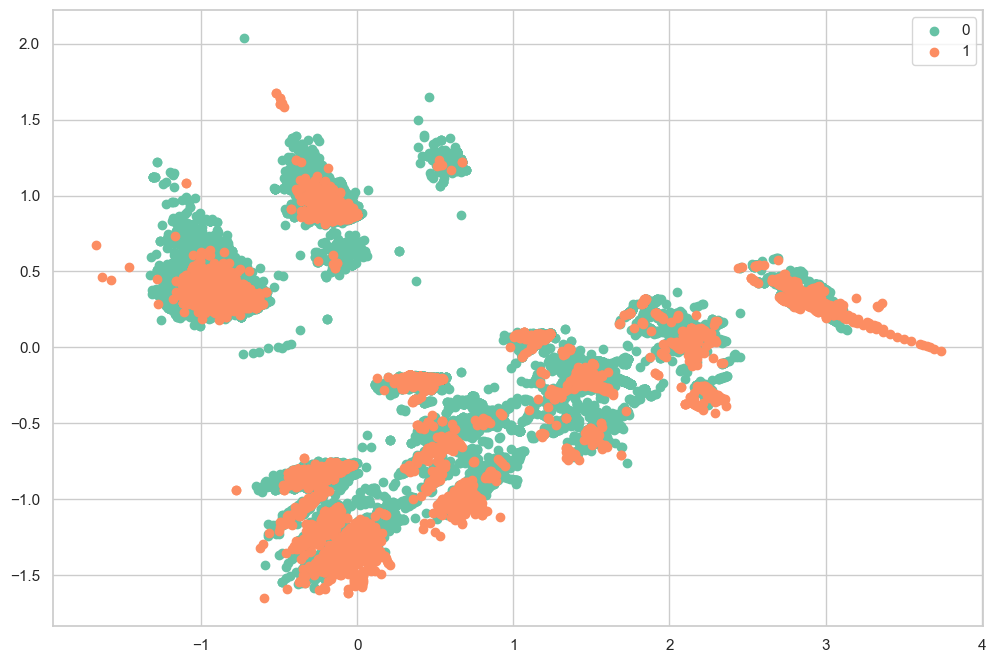

In [66]:
# Plot first 2 PCA features and colour by target variable
plt.figure(figsize=(12, 8));
groups = df.groupby("isFraud")
for name, group in groups:
    plt.scatter(group["PCA_V_0"], group["PCA_V_1"], label=name)
plt.legend()
plt.show()

# 9. Feature Encoding

In [67]:
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

In [68]:
binary_cols = [col for col in df.columns if df[col].dropna().nunique() ==2 and col not in cat_cols]

In [69]:
num_cols = [col for col in df.select_dtypes(include=['int64','int32','int16','int8','float64','float32','float16']).columns if col not in binary_cols]

In [70]:
len(cat_cols)

29

In [71]:
len(binary_cols)

415

In [72]:
len(num_cols)

92

In [73]:
cat_cols = cat_cols + binary_cols
len(cat_cols)

444

In [74]:
# Frequecny encoding variables
frequency_encoded_variables = []
for col in cat_cols:
    if df[col].nunique() > 30:
        print(col, df[col].nunique())
        frequency_encoded_variables.append(col)

id_31 130
id_33 260
DeviceInfo 1786


In [75]:
for variable in tqdm(frequency_encoded_variables):
    # group by frequency 
    fq = df.groupby(variable).size()/len(df)    
    # mapping values to dataframe 
    df.loc[:, "{}".format(variable)] = df[variable].map(fq)   
    cat_columns.remove(variable)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.37it/s]


In [76]:
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400        4.226562         W  13926   
1        2987001        0          86401        3.367188         W   2755   
2        2987002        0          86469        4.078125         W   4663   
3        2987003        0          86499        3.912109         W  18132   
4        2987004        0          86506        3.912109         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1 P_emaildomain  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0         NoInf   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN        Google   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0     Microsoft   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    Yahoo Mail   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN        Google   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
1         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
3         NoInf  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
4         NoInf  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

    C13  C14     D1     D2    D3    D4   D5  D6  D8  D9   D10    D11  D12  \
0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN  13.0   13.0  NaN   
1   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0    NaN  NaN   
2   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0  315.0  NaN   
3  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN  84.0    NaN  NaN   
4   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN   NaN    NaN  NaN   

   D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8   M9  id_01  \
0  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN  NaN    NaN   
1  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN    NaN   
2  NaN  NaN  315.0    T    T    T   M0    F    F    F    F    F    NaN   
3  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN    NaN   
4  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0.0   

     id_02  id_03  id_04  id_05  id_06  id_09  id_10  id_11     id_12  id_13  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
1      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN   
4  70787.0    NaN    NaN    NaN    NaN    NaN    NaN  100.0  NotFound    NaN   

   id_14 id_15     id_16  id_17  id_19  id_20 id_28     id_29    id_30  \
0    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
1    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
2    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
3    NaN   NaN       NaN    NaN    NaN    NaN   NaN       NaN      NAN   
4 -480.0   New  NotFound  166.0  542.0  144.0   New  NotFound  Android   

      id_31  id_32     id_33           id_34 id_35 id_36 id_37 id_38  \
0       NaN    NaN       NaN             NaN   NaN   NaN   NaN   NaN   
1       NaN    NaN       NaN             NaN   NaN   NaN   NaN   NaN   
2       NaN    NaN       NaN             NaN   NaN   NaN   NaN   NaN   
3       NaN    NaN       NaN             NaN   NaN   NaN   NaN   NaN   
4  0.001797   32.0  0.000921  match_status:2     T     F     T     T   

  DeviceType  DeviceInfo  card2_missing_flag  card3_missing_flag  \
0        NaN         NaN                   1                   0   
1        NaN         NaN                   0                   0   
2        NaN         NaN                   0                   0   
3        NaN         NaN               

In [77]:
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(df[col].values))
    df[col] = lbl.transform(list(df[col].values))

In [78]:
df = reduce_mem_usage(df)

Mem. usage decreased to 384.45 Mb (81.5% reduction)


# 10. Data Preprocessing for Model Building

In [79]:
df.loc[:, 'isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [80]:
df = df.drop(['TransactionID','TransactionDT','Date'], axis=1)

In [81]:
X = df.drop(['isFraud'],axis=1)
y = df.isFraud.astype(bool)

del df

gc.collect()

0

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0,stratify=y)

In [83]:
X_train.head()

TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  \
448539        4.679688          4   6598  111.0  150.0      2  195.0      2   
321311        4.355469          4  12839  321.0  150.0      4  226.0      2   
497320        3.892578          4  14649  548.0  150.0      4  226.0      2   
350951        4.058594          4   6489  295.0  150.0      4  226.0      2   
98132         5.296875          2   5714  170.0  150.0      4  195.0      1   

        addr1  addr2  dist1  P_emaildomain  R_emaildomain     C1     C2   C3  \
448539  264.0   87.0    6.0              0              2    2.0    4.0  0.0   
321311  264.0   87.0    0.0              0              2    1.0    1.0  0.0   
497320  441.0   87.0   86.0              4              2    2.0    4.0  0.0   
350951  184.0   87.0    NaN              0              2  154.0  148.0  0.0   
98132   498.0   87.0    NaN              5              6    1.0    1.0  0.0   

         C4     C5     C6   C7   C8    C9  C10    C11  C12    C13    C14  \
448539  0.0    1.0    1.0  0.0  0.0   1.0  0.0    2.0  0.0    7.0    2.0   
321311  0.0    2.0    1.0  0.0  0.0   1.0  0.0    1.0  0.0   12.0    1.0   
497320  0.0    0.0    2.0  0.0  0.0   3.0  0.0    4.0  0.0   45.0    2.0   
350951  0.0  108.0  101.0  0.0  0.0  92.0  0.0  107.0  0.0  504.0  129.0   
98132   1.0    0.0    1.0  0.0  1.0   0.0  1.0    1.0  0.0    1.0    1.0   

           D1     D2    D3     D4    D5  D6        D8        D9    D10   D11  \
448539   64.0   64.0  18.0   63.0  10.0 NaN       NaN       NaN   63.0  35.0   
321311  114.0  114.0  14.0  115.0  14.0 NaN       NaN       NaN  115.0  45.0   
497320   85.0   85.0   3.0  329.0   3.0 NaN       NaN       NaN  329.0  85.0   
350951  577.0  577.0  54.0   54.0  54.0 NaN       NaN       NaN  577.0   NaN   
98132     0.0    NaN   NaN    NaN   NaN NaN  7.917969  0.916504    NaN   NaN   

        D12  D13  D14    D15  M1  M2  M3  M4  M5  M6  M7  M8  M9  id_01  \
448539  NaN  NaN  NaN   63.0   1   1   1   3   2   0   0   1   1    NaN   
321311  NaN  NaN  NaN  115.0   1   1   1   3   2   1   1   1   1    NaN   
497320  NaN  NaN  NaN   85.0   1   1   1   0   0   0   0   0   0    NaN   
350951  NaN  NaN  NaN  110.0   2   2   2   3   2   0   2   2   2    NaN   
98132   NaN  NaN  NaN    NaN   2   2   2   3   2   2   2   2   2   -5.0   

           id_02  id_03  id_04  id_05  id_06  id_09  id_10  id_11  id_12  \
448539       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      1   
321311       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      1   
497320       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      1   
350951       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      1   
98132   105681.0    0.0    0.0    2.0    0.0    0.0    0.0  100.0      2   

        id_13  id_14  id_15  id_16  id_17  id_19  id_20  id_28  id_29  id_30  \
448539    NaN    NaN      1      1    NaN    NaN    NaN      1      1      3   
321311    NaN    NaN      1      1    NaN    NaN    NaN      1      1      3   
497320    NaN    NaN      1      1    NaN    NaN    NaN      1      1      3   
350951    NaN    NaN      1      1    NaN    NaN    NaN      1      1      3   
98132    52.0 -360.0      0      0  166.0  621.0  272.0      0      0      4   

        id_31  id_32  id_33  id_34  id_35  id_36  id_37  id_38  DeviceType  \
448539    103    NaN     74      4      2      2      2      2           2   
321311    103    NaN     74      4      2      2      2      2           2   
497320    103    NaN     74      4      2      2      2      2           2   
350951    103    NaN     74      4      2      2      2      2           2   
98132      84   24.0     72      3      1      0      1      1           0   

        DeviceInfo  card2_missing_flag  card3_missing_flag  \
448539         141                   0                   0   
321311         141                   0                   0   
497320         141                   0                   0   
350951  

### Missing values imputation

In [84]:
from sklearn.impute import SimpleImputer

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

imputer = SimpleImputer(strategy='median')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [85]:
X_train.head()

TransactionAmt  ProductCD    card1  card2  card3  card4  card5  card6  \
0        4.679688        4.0   6598.0  111.0  150.0    2.0  195.0    2.0   
1        4.355469        4.0  12839.0  321.0  150.0    4.0  226.0    2.0   
2        3.892578        4.0  14649.0  548.0  150.0    4.0  226.0    2.0   
3        4.058594        4.0   6489.0  295.0  150.0    4.0  226.0    2.0   
4        5.296875        2.0   5714.0  170.0  150.0    4.0  195.0    1.0   

   addr1  addr2  dist1  P_emaildomain  R_emaildomain     C1     C2   C3   C4  \
0  264.0   87.0    6.0            0.0            2.0    2.0    4.0  0.0  0.0   
1  264.0   87.0    0.0            0.0            2.0    1.0    1.0  0.0  0.0   
2  441.0   87.0   86.0            4.0            2.0    2.0    4.0  0.0  0.0   
3  184.0   87.0    8.0            0.0            2.0  154.0  148.0  0.0  0.0   
4  498.0   87.0    8.0            5.0            6.0    1.0    1.0  0.0  1.0   

      C5     C6   C7   C8    C9  C10    C11  C12    C13    C14     D1     D2  \
0    1.0    1.0  0.0  0.0   1.0  0.0    2.0  0.0    7.0    2.0   64.0   64.0   
1    2.0    1.0  0.0  0.0   1.0  0.0    1.0  0.0   12.0    1.0  114.0  114.0   
2    0.0    2.0  0.0  0.0   3.0  0.0    4.0  0.0   45.0    2.0   85.0   85.0   
3  108.0  101.0  0.0  0.0  92.0  0.0  107.0  0.0  504.0  129.0  577.0  577.0   
4    0.0    1.0  0.0  1.0   0.0  1.0    1.0  0.0    1.0    1.0    0.0   97.0   

     D3     D4    D5   D6         D8        D9    D10   D11  D12  D13  D14  \
0  18.0   63.0  10.0  0.0  37.843750  0.666504   63.0  35.0  0.0  0.0  0.0   
1  14.0  115.0  14.0  0.0  37.843750  0.666504  115.0  45.0  0.0  0.0  0.0   
2   3.0  329.0   3.0  0.0  37.843750  0.666504  329.0  85.0  0.0  0.0  0.0   
3  54.0   54.0  54.0  0.0  37.843750  0.666504  577.0  43.0  0.0  0.0  0.0   
4   8.0   26.0  10.0  0.0   7.917969  0.916504   15.0  43.0  0.0  0.0  0.0   

     D15   M1   M2   M3   M4   M5   M6   M7   M8   M9  id_01     id_02  id_03  \
0   63.0  1.0  1.0  1.0  3.0  2.0  0.0  0.0  1.0  1.0   -5.0  125673.0    0.0   
1  115.0  1.0  1.0  1.0  3.0  2.0  1.0  1.0  1.0  1.0   -5.0  125673.0    0.0   
2   85.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   -5.0  125673.0    0.0   
3  110.0  2.0  2.0  2.0  3.0  2.0  0.0  2.0  2.0  2.0   -5.0  125673.0    0.0   
4   52.0  2.0  2.0  2.0  3.0  2.0  2.0  2.0  2.0  2.0   -5.0  105681.0    0.0   

   id_04  id_05  id_06  id_09  id_10  id_11  id_12  id_13  id_14  id_15  \
0    0.0    0.0    0.0    0.0    0.0  100.0    1.0   52.0 -300.0    1.0   
1    0.0    0.0    0.0    0.0    0.0  100.0    1.0   52.0 -300.0    1.0   
2    0.0    0.0    0.0    0.0    0.0  100.0    1.0   52.0 -300.0    1.0   
3    0.0    0.0    0.0    0.0    0.0  100.0    1.0   52.0 -300.0    1.0   
4    0.0    2.0    0.0    0.0    0.0  100.0    2.0   52.0 -360.0    0.0   

   id_16  id_17  id_19  id_20  id_28  id_29  id_30  id_31  id_32  id_33  \
0    1.0  166.0  341.0  472.0    1.0    1.0    3.0  103.0   24.0   74.0   
1    1.0  166.0  341.0  472.0    1.0    1.0    3.0  103.0   24.0   74.0   
2    1.0  166.0  341.0  472.0    1.0    1.0    3.0  103.0   24.0   74.0   
3    1.0  166.0  341.0  472.0    1.0    1.0    3.0  103.0   24.0   74.0   
4    0.0  166.0  621.0  272.0    0.0    0.0    4.0   84.0   24.0   72.0   

   id_34  id_35  id_36  id_37  id_38  DeviceType  DeviceInfo  \
0    4.0    2.0    2.0    2.0    2.0         2.0       141.0   
1    4.0    2.0    2.0    2.0    2.0         2.0       141.0   
2    4.0    2.0    2.0    2.0    2.0         2.0       141.0   
3    4.0    2.0    2.0    2.0    2.0         2.0       141.0   
4    3.0    1.0    0.0    1.0    1.0         0.0       140.0   

   card2_missing_flag  card3_missing_flag  card4_missing_flag  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4               

In [86]:
print("Missing values in X_train:", X_train.isna().sum().sum())
print("Missing values in X_test:", X_test.isna().sum().sum())

Missing values in X_train: 0
Missing values in X_test: 0


# 11. Baseline Model Training and Evaluation

## A) Logistic Regression (Baseline)

In [87]:
from sklearn.linear_model import LogisticRegression

In [89]:
lr_model = LogisticRegression(random_state = 42)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [90]:
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

In [92]:
print("Y predicted : ",y_pred_lr)
print("Y probability predicted : ",y_prob_lr[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.04297033 0.05604277 0.0450106  0.04926824 0.02802123]


## Evaluation Metrics

- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

In [93]:
from bisect import bisect_left, bisect_right

def concordance(actuals, preds):
    ones_preds  = [p for a,p in zip(actuals, preds) if a == 1]
    zeros_preds = [p for a,p in zip(actuals, preds) if a == 0]
    n_ones      = len([x for x in actuals if x == 1])
    n_total_pairs =  float(n_ones) * float(len(actuals) - n_ones)
    # print("Total Pairs: ", n_total_pairs)

    zeros_sorted = sorted(zeros_preds)

    conc = 0; disc = 0; ties = 0;
    for i, one_pred in enumerate(ones_preds):
        cur_conc = bisect_left(zeros_sorted, one_pred)
        cur_ties = bisect_right(zeros_sorted, one_pred) - cur_conc
        conc += cur_conc
        ties += cur_ties
        disc += float(len(zeros_sorted)) - cur_ties - cur_conc

    concordance = conc/n_total_pairs
    discordance = disc/n_total_pairs
    ties_perc = ties/n_total_pairs
    return concordance

In [94]:
def compute_evaluation_metric(model, x_test, y_actual, y_predicted, y_predicted_prob):
    print("\nAccuracy Score : ", accuracy_score(y_actual, y_predicted))
    print("\nAUC Score : ", roc_auc_score(y_actual, y_predicted_prob))
    print("\nConfusion Matrix : \n", confusion_matrix(y_actual, y_predicted))
    print("\nClassification Report : \n", classification_report(y_actual, y_predicted))
    
    # Concordance index if function exists
    try:
        print("\nConcordance Index : ", concordance(y_actual, y_predicted_prob))
    except:
        print("\nConcordance Index : Function 'concordance' not defined")
    
    # ROC curve
    print("\nROC curve : \n")
    plot_roc_curve(model, x_test, y_actual)
    plt.show() 

    # PR curve
    print("\nPR curve : \n")
    plot_precision_recall_curve(model, x_test, y_actual)
    plt.show()

    # --- Compute TPR, FPR, TNR, FNR ---
    tn, fp, fn, tp = confusion_matrix(y_actual, y_predicted).ravel()
    
    tpr = tp / (tp + fn)  # True Positive Rate / Recall
    fpr = fp / (fp + tn)  # False Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate / Specificity
    fnr = fn / (fn + tp)  # False Negative Rate

    print("\nAdditional Metrics:")
    print(f"TPR (Recall) : {tpr:.4f}")
    print(f"FPR : {fpr:.4f}")
    print(f"TNR (Specificity) : {tnr:.4f}")
    print(f"FNR : {fnr:.4f}")

In [95]:
concordance(y_test.values, y_prob_lr)

0.6991978645110632


Accuracy Score :  0.9649981372980662

AUC Score :  0.6991978645110632

Confusion Matrix : 
 [[170960      3]
 [  6198      1]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.97      1.00      0.98    170963
        True       0.25      0.00      0.00      6199

    accuracy                           0.96    177162
   macro avg       0.61      0.50      0.49    177162
weighted avg       0.94      0.96      0.95    177162


Concordance Index :  0.6991978645110632

ROC curve : 



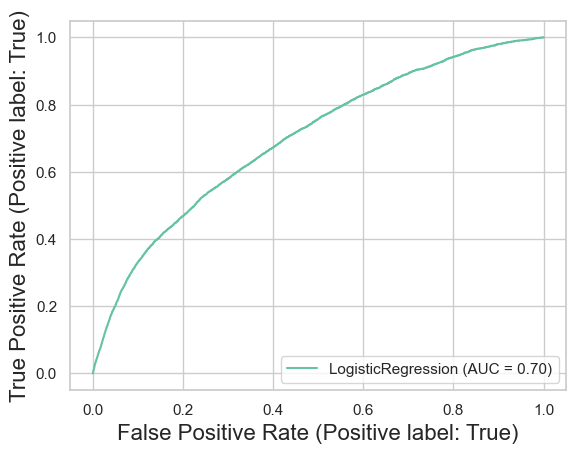


PR curve : 



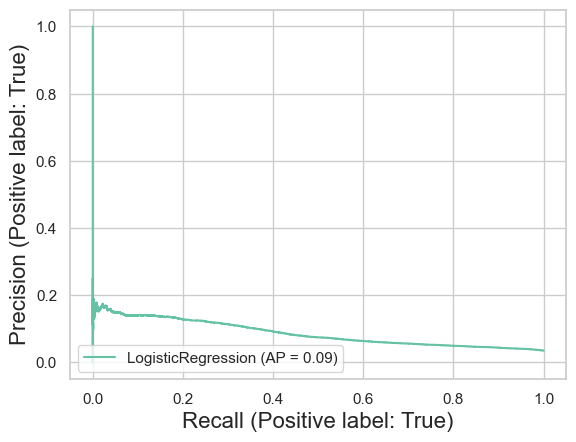


Additional Metrics:
TPR (Recall) : 0.0002
FPR : 0.0000
TNR (Specificity) : 1.0000
FNR : 0.9998


In [96]:
compute_evaluation_metric(lr_model, X_test, y_test, y_pred_lr, y_prob_lr)

## Capture Rates and Calibration Curve

In [97]:
def captures(y_test, y_pred, y_pred_prob):
    # Create Validation set
    validation_df = {'y_test' : y_test, 'y_pred' : y_pred, 'y_pred_prob' : y_pred_prob}
    validation_df = pd.DataFrame(data = validation_df)

    # Add binning column to the dataframe
    try:
        validation_df['bin_y_pred_prob'] = pd.qcut(validation_df['y_pred_prob'], q=10)
    except:
        validation_df['bin_y_pred_prob'] = pd.qcut(validation_df['y_pred_prob'], q=10, duplicates='drop')
    
    # Change x label and column names
    x_label = []
    for i in range(len(validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str'))):
        x_label.append("Bin" + str(i + 1)+ "(" + validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str')[i] + ")")
    
    # Plot Distribution of predicted probabilities for every bin
    plt.figure(figsize=(12, 8));
    sns.stripplot(validation_df.bin_y_pred_prob, validation_df.y_pred_prob, jitter = 0.15, hue = validation_df.y_test, order = validation_df['bin_y_pred_prob'].cat.categories[::-1])
    plt.title("Distribution of predicted probabilities for every bin", fontsize=18)
    plt.xlabel("Predicted Probability Bins", fontsize=14);
    plt.ylabel("Predicted Probability", fontsize=14);
    try:
        plt.xticks(np.arange(10), x_label, rotation=45);
    except:
        pass
    plt.show()
    
    # Aggregate the data
    gains_df             = validation_df.groupby(["bin_y_pred_prob","y_test"]).agg({'y_test': ['count']})
    gains_df.columns     = gains_df.columns.map(''.join)
    gains_df['prob_bin'] = gains_df.index.get_level_values(0)
    gains_df['y_test']   = gains_df.index.get_level_values(1)
    gains_df.reset_index(drop = True, inplace = True)
    gains_df

    # Get infection rate and percentage infections
    gains_table = gains_df.pivot(index='prob_bin', columns='y_test', values='y_testcount')
    gains_table['prob_bin'] = gains_table.index
    gains_table = gains_table.iloc[::-1]
    gains_table['prob_bin'] = x_label
    gains_table.reset_index(drop = True, inplace = True)
    gains_table = gains_table[['prob_bin', 0, 1]]
    gains_table.columns = ['prob_bin', "not_fraud", "fraud"]
    gains_table['perc_fraud'] = gains_table['fraud']/gains_table['fraud'].sum()
    gains_table['perc_not_fraud'] = gains_table['not_fraud']/gains_table['not_fraud'].sum()
    gains_table['cum_perc_fraud'] = 100*(gains_table.fraud.cumsum() / gains_table.fraud.sum()) 
    gains_table['cum_perc_not_fraud'] = 100*(gains_table.not_fraud.cumsum() / gains_table.not_fraud.sum()) 
    gains_table


    # Plot
    plt.figure(figsize=(12, 8));
    sns.set_style("white")
    sns.pointplot(x = "prob_bin", y = "cum_perc_fraud", data = gains_table, legend = False, order=gains_table.prob_bin)
    plt.xticks(rotation=45);
    plt.ylabel("Fraud Rate", fontsize=14)
    plt.xlabel("Prediction probability bin", fontsize=14)
    plt.title("Fraud rate for every bin", fontsize=18)
    plt.show()
    return gains_table

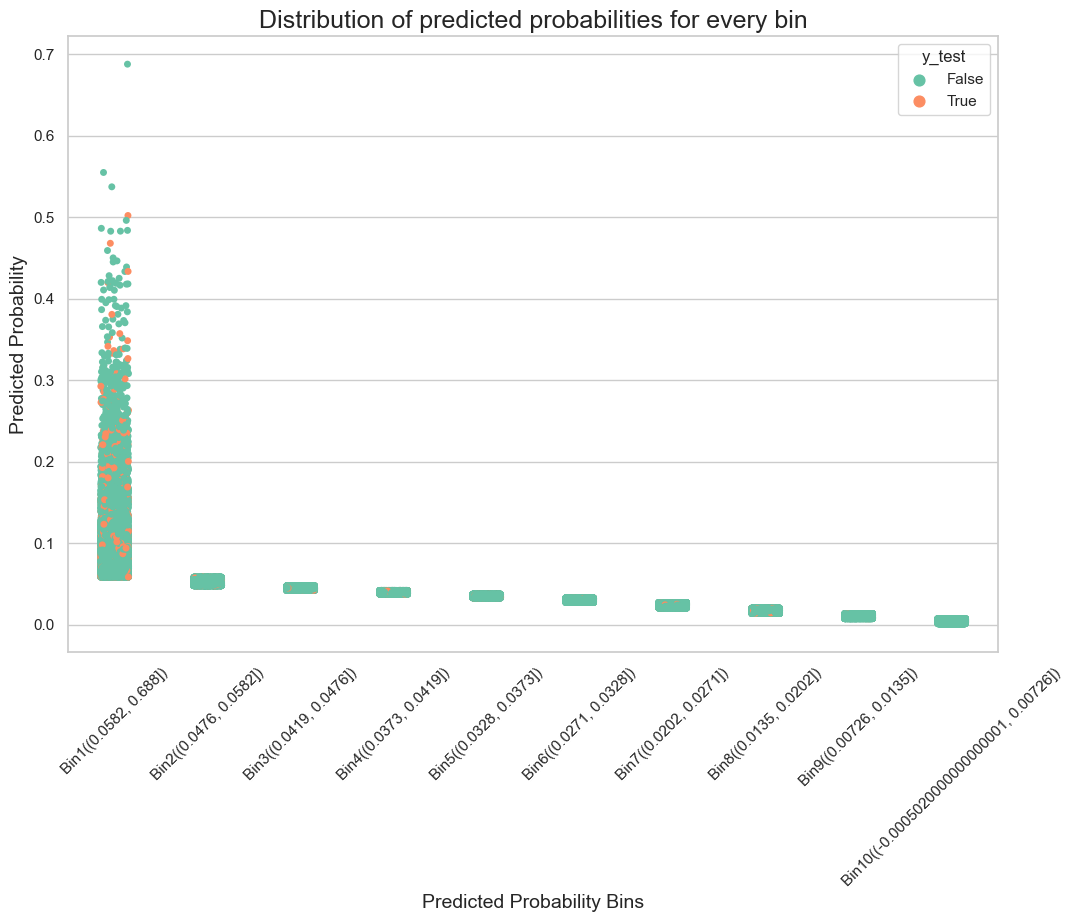

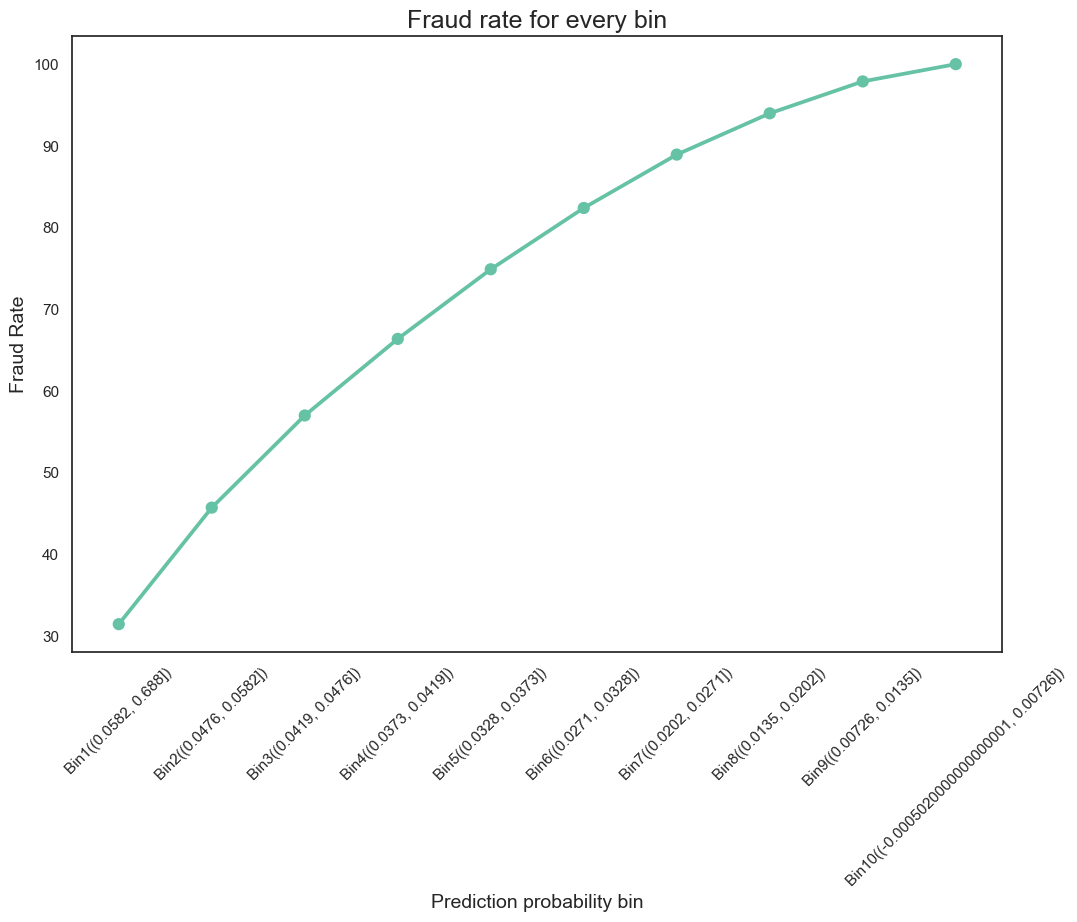

prob_bin  not_fraud  fraud  perc_fraud  \
0                     Bin1((0.0582, 0.688])      15766   1951    0.314728   
1                    Bin2((0.0476, 0.0582])      16832    884    0.142604   
2                    Bin3((0.0419, 0.0476])      17017    699    0.112760   
3                    Bin4((0.0373, 0.0419])      17135    581    0.093725   
4                    Bin5((0.0328, 0.0373])      17188    528    0.085175   
5                    Bin6((0.0271, 0.0328])      17251    465    0.075012   
6                    Bin7((0.0202, 0.0271])      17311    405    0.065333   
7                    Bin8((0.0135, 0.0202])      17403    313    0.050492   
8                   Bin9((0.00726, 0.0135])      17474    242    0.039039   
9  Bin10((-0.0005020000000000001, 0.00726])      17586    131    0.021132   

   perc_not_fraud  cum_perc_fraud  cum_perc_not_fraud  
0        0.092219       31.472818            9.221878  
1        0.098454       45.733183           19.067284  
2        0.099536       57.009195           29.020899  
3        0.100226       66.381674           39.043536  
4        0.100536       74.899177           49.097173  
5        0.100905       82.400387           59.187660  
6        0.101256       88.933699           69.313243  
7        0.101794       93.982900           79.492639  
8        0.102209       97.886756           89.713564  
9        0.102864      100.000000          100.000000

In [98]:
captures(y_test, y_pred_lr, y_prob_lr)

## Calibration Curve

In [99]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [100]:
def draw_calibration_curve(y_test, y_prob, n_bins=10):
    plt.figure(figsize=(7, 7), dpi=120)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ("Model", ))
    ax2.hist(y_prob, range=(0, 1), bins=10, label="Model", histtype="step", lw=2)

    # Labels
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

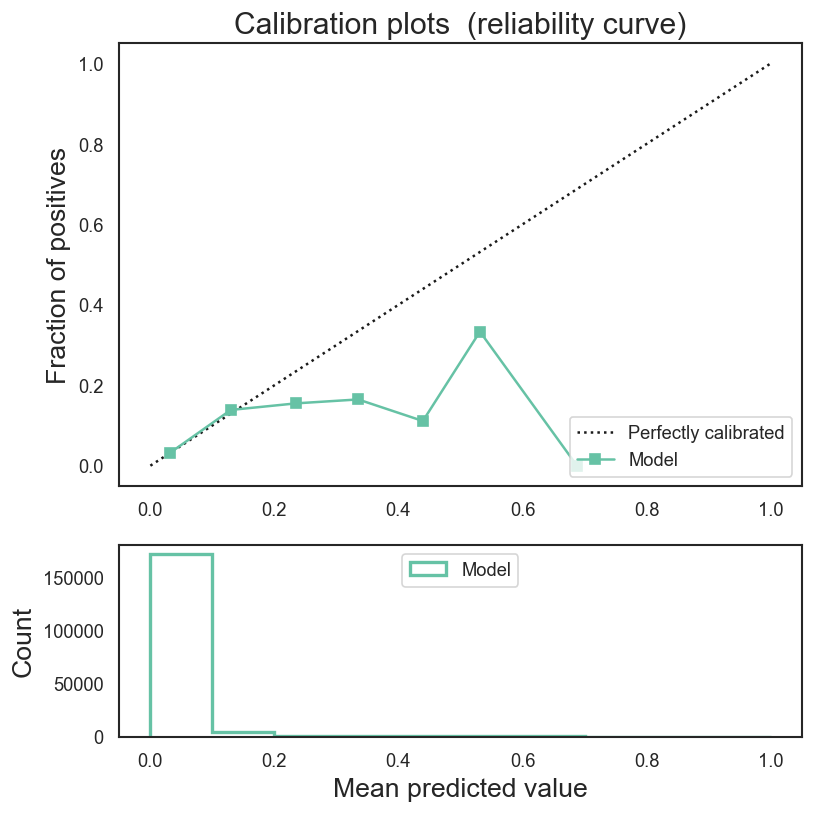

In [101]:
draw_calibration_curve(y_test, y_prob_lr, n_bins=10)

- The baseline Logistic Regression model performed relatively poorly, indicating that the underlying data relationships are likely non-linear and more complex. To capture these patterns effectively, we now move forward with advanced ensemble models such as XGBoost, LightGBM, and Random Forest Classifier, which are better suited for handling complex feature interactions and non-linear decision boundaries.

## B) XGBoost Classifier

In [103]:
%%time
xgb = XGBClassifier(nthread=-1, random_state=42)
xgb.fit(X_train, y_train)
xgb

[10:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7min 7s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, nthread=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [104]:
y_pred_xgb = xgb.predict(X_test)
y_prob_pred_xgb = xgb.predict_proba(X_test)[:, 1]
print("Y predicted : ",y_pred_xgb)
print("Y probability predicted : ",y_prob_pred_xgb[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.00321961 0.00406783 0.00780371 0.0231334  0.00243639]


In [105]:
concordance(y_test.values, y_prob_pred_xgb)

0.9363753273299149


Accuracy Score :  0.9801086011672933

AUC Score :  0.9363753419553209

Confusion Matrix : 
 [[170646    317]
 [  3207   2992]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99    170963
        True       0.90      0.48      0.63      6199

    accuracy                           0.98    177162
   macro avg       0.94      0.74      0.81    177162
weighted avg       0.98      0.98      0.98    177162


Concordance Index :  0.9363753273299149

ROC curve : 



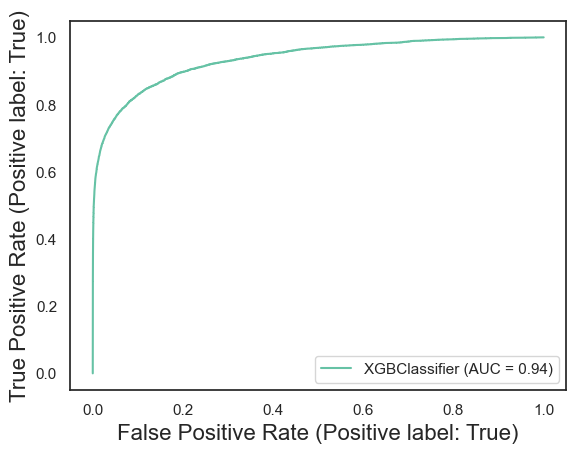


PR curve : 



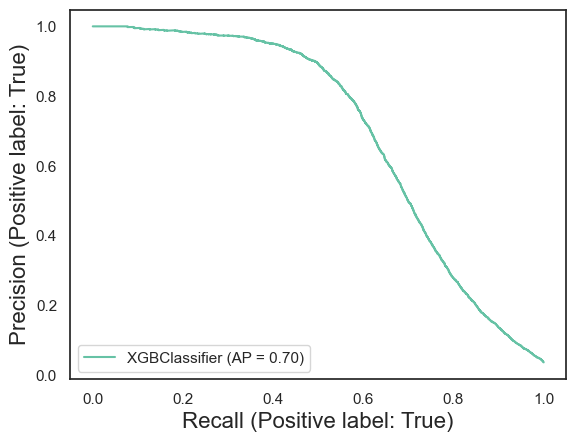


Additional Metrics:
TPR (Recall) : 0.4827
FPR : 0.0019
TNR (Specificity) : 0.9981
FNR : 0.5173


In [106]:
compute_evaluation_metric(xgb, X_test, y_test, y_pred_xgb, y_prob_pred_xgb)

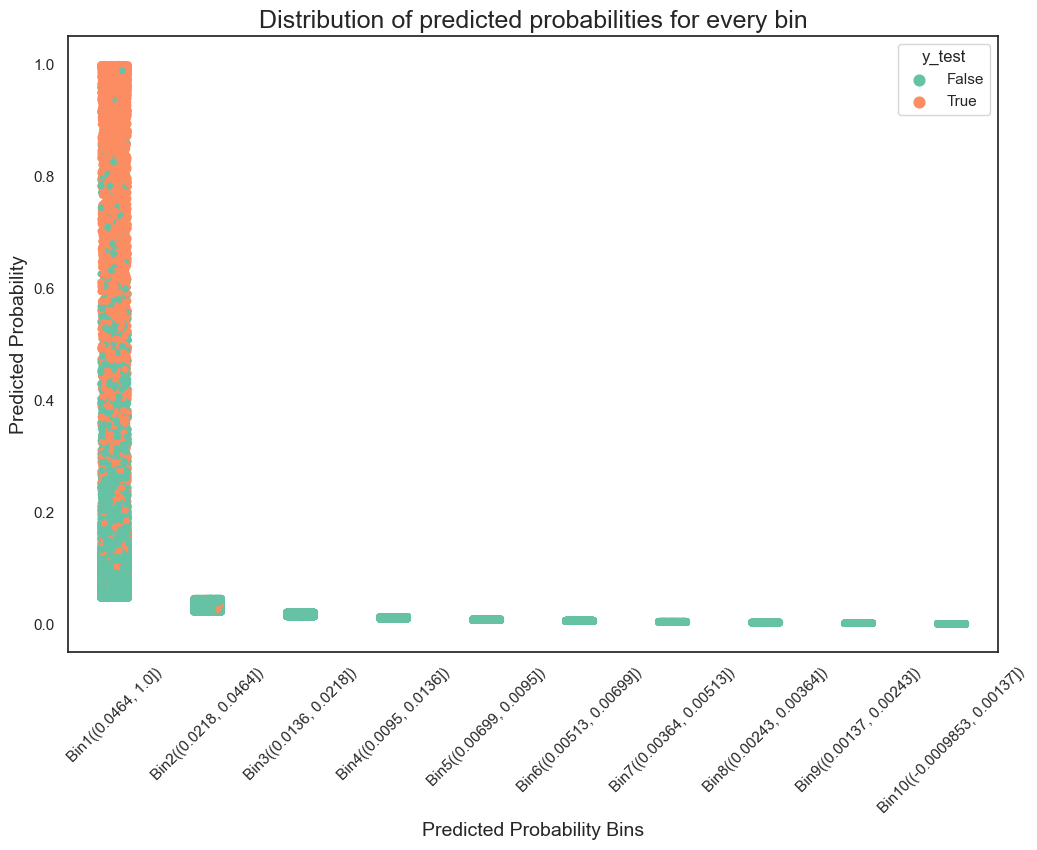

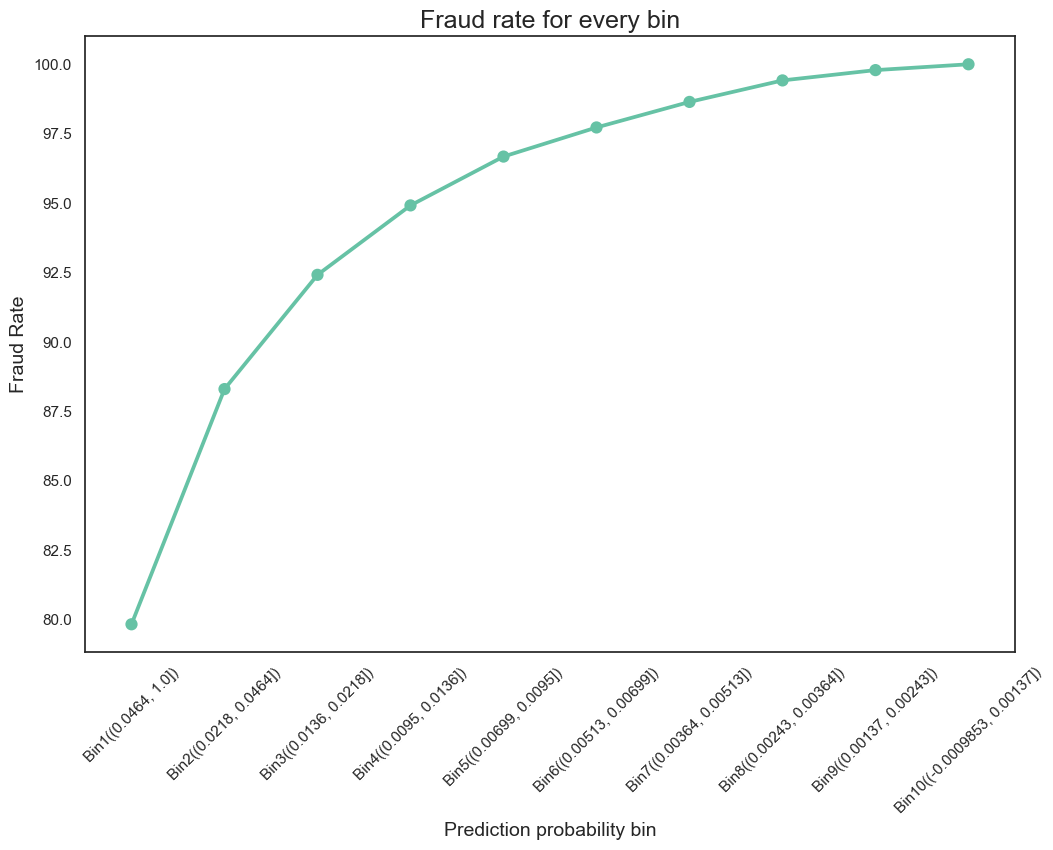

prob_bin  not_fraud  fraud  perc_fraud  perc_not_fraud  \
0           Bin1((0.0464, 1.0])      12768   4949    0.798355        0.074683   
1        Bin2((0.0218, 0.0464])      17191    525    0.084691        0.100554   
2        Bin3((0.0136, 0.0218])      17461    255    0.041136        0.102133   
3        Bin4((0.0095, 0.0136])      17561    155    0.025004        0.102718   
4       Bin5((0.00699, 0.0095])      17607    109    0.017583        0.102987   
5      Bin6((0.00513, 0.00699])      17651     65    0.010486        0.103245   
6      Bin7((0.00364, 0.00513])      17659     57    0.009195        0.103291   
7      Bin8((0.00243, 0.00364])      17668     48    0.007743        0.103344   
8      Bin9((0.00137, 0.00243])      17693     23    0.003710        0.103490   
9  Bin10((-0.0009853, 0.00137])      17704     13    0.002097        0.103555   

   cum_perc_fraud  cum_perc_not_fraud  
0       79.835457            7.468283  
1       88.304565           17.523675  
2       92.418132           27.736996  
3       94.918535           38.008809  
4       96.676883           48.307529  
5       97.725440           58.631985  
6       98.644943           68.961120  
7       99.419261           79.295520  
8       99.790289           89.644543  
9      100.000000          100.000000

In [107]:
captures(y_test, y_pred_xgb, y_prob_pred_xgb)

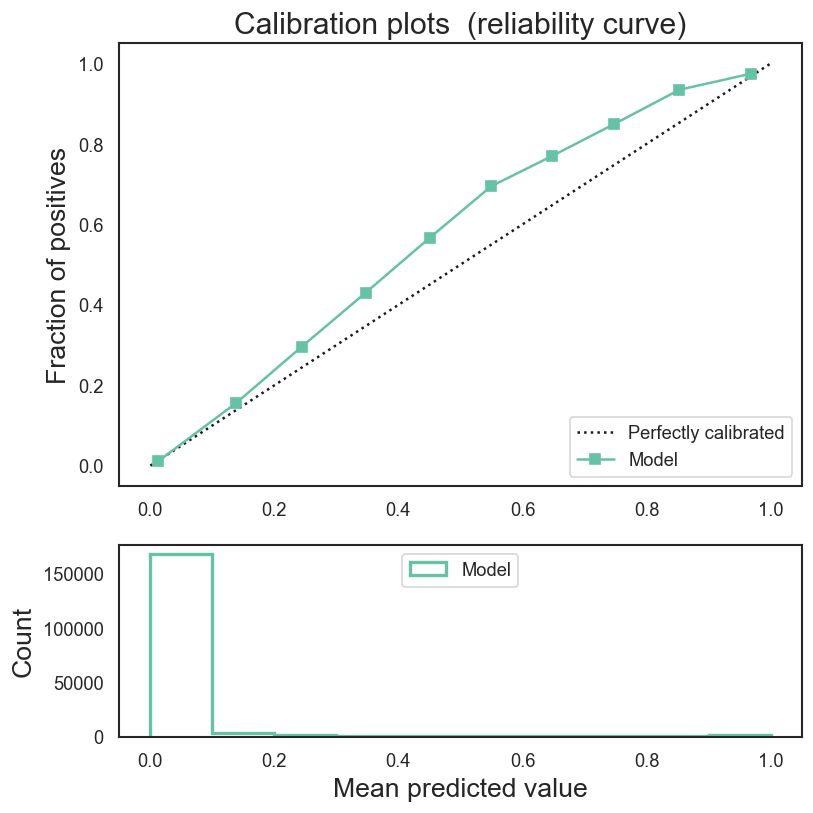

In [108]:
draw_calibration_curve(y_test, y_prob_pred_xgb, n_bins=10)

## C)  LightGBM

In [109]:
from lightgbm import LGBMClassifier

In [110]:
%%time
lgbc = LGBMClassifier(random_state=0, n_jobs = -1)
lgbc.fit(X_train,y_train)
lgbc

Wall time: 19.2 s


LGBMClassifier(random_state=0)

In [111]:
y_pred_lgbc = lgbc.predict(X_test)
y_prob_pred_lgbc = lgbc.predict_proba(X_test)[:, 1]
print("Y predicted : ",y_pred_lgbc)
print("Y probability predicted : ",y_prob_pred_lgbc[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.01616003 0.00807738 0.0082551  0.06708272 0.00728712]



Accuracy Score :  0.9774613066007383

AUC Score :  0.9239690737882372

Confusion Matrix : 
 [[170585    378]
 [  3615   2584]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99    170963
        True       0.87      0.42      0.56      6199

    accuracy                           0.98    177162
   macro avg       0.93      0.71      0.78    177162
weighted avg       0.98      0.98      0.97    177162


Concordance Index :  0.9239690501988727

ROC curve : 



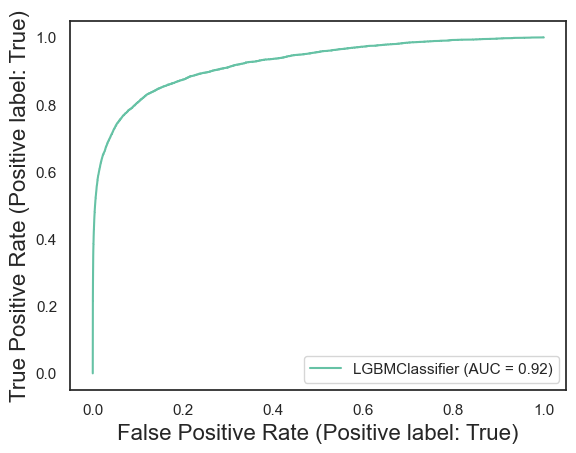


PR curve : 



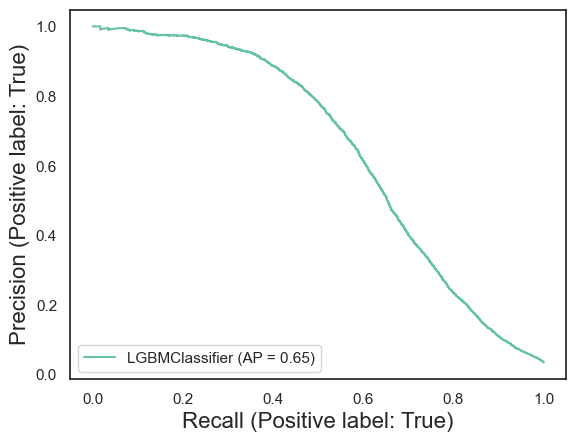


Additional Metrics:
TPR (Recall) : 0.4168
FPR : 0.0022
TNR (Specificity) : 0.9978
FNR : 0.5832


In [112]:
compute_evaluation_metric(lgbc, X_test, y_test, y_pred_lgbc, y_prob_pred_lgbc)

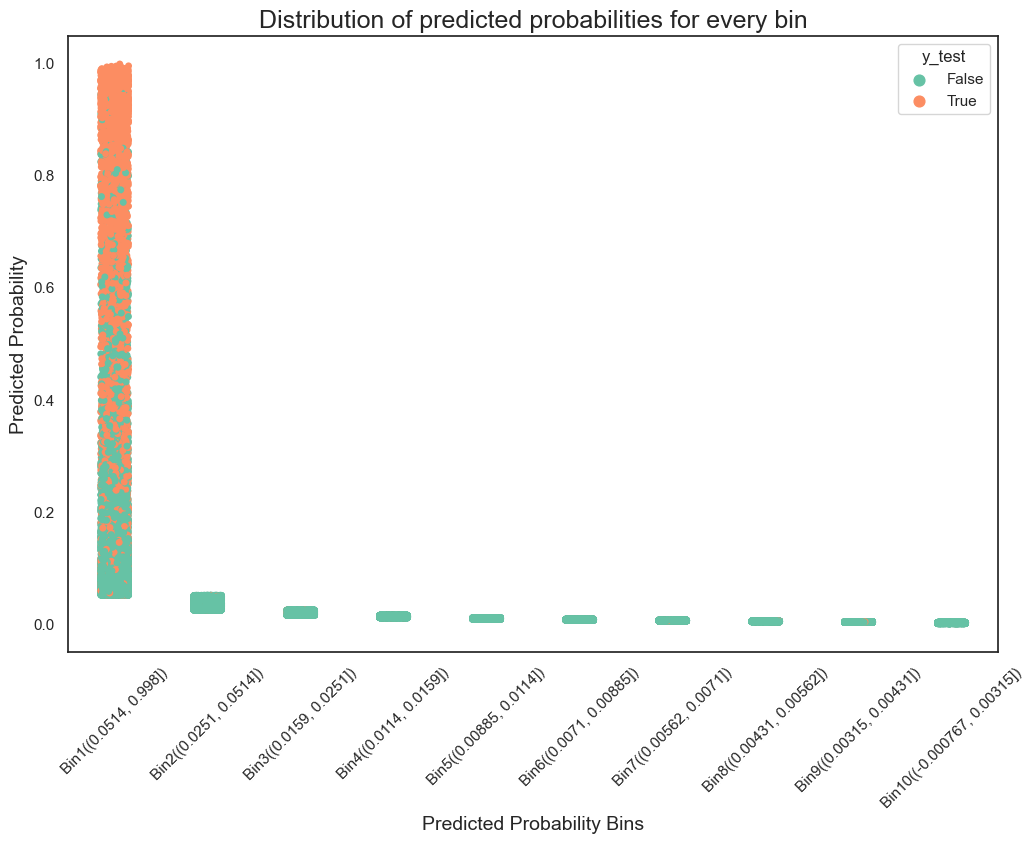

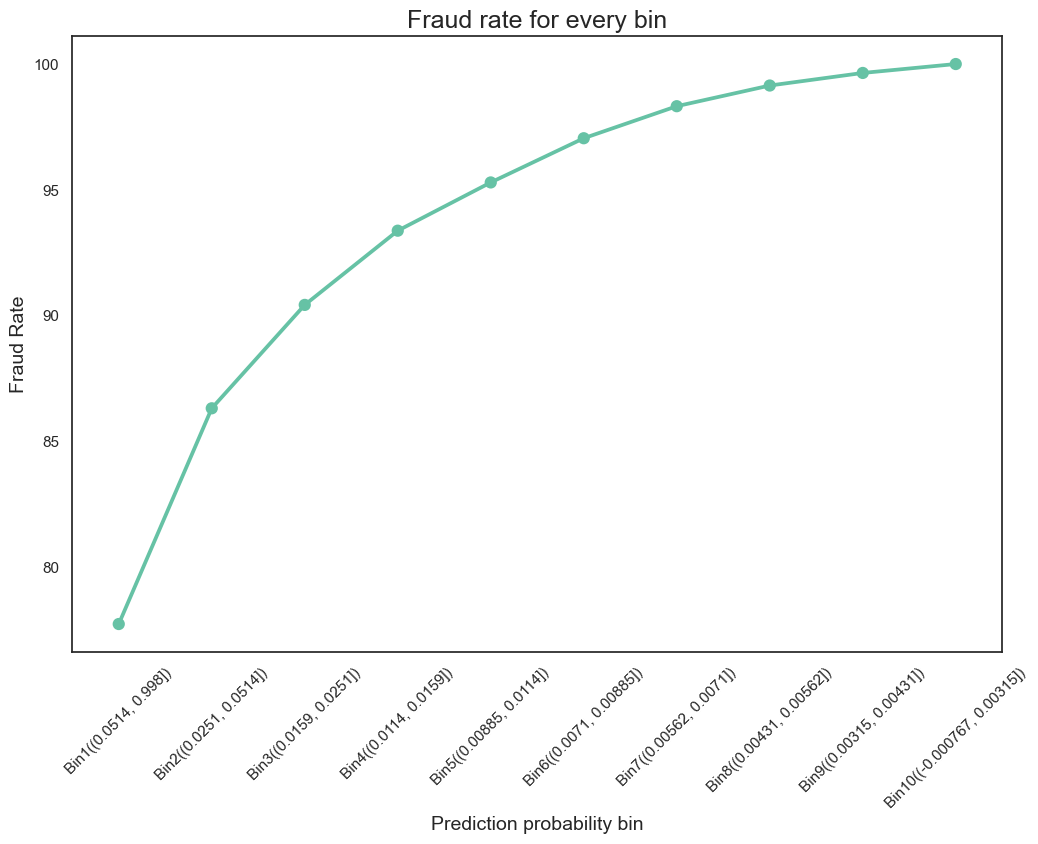

prob_bin  not_fraud  fraud  perc_fraud  perc_not_fraud  \
0        Bin1((0.0514, 0.998])      12899   4818    0.777222        0.075449   
1       Bin2((0.0251, 0.0514])      17184    532    0.085820        0.100513   
2       Bin3((0.0159, 0.0251])      17461    255    0.041136        0.102133   
3       Bin4((0.0114, 0.0159])      17533    183    0.029521        0.102554   
4      Bin5((0.00885, 0.0114])      17597    119    0.019197        0.102929   
5      Bin6((0.0071, 0.00885])      17607    109    0.017583        0.102987   
6      Bin7((0.00562, 0.0071])      17637     79    0.012744        0.103163   
7     Bin8((0.00431, 0.00562])      17665     51    0.008227        0.103326   
8     Bin9((0.00315, 0.00431])      17685     31    0.005001        0.103443   
9  Bin10((-0.000767, 0.00315])      17695     22    0.003549        0.103502   

   cum_perc_fraud  cum_perc_not_fraud  
0       77.722213            7.544907  
1       86.304243           17.596205  
2       90.417809           27.809526  
3       93.369898           38.064961  
4       95.289563           48.357832  
5       97.047911           58.656551  
6       98.322310           68.972819  
7       99.145023           79.305464  
8       99.645104           89.649807  
9      100.000000          100.000000

In [113]:
captures(y_test, y_pred_lgbc, y_prob_pred_lgbc)

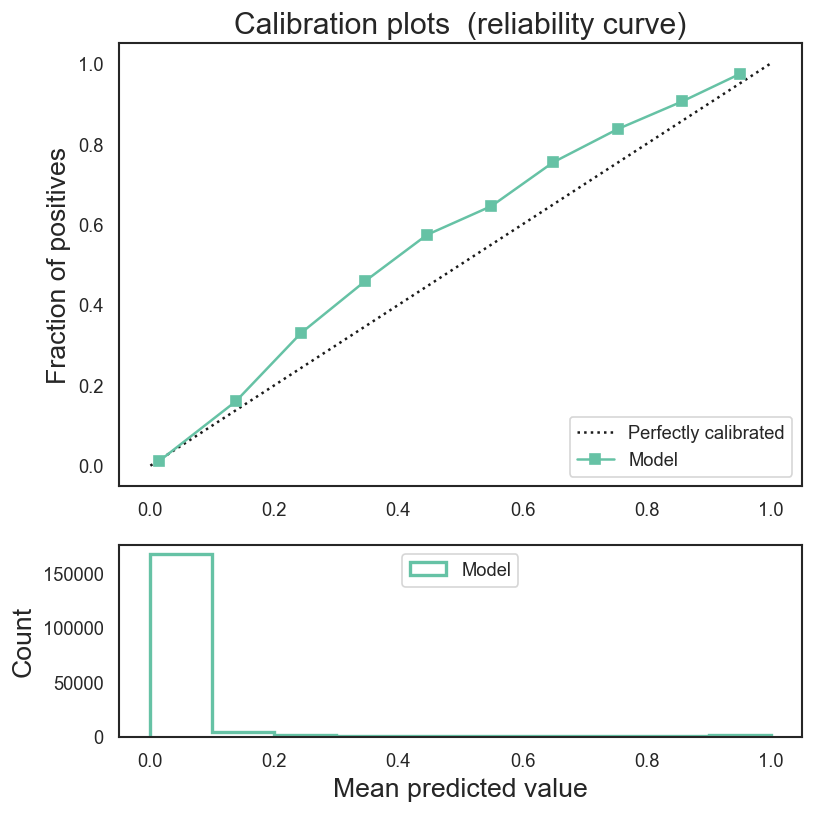

In [114]:
draw_calibration_curve(y_test, y_prob_pred_lgbc, n_bins=10)

- With LGBM, Accuracy score is 97.7%. It's almost similar to XGBoost model
- AUC is almost similar to xgboost
- Recall and f-1 score have also improved, but it's still not upto the mark
- LGBM is much faster compare to XGBoost

## D) Random Forest Classifier

In [115]:
from sklearn.ensemble import RandomForestClassifier

In [116]:
%%time
rfc = RandomForestClassifier(random_state=0, n_jobs = -1)
rfc.fit(X_train, y_train)
rfc

Wall time: 2min 36s


RandomForestClassifier(n_jobs=-1, random_state=0)

In [117]:
y_pred_rfc = rfc.predict(X_test)
y_prob_pred_rfc = rfc.predict_proba(X_test)[:, 1]
print("Y predicted : ",y_pred_rfc)
print("Y probability predicted : ",y_prob_pred_rfc[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.02 0.   0.   0.06 0.02]



Accuracy Score :  0.9792901412266739

AUC Score :  0.9295181538168427

Confusion Matrix : 
 [[170811    152]
 [  3517   2682]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99    170963
        True       0.95      0.43      0.59      6199

    accuracy                           0.98    177162
   macro avg       0.96      0.72      0.79    177162
weighted avg       0.98      0.98      0.98    177162


Concordance Index :  0.914790096309497

ROC curve : 



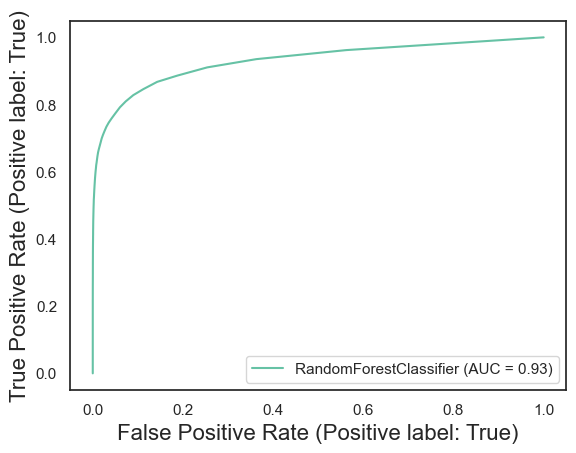


PR curve : 



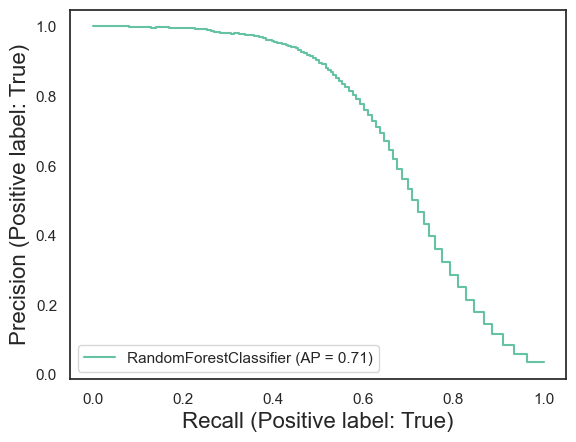


Additional Metrics:
TPR (Recall) : 0.4327
FPR : 0.0009
TNR (Specificity) : 0.9991
FNR : 0.5673


In [118]:
compute_evaluation_metric(rfc, X_test, y_test, y_pred_rfc, y_prob_pred_rfc)

In [119]:
concordance(y_test.values, y_prob_pred_rfc)

0.914790096309497

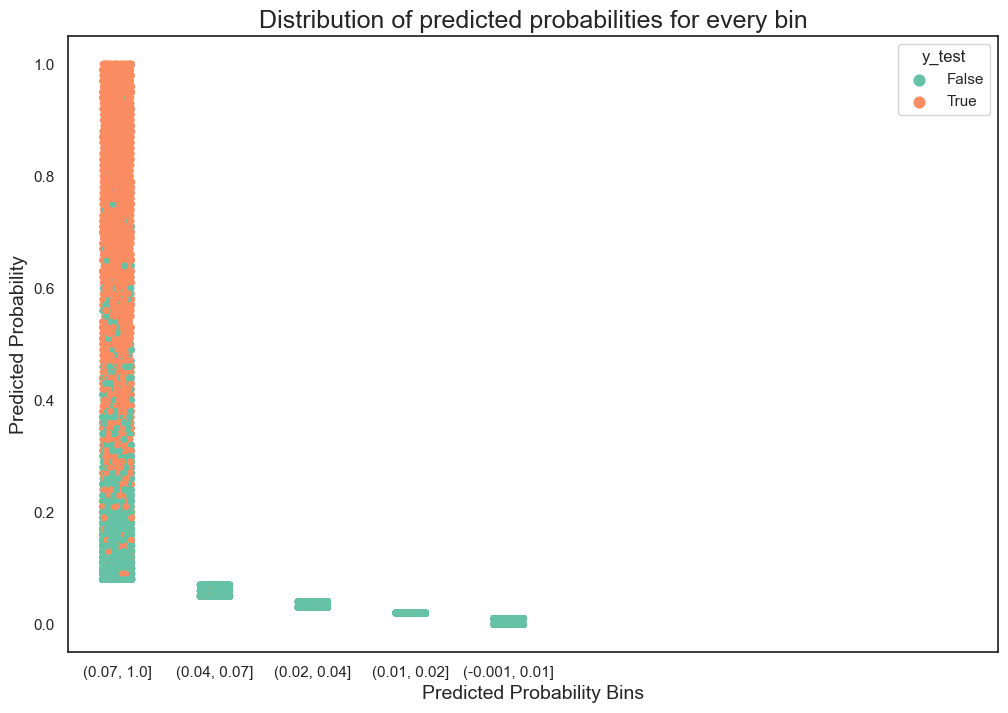

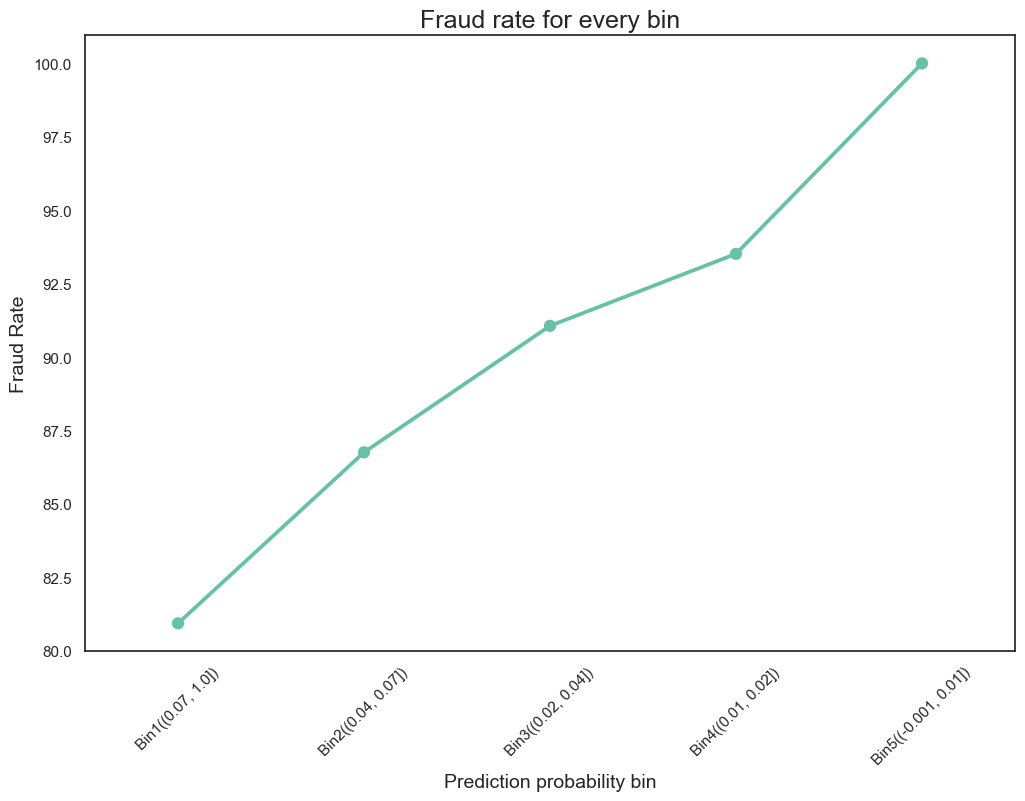

prob_bin  not_fraud  fraud  perc_fraud  perc_not_fraud  \
0     Bin1((0.07, 1.0])      12482   5017    0.809324        0.073010   
1    Bin2((0.04, 0.07])      11939    361    0.058235        0.069834   
2    Bin3((0.02, 0.04])      18984    267    0.043071        0.111042   
3    Bin4((0.01, 0.02])      18595    152    0.024520        0.108766   
4  Bin5((-0.001, 0.01])     108963    402    0.064849        0.637348   

   cum_perc_fraud  cum_perc_not_fraud  
0       80.932408            7.300995  
1       86.755928           14.284377  
2       91.063075           25.388534  
3       93.515083           36.265157  
4      100.000000          100.000000

In [120]:
captures(y_test, y_pred_rfc, y_prob_pred_rfc)

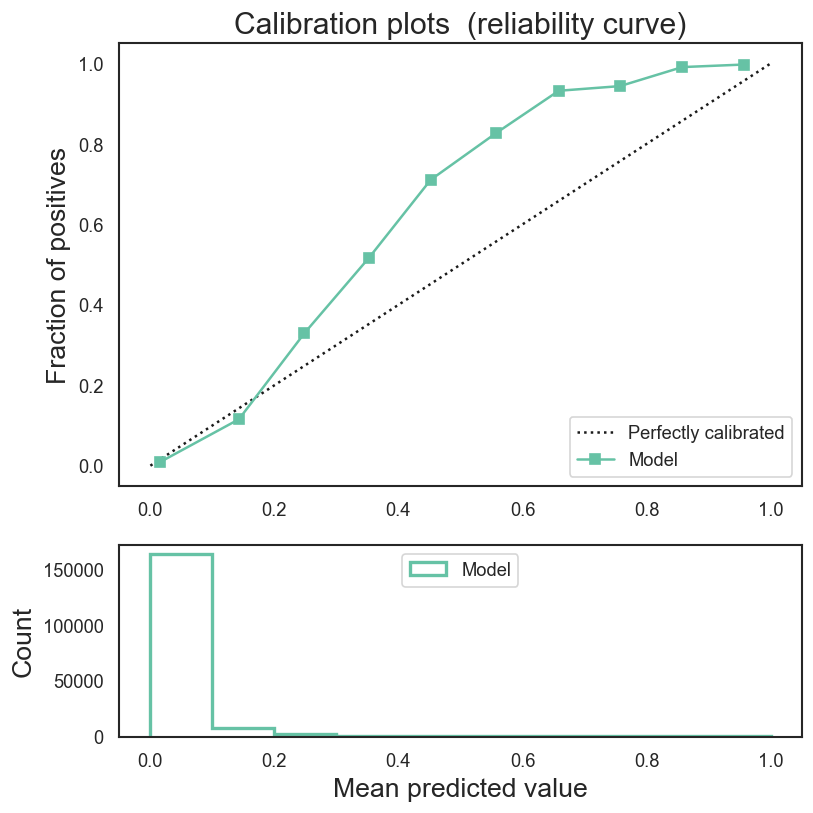

In [121]:
draw_calibration_curve(y_test, y_prob_pred_rfc, n_bins=10)

# 12. LightGBM Model Optimization & Enhancements

#### Fine-tune and improve the best-performing model (LightGBM) using advanced techniques to handle imbalance, improve calibration, and optimize performance

## A) Handling Class Imbalance

- #### Handle Class Imbalance with Random Oversampler

In [122]:
from   imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
y_train_ros.value_counts()

False    398914
True     398914
Name: isFraud, dtype: int64

In [123]:
%%time
lgbc_ros = LGBMClassifier(random_state=0)
lgbc_ros.fit(X_train_ros,y_train_ros)
lgbc_ros

Wall time: 57 s


LGBMClassifier(random_state=0)

In [124]:
y_pred_lgbcros = lgbc_ros.predict(X_test)
y_prob_pred_lgbcros = lgbc_ros.predict_proba(X_test)[:, 1]
print("Y predicted : ",y_pred_lgbcros)
print("Y probability predicted : ",y_prob_pred_lgbcros[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.26540126 0.1266335  0.17469493 0.61232328 0.12412469]



Accuracy Score :  0.8851954708120251

AUC Score :  0.9270401750477294

Confusion Matrix : 
 [[151774  19189]
 [  1150   5049]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.99      0.89      0.94    170963
        True       0.21      0.81      0.33      6199

    accuracy                           0.89    177162
   macro avg       0.60      0.85      0.63    177162
weighted avg       0.97      0.89      0.92    177162


Concordance Index :  0.9270401703298564

ROC curve : 



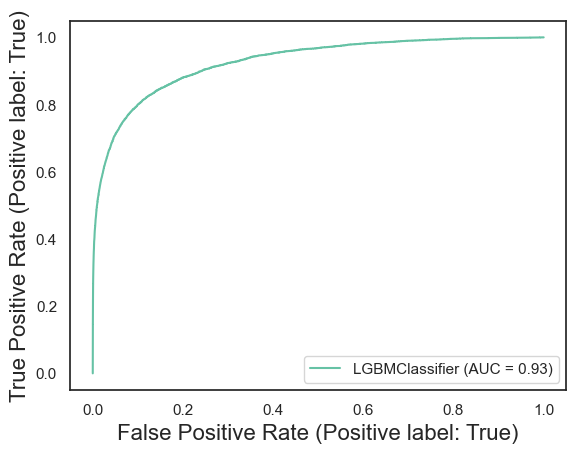


PR curve : 



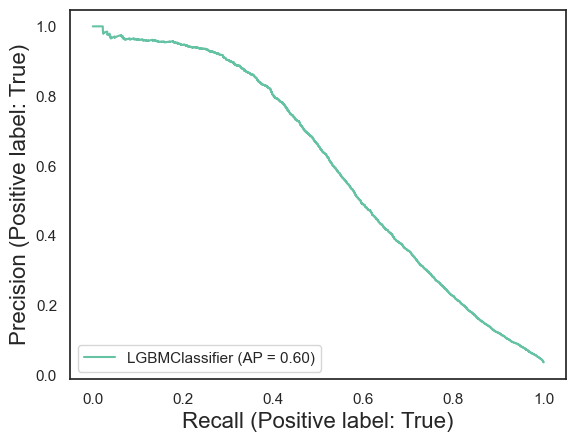


Additional Metrics:
TPR (Recall) : 0.8145
FPR : 0.1122
TNR (Specificity) : 0.8878
FNR : 0.1855


In [125]:
compute_evaluation_metric(lgbc_ros, X_test, y_test, y_pred_lgbcros, y_prob_pred_lgbcros)

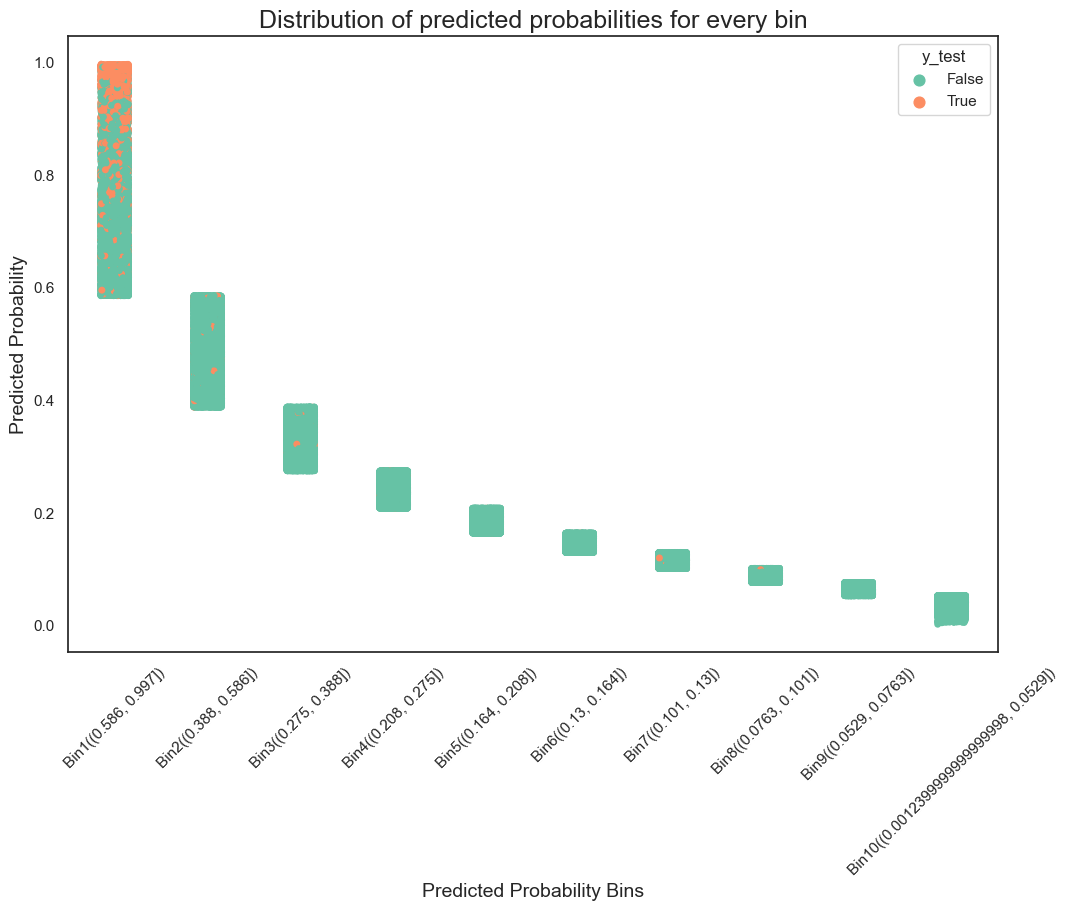

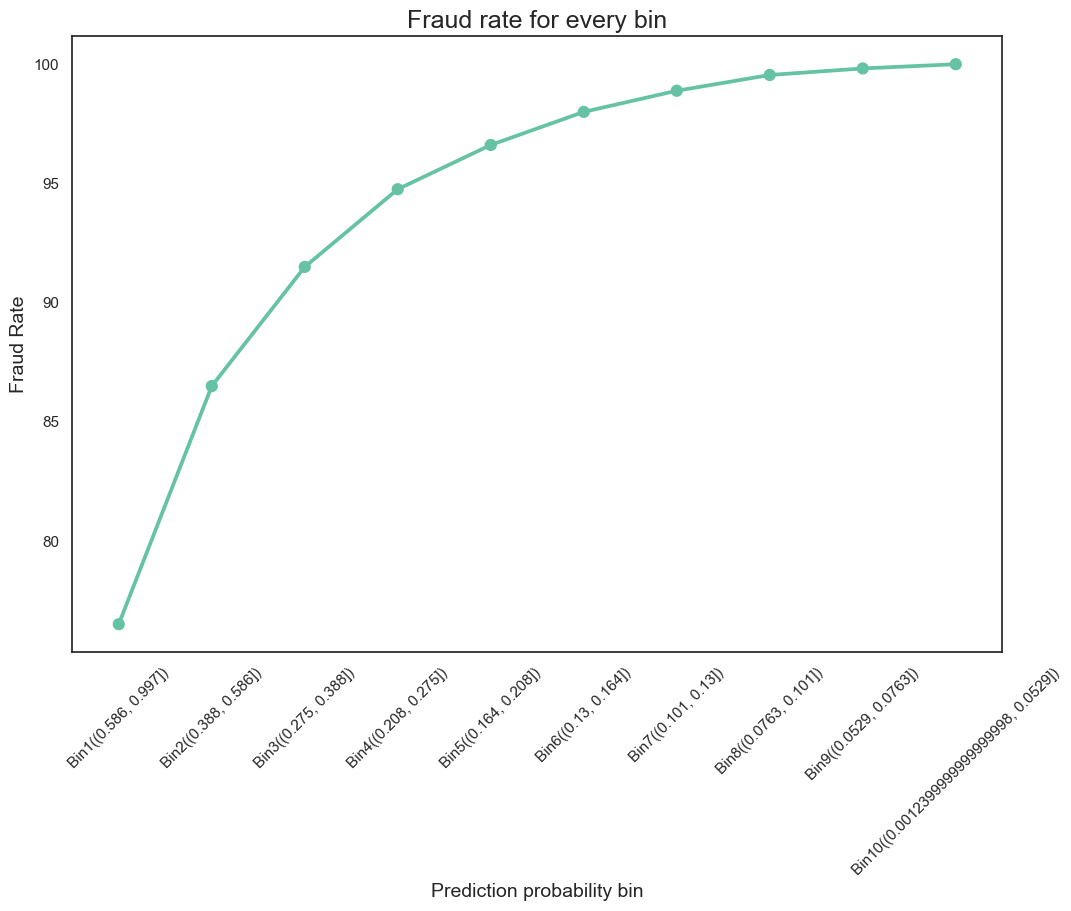

prob_bin  not_fraud  fraud  perc_fraud  \
0                    Bin1((0.586, 0.997])      12974   4743    0.765123   
1                    Bin2((0.388, 0.586])      17097    619    0.099855   
2                    Bin3((0.275, 0.388])      17406    310    0.050008   
3                    Bin4((0.208, 0.275])      17514    202    0.032586   
4                    Bin5((0.164, 0.208])      17601    115    0.018551   
5                     Bin6((0.13, 0.164])      17630     86    0.013873   
6                     Bin7((0.101, 0.13])      17661     55    0.008872   
7                   Bin8((0.0763, 0.101])      17675     41    0.006614   
8                  Bin9((0.0529, 0.0763])      17699     17    0.002742   
9  Bin10((0.0012399999999999998, 0.0529])      17706     11    0.001774   

   perc_not_fraud  cum_perc_fraud  cum_perc_not_fraud  
0        0.075888       76.512341            7.588777  
1        0.100004       86.497822           17.589186  
2        0.101812       91.498629           27.770336  
3        0.102443       94.757219           38.014658  
4        0.102952       96.612357           48.309868  
5        0.103122       97.999677           58.622041  
6        0.103303       98.886917           68.952346  
7        0.103385       99.548314           79.290841  
8        0.103525       99.822552           89.643373  
9        0.103566      100.000000          100.000000

In [126]:
captures(y_test, y_pred_lgbcros, y_prob_pred_lgbcros)

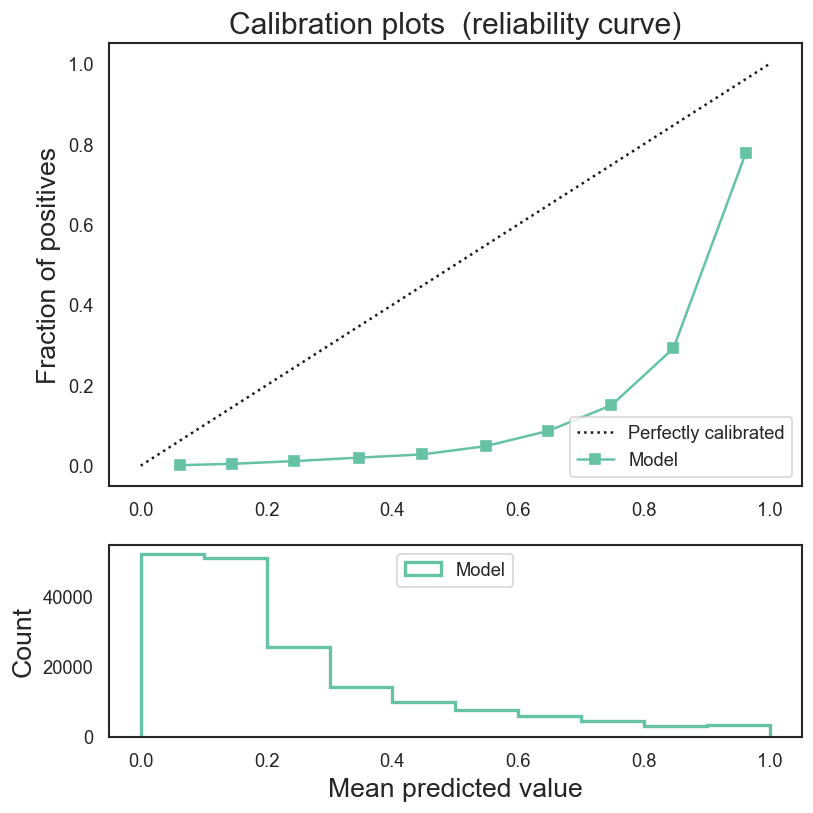

In [127]:
draw_calibration_curve(y_test, y_prob_pred_lgbcros, n_bins=10)

- After balancing the class, accuracy score is 0.88 and AUC score is 92.5% 
- Accuracy has decreased as compared to the previos model, but AUC has improved
- Additionally the recall has improved significantly at the cost of precision.

## B) Cost Sensitive Learning with Class weights

In [130]:
%%time
lgbc_bal = LGBMClassifier(random_state=0, class_weight='balanced')
lgbc_bal.fit(X_train, y_train)
lgbc_bal

Wall time: 33 s


LGBMClassifier(class_weight='balanced', random_state=0)

In [131]:
y_pred_lgbcbal = lgbc_bal.predict(X_test)
y_prob_pred_lgbcbal = lgbc_bal.predict_proba(X_test)[:, 1]
print("Y predicted : ",y_pred_lgbcbal)
print("Y probability predicted : ",y_prob_pred_lgbcbal[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.22700362 0.15390235 0.13087413 0.52349433 0.14032882]



Accuracy Score :  0.8862284237025999

AUC Score :  0.927124006459723

Confusion Matrix : 
 [[151969  18994]
 [  1162   5037]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.99      0.89      0.94    170963
        True       0.21      0.81      0.33      6199

    accuracy                           0.89    177162
   macro avg       0.60      0.85      0.64    177162
weighted avg       0.97      0.89      0.92    177162


Concordance Index :  0.9271239946650406

ROC curve : 



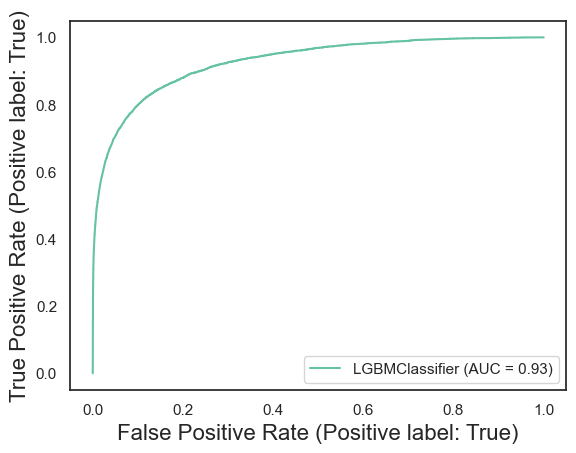


PR curve : 



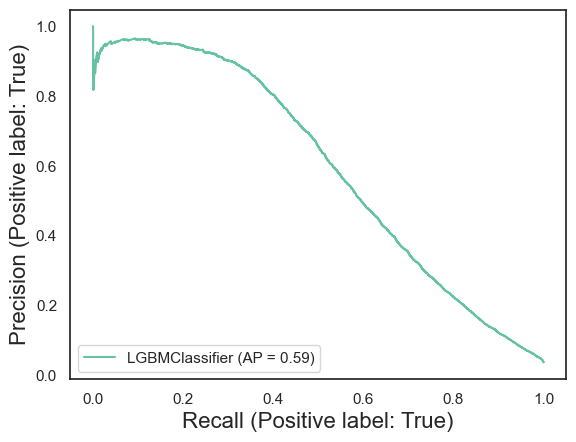


Additional Metrics:
TPR (Recall) : 0.8126
FPR : 0.1111
TNR (Specificity) : 0.8889
FNR : 0.1874


In [132]:
compute_evaluation_metric(lgbc_bal, X_test, y_test, y_pred_lgbcbal, y_prob_pred_lgbcbal)

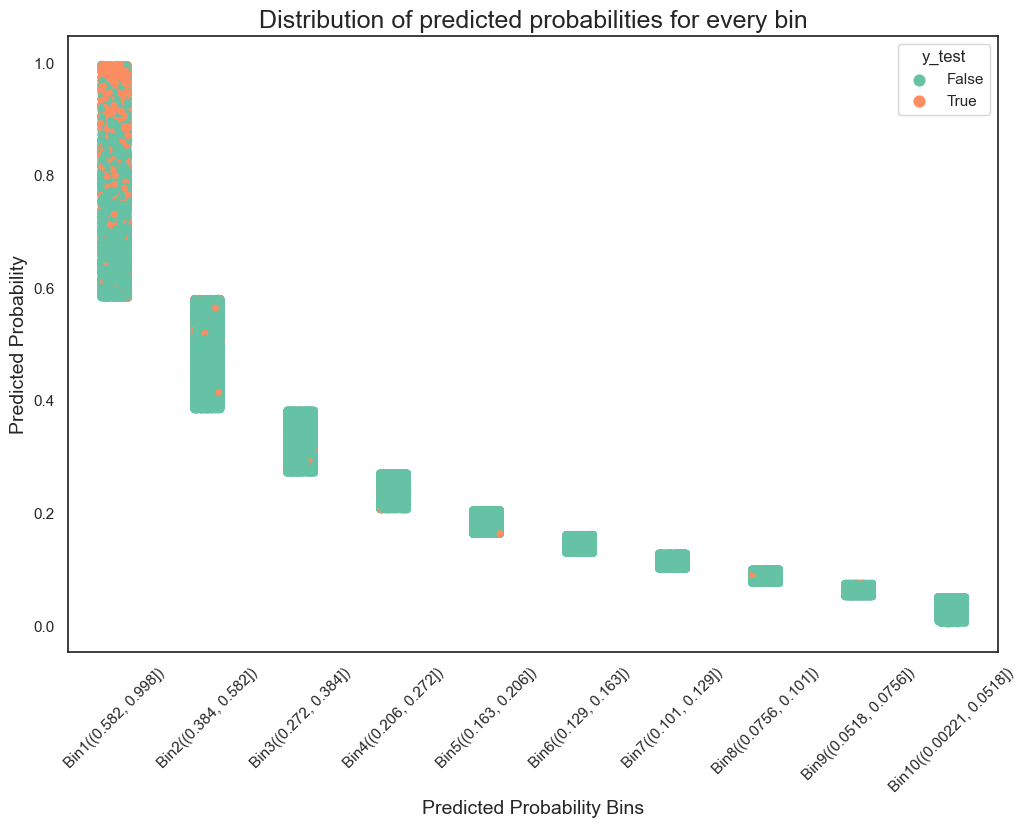

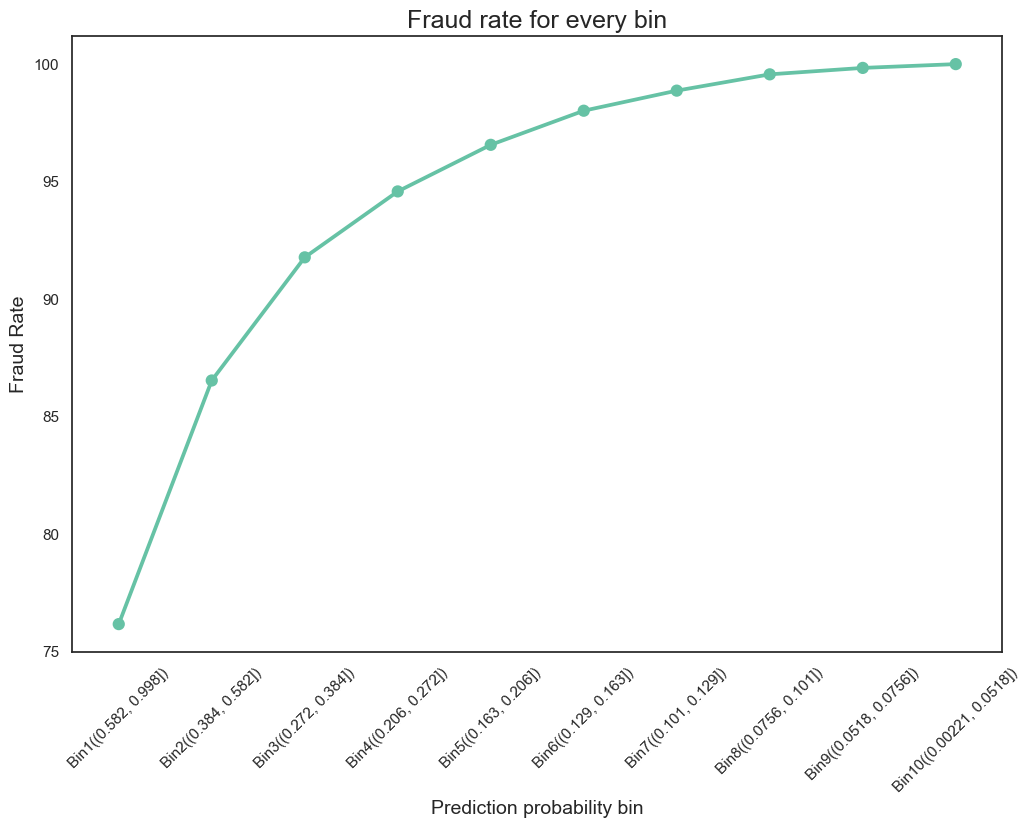

prob_bin  not_fraud  fraud  perc_fraud  perc_not_fraud  \
0      Bin1((0.582, 0.998])      12996   4721    0.761574        0.076016   
1      Bin2((0.384, 0.582])      17073    643    0.103726        0.099864   
2      Bin3((0.272, 0.384])      17391    325    0.052428        0.101724   
3      Bin4((0.206, 0.272])      17542    174    0.028069        0.102607   
4      Bin5((0.163, 0.206])      17593    123    0.019842        0.102905   
5      Bin6((0.129, 0.163])      17626     90    0.014518        0.103098   
6      Bin7((0.101, 0.129])      17663     53    0.008550        0.103315   
7     Bin8((0.0756, 0.101])      17673     43    0.006937        0.103373   
8    Bin9((0.0518, 0.0756])      17699     17    0.002742        0.103525   
9  Bin10((0.00221, 0.0518])      17707     10    0.001613        0.103572   

   cum_perc_fraud  cum_perc_not_fraud  
0       76.157445            7.601645  
1       86.530085           17.588016  
2       91.772867           27.760393  
3       94.579771           38.021092  
4       96.563962           48.311623  
5       98.015809           58.621456  
6       98.870786           68.952931  
7       99.564446           79.290256  
8       99.838684           89.642788  
9      100.000000          100.000000

In [133]:
captures(y_test, y_pred_lgbcbal, y_prob_pred_lgbcbal)

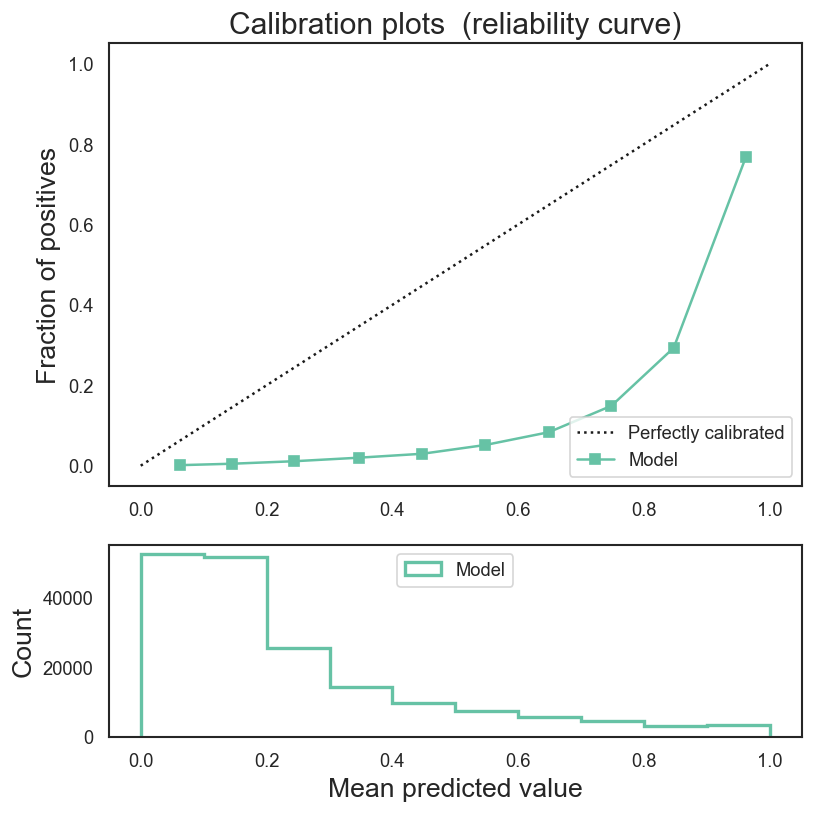

In [134]:
draw_calibration_curve(y_test, y_prob_pred_lgbcbal, n_bins=10)

## C) Calibrated CV LightGBM (Cost-Sensitive)

In [135]:
from sklearn.calibration import CalibratedClassifierCV

In [136]:
%%time
lgbc_bal = LGBMClassifier(random_state=0)
calibrated_clf = CalibratedClassifierCV(base_estimator=lgbc_bal, cv=3, method='sigmoid')
calibrated_clf.fit(X_train, y_train)

Wall time: 1min 23s


CalibratedClassifierCV(base_estimator=LGBMClassifier(random_state=0), cv=3)

In [137]:
y_pred_calib = calibrated_clf.predict(X_test)
y_prob_pred_calib = calibrated_clf.predict_proba(X_test)[:, 1]
print("Y predicted : ", y_pred_calib)
print("Y probability predicted : ", y_prob_pred_calib[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.01510527 0.013539   0.01360709 0.0235388  0.01342325]


In [138]:
len(calibrated_clf.calibrated_classifiers_)

3


Accuracy Score :  0.9781160745532338

AUC Score :  0.9292560410642979

Confusion Matrix : 
 [[170502    461]
 [  3416   2783]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99    170963
        True       0.86      0.45      0.59      6199

    accuracy                           0.98    177162
   macro avg       0.92      0.72      0.79    177162
weighted avg       0.98      0.98      0.97    177162


Concordance Index :  0.9292560391771487

ROC curve : 



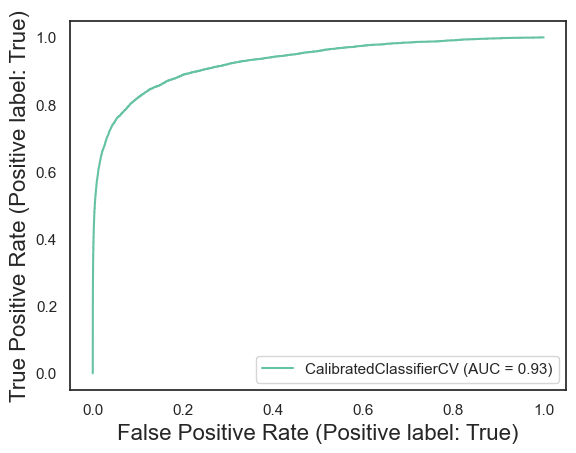


PR curve : 



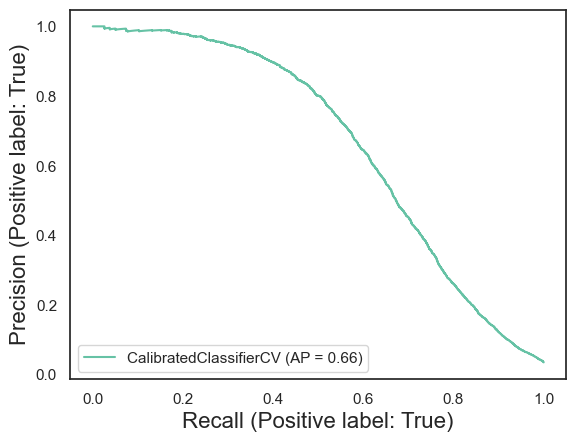


Additional Metrics:
TPR (Recall) : 0.4489
FPR : 0.0027
TNR (Specificity) : 0.9973
FNR : 0.5511


In [139]:
compute_evaluation_metric(calibrated_clf, X_test, y_test, y_pred_calib, y_prob_pred_calib)

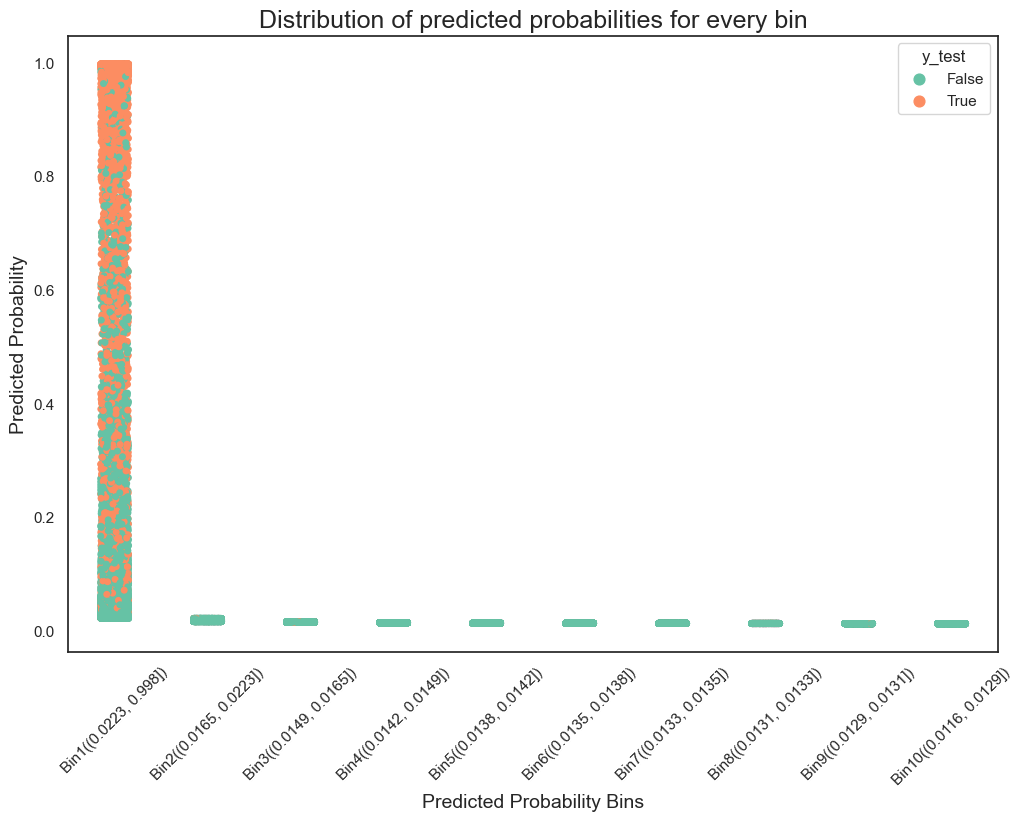

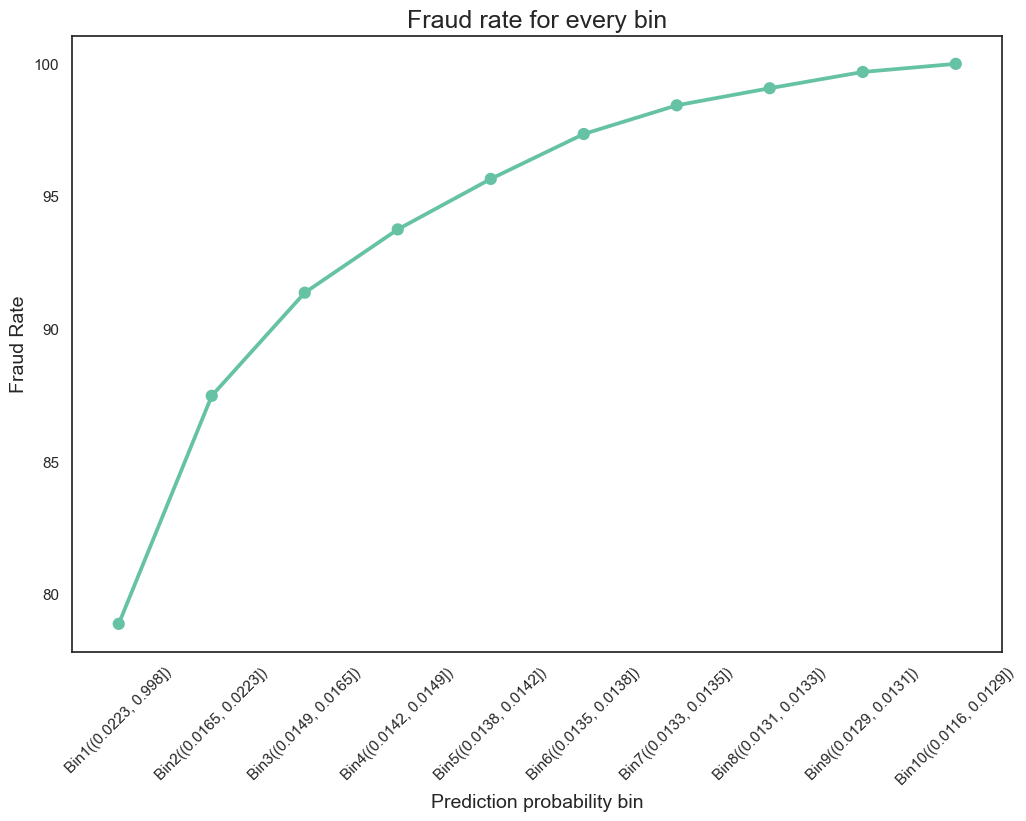

prob_bin  not_fraud  fraud  perc_fraud  perc_not_fraud  \
0    Bin1((0.0223, 0.998])      12827   4890    0.788837        0.075028   
1   Bin2((0.0165, 0.0223])      17183    533    0.085982        0.100507   
2   Bin3((0.0149, 0.0165])      17475    241    0.038877        0.102215   
3   Bin4((0.0142, 0.0149])      17568    148    0.023875        0.102759   
4   Bin5((0.0138, 0.0142])      17598    118    0.019035        0.102935   
5   Bin6((0.0135, 0.0138])      17611    105    0.016938        0.103011   
6   Bin7((0.0133, 0.0135])      17649     67    0.010808        0.103233   
7   Bin8((0.0131, 0.0133])      17676     40    0.006453        0.103391   
8   Bin9((0.0129, 0.0131])      17678     38    0.006130        0.103402   
9  Bin10((0.0116, 0.0129])      17698     19    0.003065        0.103519   

   cum_perc_fraud  cum_perc_not_fraud  
0       78.883691            7.502793  
1       87.481852           17.553506  
2       91.369576           27.775016  
3       93.757058           38.050923  
4       95.660590           48.344379  
5       97.354412           58.645438  
6       98.435231           68.968724  
7       99.080497           79.307803  
8       99.693499           89.648053  
9      100.000000          100.000000

In [140]:
captures(y_test, y_pred_calib, y_prob_pred_calib)

## D) Hyperparameter Tuned LightGBM

In [141]:
%%time

lgbmclassifier = LGBMClassifier(
    class_weight=None,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=100,     
    num_leaves=256,
    reg_alpha=0.5,
    random_state=0
)

lgbmclassifier.fit(X_train, y_train)

Wall time: 35.8 s


LGBMClassifier(max_depth=8, num_leaves=256, random_state=0, reg_alpha=0.5)

In [142]:
y_g_pred = lgbmclassifier.predict(X_test)
y_prob_g_pred = lgbmclassifier.predict_proba(X_test)[:, 1]
print("Y predicted : ",y_g_pred)
print("Y probability predicted : ",y_prob_g_pred[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.00549227 0.00615294 0.007173   0.09576845 0.00734595]



Accuracy Score :  0.9796909043700116

AUC Score :  0.9439534102237099

Confusion Matrix : 
 [[170676    287]
 [  3311   2888]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99    170963
        True       0.91      0.47      0.62      6199

    accuracy                           0.98    177162
   macro avg       0.95      0.73      0.80    177162
weighted avg       0.98      0.98      0.98    177162


Concordance Index :  0.9439534040904752

ROC curve : 



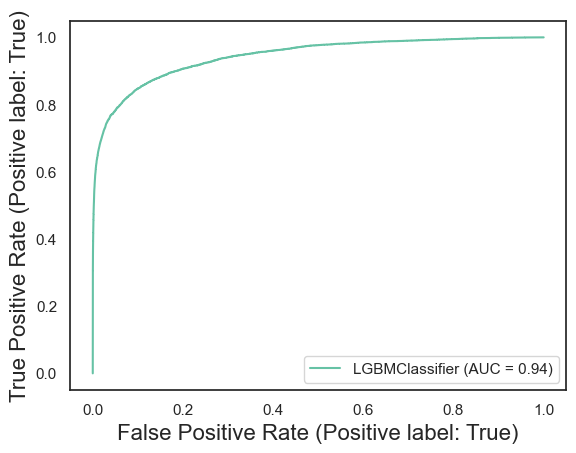


PR curve : 



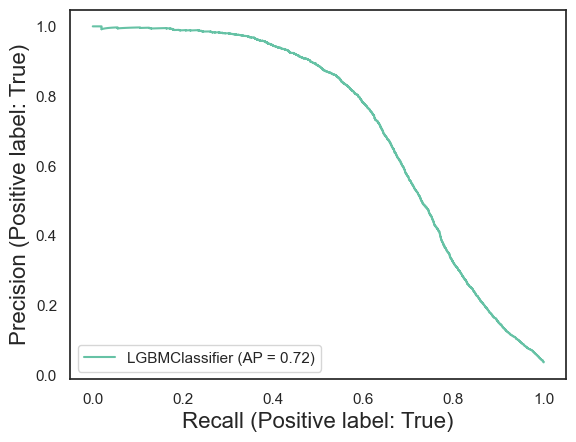


Additional Metrics:
TPR (Recall) : 0.4659
FPR : 0.0017
TNR (Specificity) : 0.9983
FNR : 0.5341


In [143]:
compute_evaluation_metric(lgbmclassifier, X_test, y_test, y_g_pred, y_prob_g_pred)

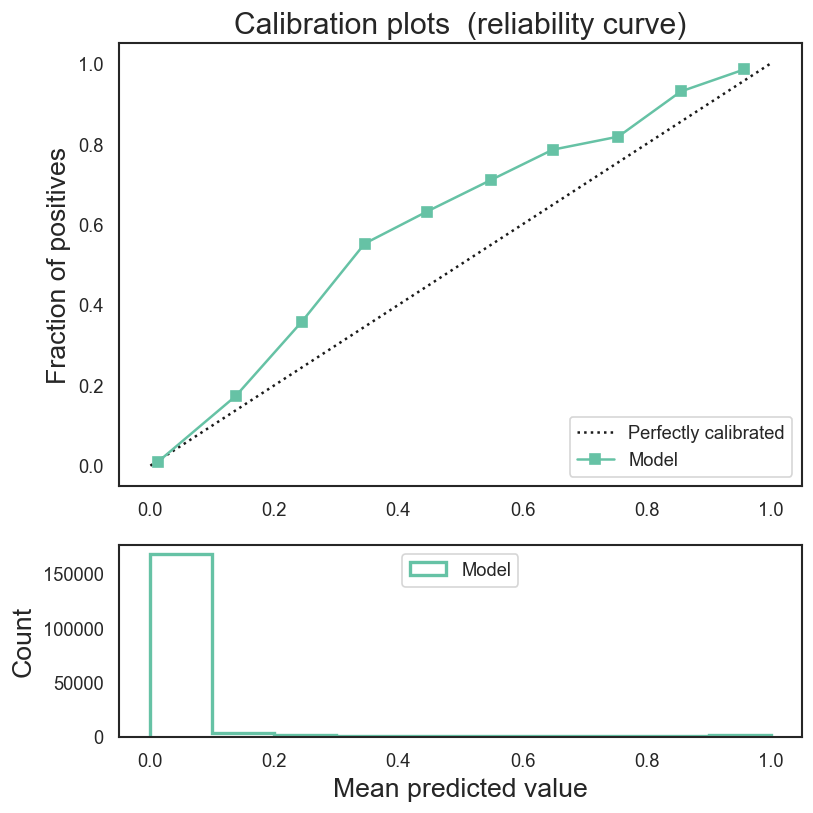

In [144]:
draw_calibration_curve(y_test, y_prob_g_pred, n_bins=10)

## E) Calibrated Hyperparameter Tuned LightGBM

In [145]:
%%time
calibrated_clf = CalibratedClassifierCV(base_estimator=lgbmclassifier, cv=3)
calibrated_clf.fit(X_train, y_train)
y_pred_calib = calibrated_clf.predict(X_test)
y_prob_pred_calib = calibrated_clf.predict_proba(X_test)[:, 1]

Wall time: 1min 52s


In [147]:
print("Y predicted : ",y_pred_calib)
print("Y probability predicted : ",y_prob_pred_calib[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.0127587  0.0123726  0.01236585 0.01727804 0.01247535]



Accuracy Score :  0.9804416296948556

AUC Score :  0.9456479526988175

Confusion Matrix : 
 [[170572    391]
 [  3074   3125]]

Classification Report : 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99    170963
        True       0.89      0.50      0.64      6199

    accuracy                           0.98    177162
   macro avg       0.94      0.75      0.82    177162
weighted avg       0.98      0.98      0.98    177162


Concordance Index :  0.9456479526988175

ROC curve : 



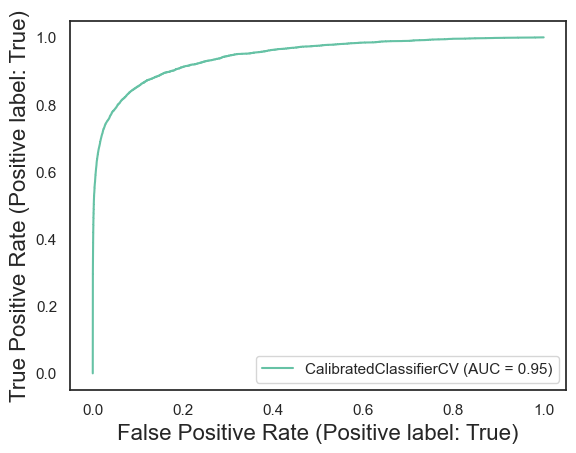


PR curve : 



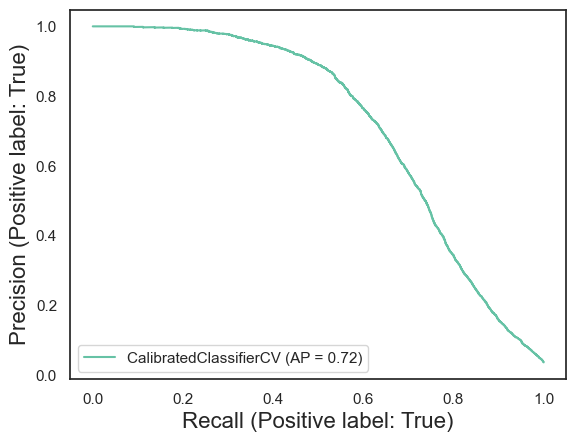


Additional Metrics:
TPR (Recall) : 0.5041
FPR : 0.0023
TNR (Specificity) : 0.9977
FNR : 0.4959


In [150]:
compute_evaluation_metric(calibrated_clf, X_test, y_test, y_pred_calib, y_prob_pred_calib)

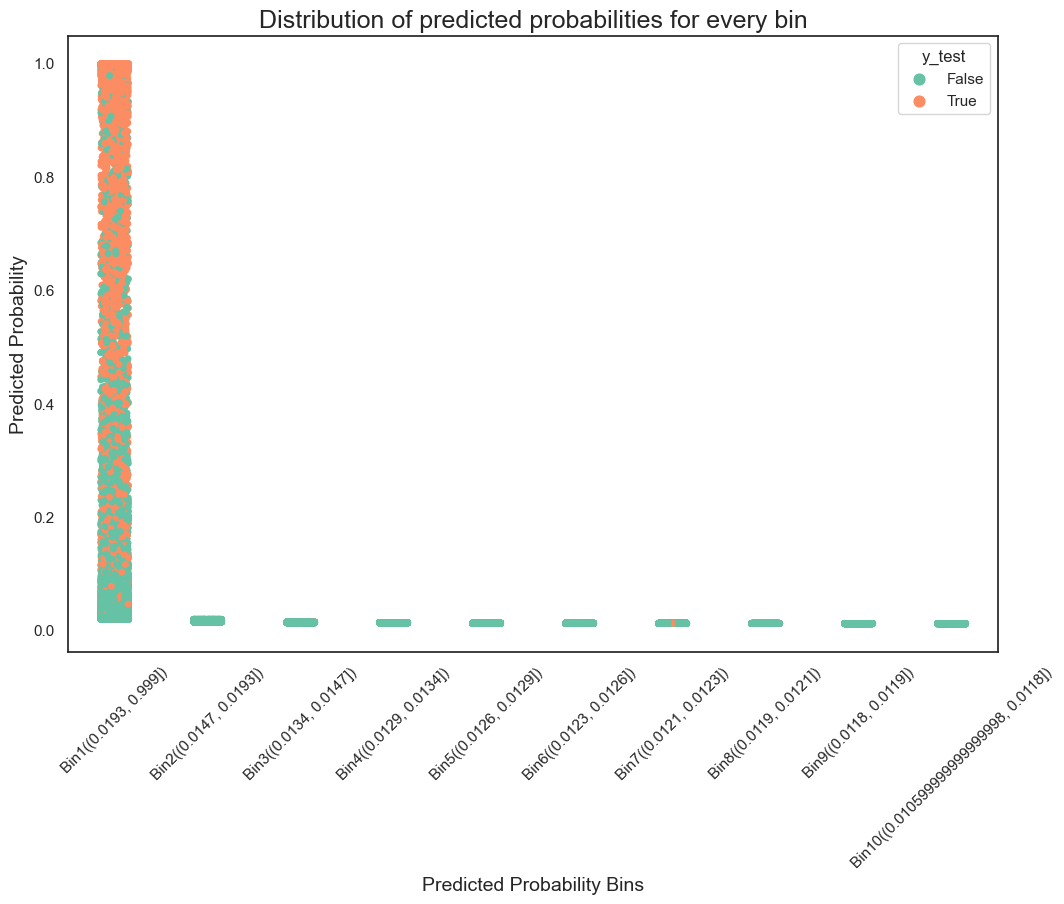

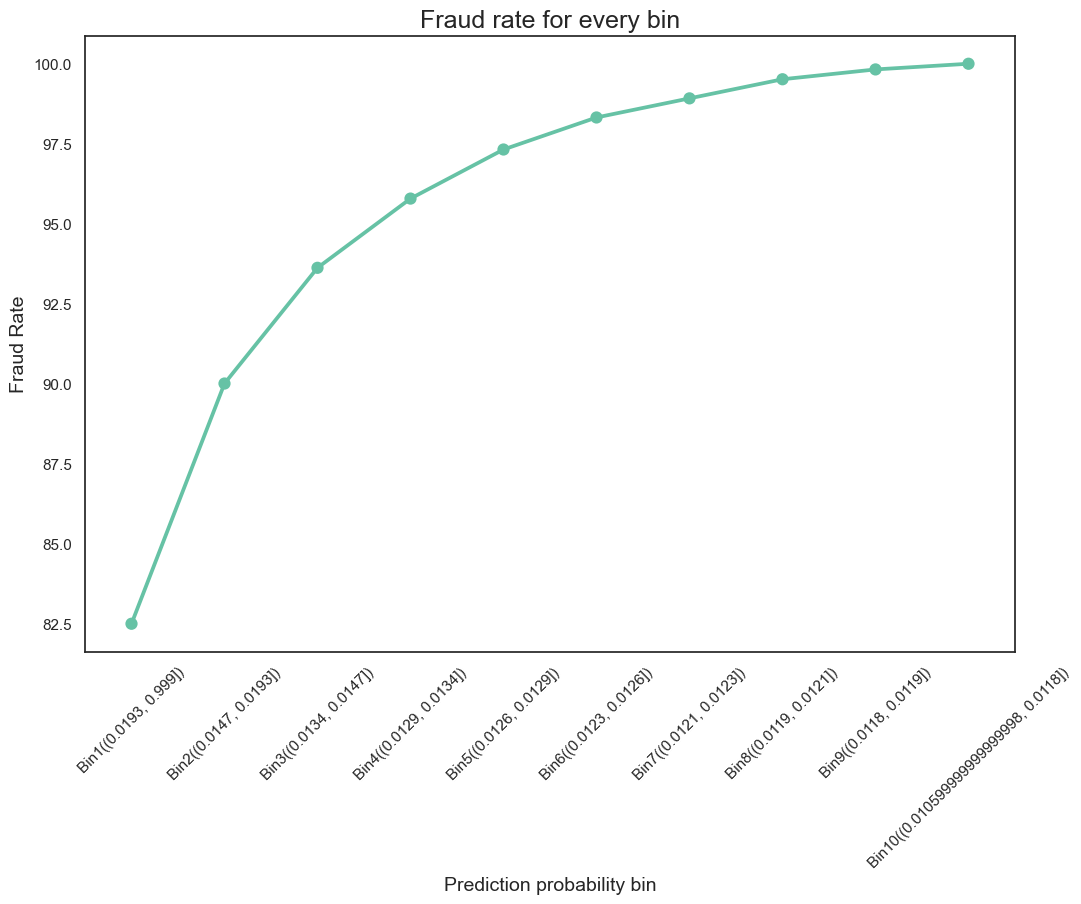

prob_bin  not_fraud  fraud  perc_fraud  \
0                  Bin1((0.0193, 0.999])      12602   5115    0.825133   
1                 Bin2((0.0147, 0.0193])      17251    465    0.075012   
2                 Bin3((0.0134, 0.0147])      17492    224    0.036135   
3                 Bin4((0.0129, 0.0134])      17582    134    0.021616   
4                 Bin5((0.0126, 0.0129])      17621     95    0.015325   
5                 Bin6((0.0123, 0.0126])      17654     62    0.010002   
6                 Bin7((0.0121, 0.0123])      17679     37    0.005969   
7                 Bin8((0.0119, 0.0121])      17679     37    0.005969   
8                 Bin9((0.0118, 0.0119])      17697     19    0.003065   
9  Bin10((0.010599999999999998, 0.0118])      17706     11    0.001774   

   perc_not_fraud  cum_perc_fraud  cum_perc_not_fraud  
0        0.073712       82.513309            7.371186  
1        0.100905       90.014518           17.461673  
2        0.102315       93.628005           27.693127  
3        0.102841       95.789643           37.977223  
4        0.103069       97.322149           48.284132  
5        0.103262       98.322310           58.610343  
6        0.103408       98.919181           68.951177  
7        0.103408       99.516051           79.292011  
8        0.103514       99.822552           89.643373  
9        0.103566      100.000000          100.000000

In [151]:
captures(y_test, y_pred_calib, y_prob_pred_calib)

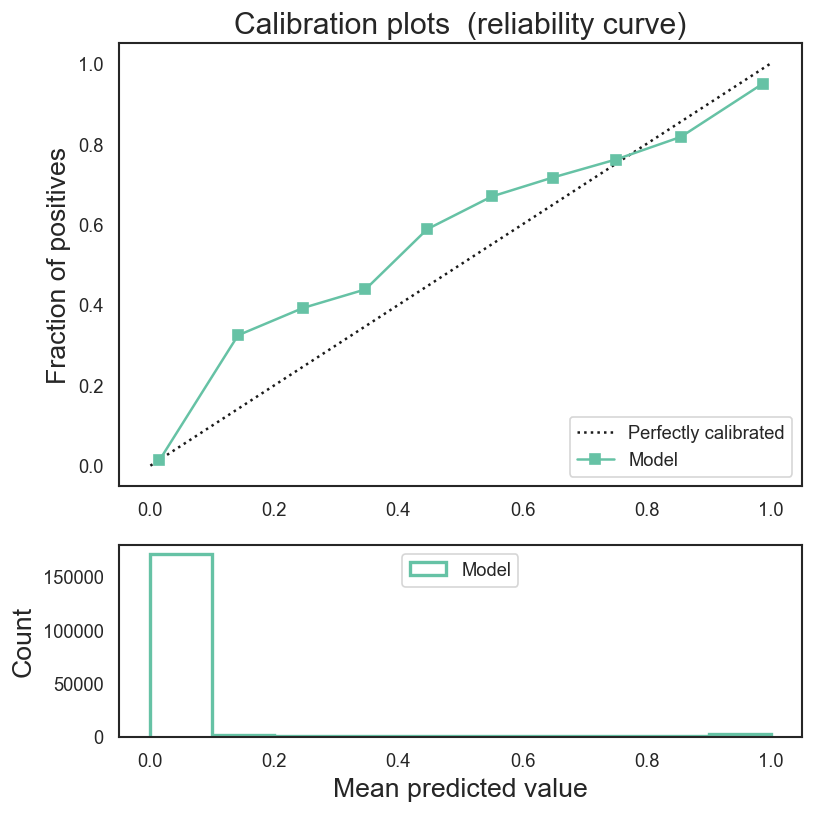

In [152]:
draw_calibration_curve(y_test, y_prob_pred_calib, n_bins=10)

In [153]:
concordance(y_test.values, y_prob_pred_calib)

0.9456479526988175

- Accuracy score is 0.98
- AUC score and Concordance index are 0.95, which are the best so far
- Classfication report is also balanced between both the classes
- ROC curve and PR are the best so far
- Recall is also 0.50 ,which is really good

# 13. Feature Importance

In [154]:
feature_importance_df = pd.DataFrame({'feature' : X_train.columns, 'importance' : lgbmclassifier.feature_importances_ })

In [155]:
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)
feature_importance_df = feature_importance_df.iloc[:30,:]
feature_importance_df

feature  importance
2                           card1         597
3                           card2         461
8                           addr1         396
25                            C13         320
496                         _Days         276
501   TransactionAmt_to_std_card1         275
13                             C1         263
499  TransactionAmt_to_mean_card1         252
510                       PCA_V_7         240
11                  P_emaildomain         223
532                      PCA_V_29         221
502   TransactionAmt_to_std_card4         212
516                      PCA_V_13         210
66                          id_20         209
40                            D15         209
524                      PCA_V_21         201
517                      PCA_V_14         200
70                          id_31         195
0                  TransactionAmt         194
519                      PCA_V_16         189
530                      PCA_V_27         189
518                      PCA_V_15         186
10                          dist1         185
503                       PCA_V_0         180
33                             D8         178
14                             C2         178
27                             D1         174
512                       PCA_V_9         171
515                      PCA_V_12         169
28                             D2         168

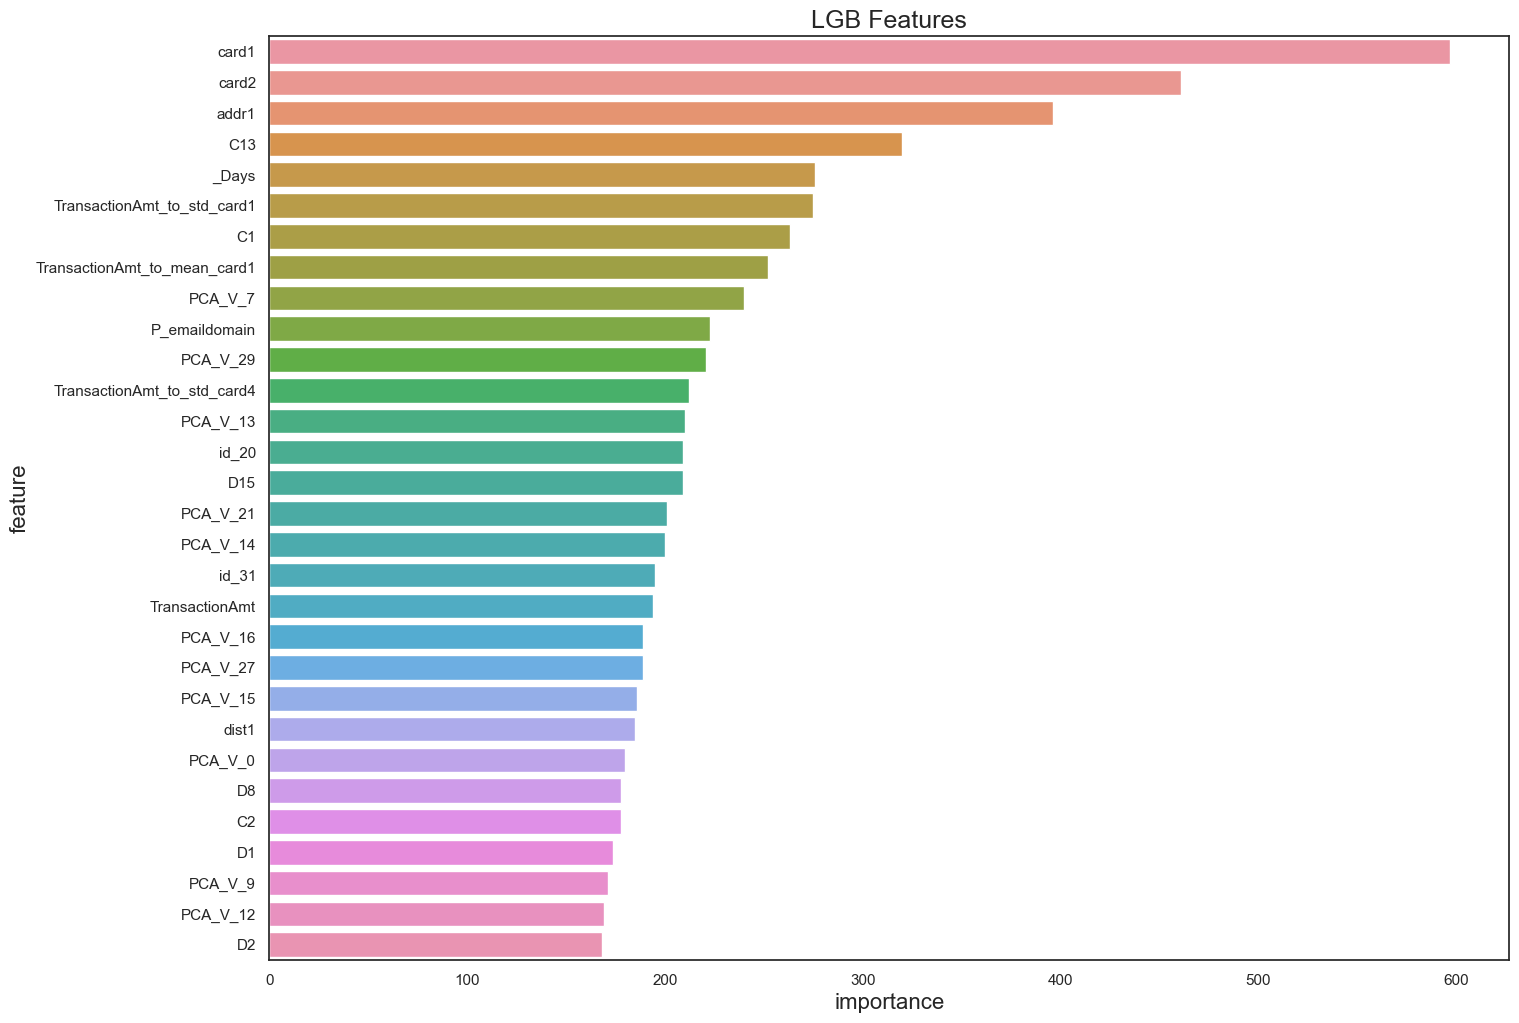

In [156]:
plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by="importance", ascending=False));
plt.title('LGB Features');

- card1 is contributing the most in predicting if a transaction is fraud or not
- card2, addr1, C13, P_emaildomain, C1,_days etc are some of the most important features in predicting the fraud
- Certain card types, addresses and emails are at high risk of fraud, so there is a need to monitor these carefully

# 14. Partial Dependence and Individual Conditional Expectations (ICEs)

## Plot Partial Dependence

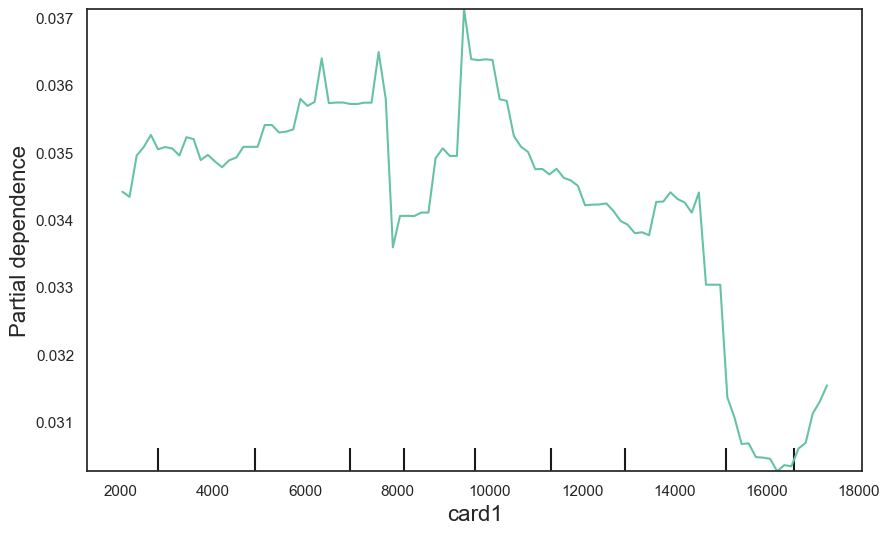

In [157]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    lgbmclassifier,        
    X_train,               
    features=['card1'],    
    ax=ax
)
plt.show()

## Individual Conditional Expectations

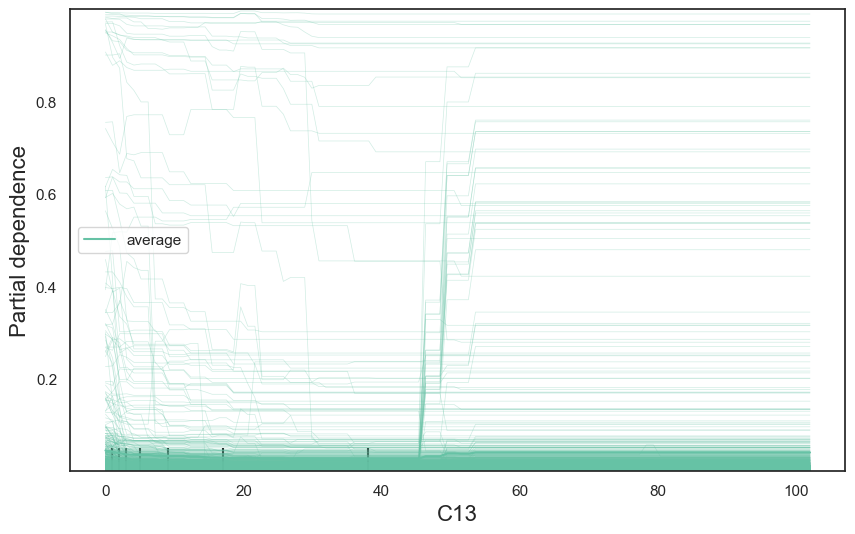

In [158]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    lgbmclassifier,       
    X_train,               
    features=['C13'],      
    kind='both',           
    ax=ax
)
plt.show()

# 15. SHAP Values

In [162]:
import shap

sample_size = 10000
X_sample = X_train.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(
    lgbmclassifier,
    feature_perturbation="tree_path_dependent"
)

shap_values = explainer.shap_values(X_sample) 

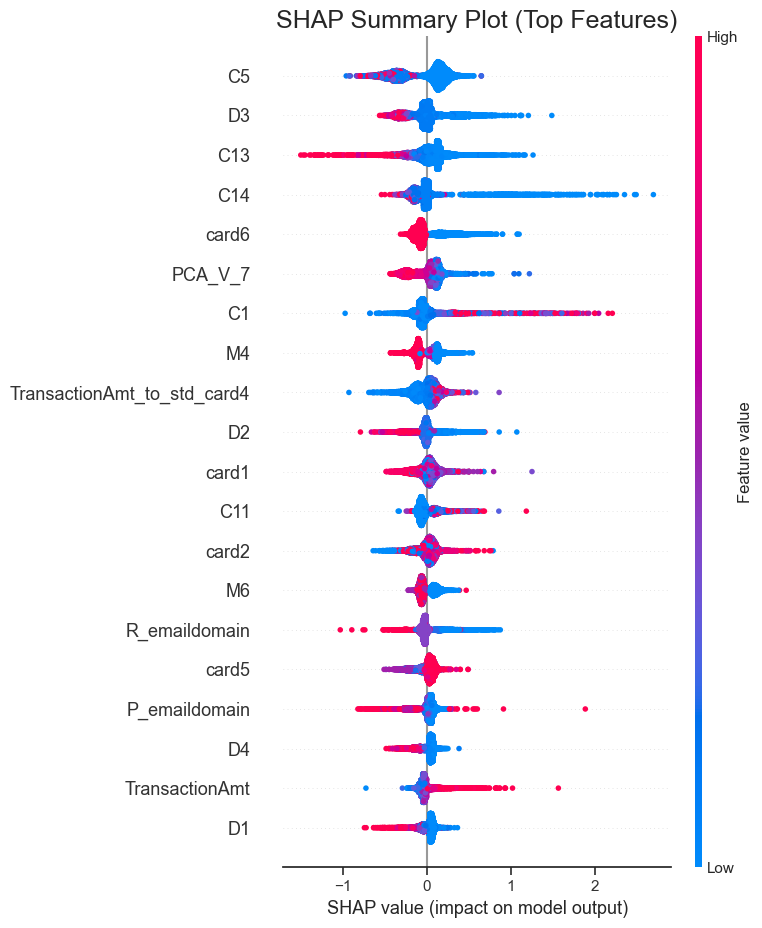

In [163]:
shap.initjs()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1], X_sample, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Top Features)")
plt.tight_layout()
plt.show()

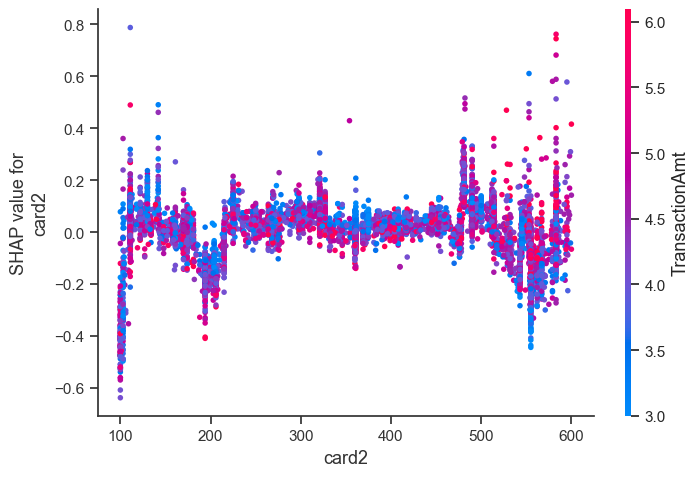

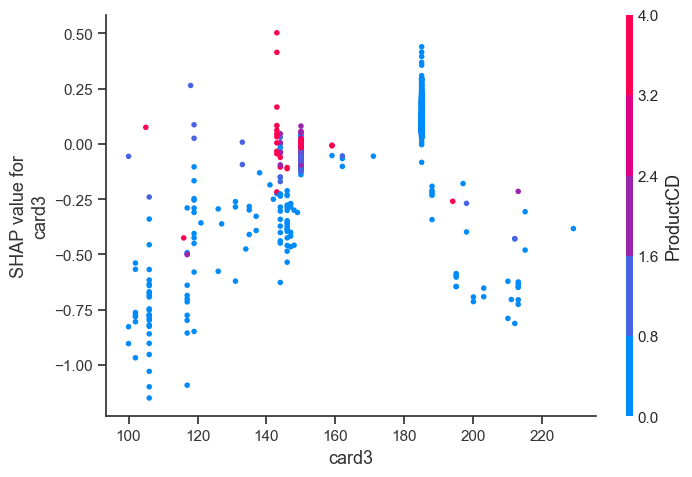

In [165]:
shap.initjs()
features_to_plot = ["card2", "card3"]
for feature in features_to_plot:
    shap.dependence_plot(feature, shap_values[1], X_sample, show=False)
    plt.tight_layout()
    plt.show()

In [168]:
index = 14
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][index],
    X_sample.iloc[index, :],
)

In [166]:
index = 14
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][index],
    X_sample.iloc[index, :],
    link="logit"
)

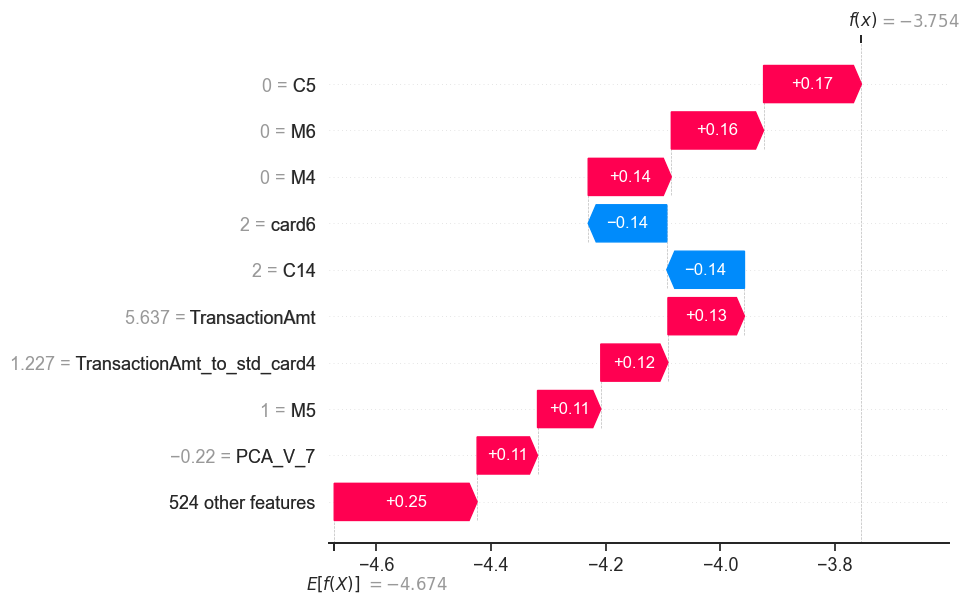

In [169]:
shap_exp = shap.Explanation(
    values=shap_values[1][index],
    base_values=explainer.expected_value[1],
    data=X_sample.iloc[index],
    feature_names=X_sample.columns
)
shap.plots.waterfall(shap_exp)

## 🧑‍💻 Author
**MIT TRIVEDI**

## 📂 Project
**Credit Card Fraud Detection**

## 📅 Date
**October 2025**

## 📬 Contact
[LinkedIn](https://www.linkedin.com/in/mit-trivedi-8714a5344) · [GitHub](https://github.com/trivedimit) · [Email](mailto:trivedimit04@gmail.com)

## 📖 Summary
This project presents an **end-to-end credit card fraud detection pipeline** featuring:

- **Models:** Logistic Regression,LightGBM and XGBoost  
- **Feature Engineering:** Handling missing values, encoding, new features, etc.  
- **Model Evaluation:** AUC, confusion matrix, precision, recall  
- **Explainability:** SHAP visualizations for model interpretability  

All **code and notebooks are available in this repository** for reproducibility and experimentation.